# FomulaBEAT

4-1-2からの変更点
- outputをEmbedding層の逆変換を行う



In [1]:
version = '04-1-3'
model_dir = './model/' + version
data_path = 'data/eq03-2.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import torch.nn.functional as F
from torch import Tensor

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['+ + 3 4 + 1 2', '+ + 8 5 + 4 6', '+ + 4 8 + 9 9'] ['3 4 + 1 2 + +', '8 5 + 4 6 + +', '4 8 + 9 9 + +']


辞書データの作成

In [7]:

SPECIALS = ['<unk>', '<pad>', '<start>', '<end>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '<unk>': 10, '<pad>': 11, '<start>': 12, '<end>': 13, '+': 14, ' ': 15}


In [9]:
convert_text_to_indexes("+ + 1 5 + 8 5", vocab_src)


[12, 14, 15, 14, 15, 1, 15, 5, 15, 14, 15, 8, 15, 5, 13]

In [10]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([12, 14, 15, 14, 15,  6, 15,  8, 15, 14, 15,  6, 15,  7, 13])
Output: tensor([12,  6, 15,  8, 15, 14, 15,  6, 15,  7, 15, 14, 15, 14, 13])
元に戻した文章
Input: + + 6 8 + 6 7
Output: 6 8 + 6 7 + +


In [11]:
batch_size = 1024
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [12]:
len(train_data)

80000

Transoformerの設定

In [13]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [14]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        return tgt


In [15]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs, self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [16]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [17]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [18]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [19]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [20]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 4, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)


In [21]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


13 層

層名: token_embedding.embedding.weight
形状: torch.Size([16, 4])
値: Parameter containing:
tensor([[-0.3906,  0.0558, -0.1737,  0.2825],
        [ 0.2475, -0.2381, -0.0587, -0.2163],
        [-0.0617, -0.0614, -0.1134, -0.2658],
        [ 0.2740, -0.1869,  0.2201,  0.2290],
        [-0.2385, -0.2410,  0.1759, -0.3954],
        [ 0.3244,  0.1067,  0.1896,  0.3634],
        [-0.2304, -0.0596, -0.0774, -0.4633],
        [-0.0210, -0.1579, -0.4849, -0.3694],
        [-0.3035,  0.4144, -0.3308, -0.3848],
        [-0.0241,  0.4565, -0.3425,  0.2301],
        [-0.1536, -0.3193,  0.0613,  0.2750],
        [ 0.2071,  0.0132,  0.1795, -0.2302],
        [ 0.2635,  0.0074, -0.0901,  0.4194],
        [ 0.4604, -0.4773,  0.0731,  0.4518],
        [ 0.0600, -0.0563, -0.2890,  0.3716],
        [-0.0452,  0.2504,  0.5167, -0.0825]], device='cuda:0', requires_grad=True)

層名: decoder_layer.self_attn.in_proj_weight
形状: torch.Size([12, 4])
値: Parameter containing:
tensor([[ 0.5541,  0.2889,  0.5860, -0.20

## 学習実行

In [ ]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    
    counter += 1

学習したモデルの保存

In [23]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [24]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts.tolist(), vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(model.token_embedding(src))
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [ ]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

# 翻訳を実行
translation = translate(
    model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

In [ ]:
# 様々な入力を試してみる

text_list = {
'+ + 1 5 + 8 5':'1 5 + 8 5 + +',
'+ + 1 6 + 8 6':'1 6 + 8 6 + +',
'+ + 9 5 + 7 1':'9 5 + 7 1 + +',
'+ + 6 5 + 7 9':'6 5 + 7 9 + +',
'+ + 9 2 + 6 0':'9 2 + 6 0 + +'}
# text_list += { '+ 2 7':'2 7 -', '+ 9 7' : '9 7 -', '+ + 2 7 4' : '2 7 - 4 +', '+ + 6 9 - 7 3' : '6 9 - 7 3 - -', '+ + + + + + + 4 6 3 7 + 6 7 1 9 + + 3 6 2' : '4 6 + 3 + 7 + 6 7 + + 1 + 9 - 3 6 + 2 + + '}

for text, tgt in text_list.items():
    translation = translate(
        model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    print(f"Input: {text}")
    print(f"Output: {translation}")
    print(f"Target: {tgt}")
    print('---')


## モデルの動作を分析

In [22]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 4, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)

In [23]:

# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())

for k, v in params.items():
    print(k, v.shape)



token_embedding.embedding.weight torch.Size([16, 4])
decoder_layer.self_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.self_attn.in_proj_bias torch.Size([12])
decoder_layer.self_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.self_attn.out_proj.bias torch.Size([4])
decoder_layer.multihead_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.multihead_attn.in_proj_bias torch.Size([12])
decoder_layer.multihead_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.multihead_attn.out_proj.bias torch.Size([4])
decoder_layer.norm1.weight torch.Size([4])
decoder_layer.norm1.bias torch.Size([4])
decoder_layer.norm2.weight torch.Size([4])
decoder_layer.norm2.bias torch.Size([4])


In [25]:

# パラメータを取り出す

# 埋め込み行列を取得
embedding_weight = params['token_embedding.embedding.weight'].data


# デコーダの自己注意の重みとバイアス
self_attn_in_proj_weight = params['decoder_layer.self_attn.in_proj_weight'].data
self_attn_in_proj_bias = params['decoder_layer.self_attn.in_proj_bias'].data
self_attn_out_proj_weight = params['decoder_layer.self_attn.out_proj.weight'].data
self_attn_out_proj_bias = params['decoder_layer.self_attn.out_proj.bias'].data

# メモリー注意の重みとバイアス
multihead_attn_in_proj_weight = params['decoder_layer.multihead_attn.in_proj_weight'].data
multihead_attn_in_proj_bias = params['decoder_layer.multihead_attn.in_proj_bias'].data
multihead_attn_out_proj_weight = params['decoder_layer.multihead_attn.out_proj.weight'].data
multihead_attn_out_proj_bias = params['decoder_layer.multihead_attn.out_proj.bias'].data

# LayerNormのパラメータ
norm1_weight = params['decoder_layer.norm1.weight'].data
norm1_bias = params['decoder_layer.norm1.bias'].data
norm2_weight = params['decoder_layer.norm2.weight'].data
norm2_bias = params['decoder_layer.norm2.bias'].data


In [26]:

# Positional Encoding
def positional_encoding(tensor: Tensor, maxlen=5000):
    embedding_size = tensor.size(-1)
    den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    embedding_pos = torch.zeros((maxlen, embedding_size))
    embedding_pos[:, 0::2] = torch.sin(pos * den)
    embedding_pos[:, 1::2] = torch.cos(pos * den)
    embedding_pos = embedding_pos.unsqueeze(-2)
    return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# ヒートマップを描画する関数
def visualize_attention(attn_weights, src_tokens, tgt_tokens, title="Attention Weights"):
    """
    attn_weights: Attention weights (2D numpy array)
    src_tokens: Source tokens (list of token strings)
    tgt_tokens: Target tokens (list of token strings)
    title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    sns.heatmap(attn_weights, cmap="viridis", xticklabels=src_tokens, yticklabels=tgt_tokens)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title(title)
    plt.show()


# インデックスからlistに戻す
def convert_indexes_to_list(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return [reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx]]


def visualize_scatter(points, title="Scatter Plot"):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1])
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(title)
    plt.show()

## Embeddingを見る

tensor([[ 0.4718,  0.2091],
        [ 0.4729,  0.2428],
        [ 0.4703,  0.2087],
        [ 0.1760,  1.1350],
        [ 0.4816,  0.1508],
        [ 0.4716,  0.2112],
        [ 0.4719,  0.2162],
        [ 0.4698,  0.2061],
        [ 0.1771,  1.1365],
        [ 0.4737,  0.2087],
        [ 0.1818, -0.4791],
        [ 0.0704, -0.6990],
        [ 0.3268, -0.1839],
        [ 1.1669, -1.0011],
        [ 0.2749, -1.2833],
        [-1.1135,  0.5614]])


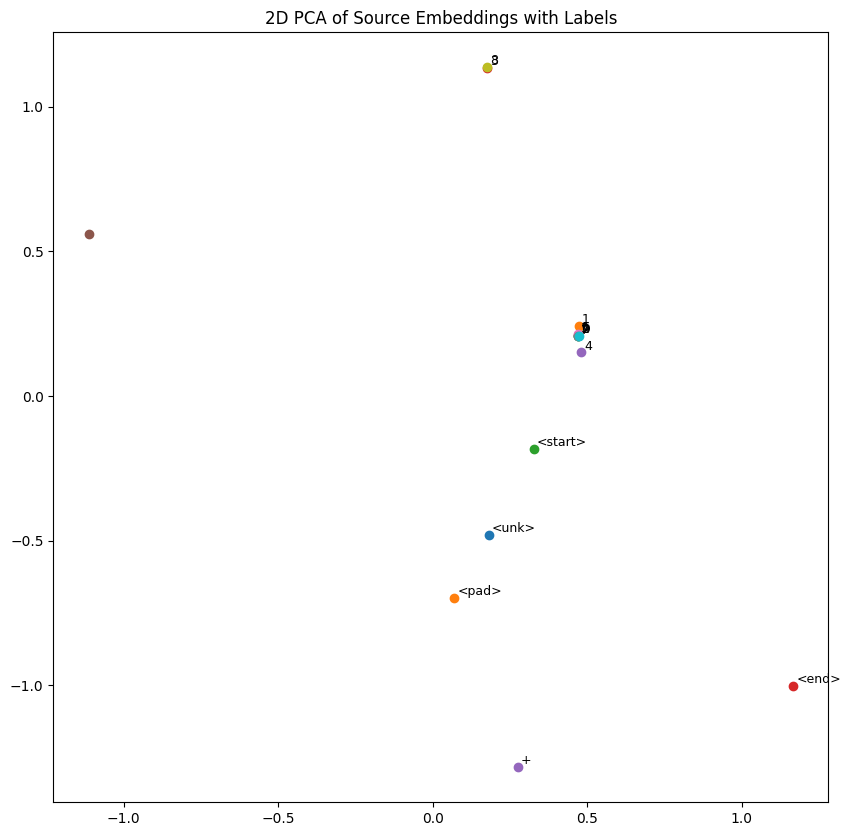

In [28]:
embedding_cpu = embedding_weight.cpu().detach()
print(embedding_cpu[: , :2])

# 逆辞書を作成してインデックスを文字に変換
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}

# 可視化
plt.figure(figsize=(10, 10))

# 各ポイントを散布図でプロットし、対応するラベルを表示
for i, (x, y) in enumerate(embedding_cpu[:, :2]):  # [:, :2]をスライスし、次にenumerate
    label = reverse_vocab_src[i]  # インデックスを元のトークンに戻す
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)  # 各点の近くにラベルを表示

plt.title("2D PCA of Source Embeddings with Labels")
plt.show()

## Attentionを確認

In [30]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    # visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    # visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

text: + + 1 5 + 8 5
memory: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.3912, -2.0263,  1.2884,  3.6989]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 0.6909, -3.5566,  1.3084,  3.6985]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.0132,  0.7693, -2.6912,  1.1645]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6001,  1.1764, -2.7067,  1.1569]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 0.9619, -3.4777,  1.3683,  3.6949]],

        [[-2.7710,  0.2837,  2.0539,  0.0815]],

        [[-0.6457,  2.2775, -0.2902,  2.9679]],

        [[-2.7636,  1.9667,  2.0738,  0.0793]],

        [[ 1.3633,  1.3299, -2.6470,  1.1509]],

        [[ 3.3245, -1.8654,  3.4778, -1.1044]]], device='cuda:0')
memory_size: torch.Size([15, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[ 0.6536,  0

text: + + 1 5 + 8 5
memory: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.3912, -2.0263,  1.2884,  3.6989]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 0.6909, -3.5566,  1.3084,  3.6985]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.0132,  0.7693, -2.6912,  1.1645]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6001,  1.1764, -2.7067,  1.1569]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 0.9619, -3.4777,  1.3683,  3.6949]],

        [[-2.7710,  0.2837,  2.0539,  0.0815]],

        [[-0.6457,  2.2775, -0.2902,  2.9679]],

        [[-2.7636,  1.9667,  2.0738,  0.0793]],

        [[ 1.3633,  1.3299, -2.6470,  1.1509]],

        [[ 3.3245, -1.8654,  3.4778, -1.1044]]], device='cuda:0')
memory_size: torch.Size([15, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[ 0.6536,  0

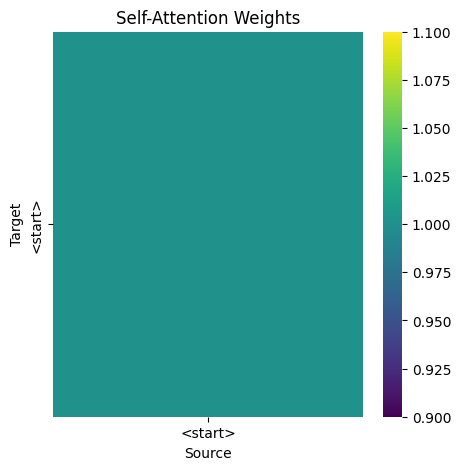

QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 1, 15])
AV.shape: torch.Size([1, 1, 4])
multi_attention: 
[[9.1559814e-06 1.3337229e-09 5.6113879e-07 8.6723261e-11 5.7021230e-06
  5.2168947e-01 1.4260570e-04 8.5259601e-02 8.0202085e-07 5.3750008e-11
  1.9904310e-06 2.3371059e-01 1.3810591e-04 1.5904137e-01 4.5929303e-16]]
After Attention: tensor([[[ 2.3029,  1.3697, -4.1026, -0.3016]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


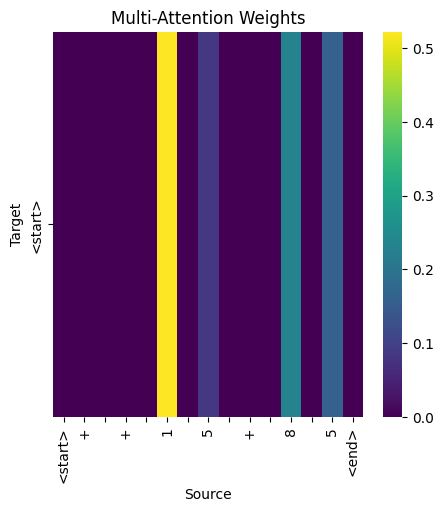

output.shape: torch.Size([1, 16])
output: tensor([[ 7.0466,  7.0196,  7.0481,  2.4877,  5.5116,  7.0471,  7.0403,  7.0412,  2.4875,  7.0556,
         -0.2732, -0.2850,  0.9647, -5.2157, -4.1542, -5.6661]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 9

------------------

iter: 1
ys: tensor([[12],
        [ 9]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]]], device='cuda:0')
now tgt: 9
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 2, 4])
WV.shape: torch.Size([1, 2, 4])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 4])
self_attention: 
[[0.14359471 0.8564053 ]
 [0.21462703 0.785373  ]]
tgt_tokens: ['<start>', '9']


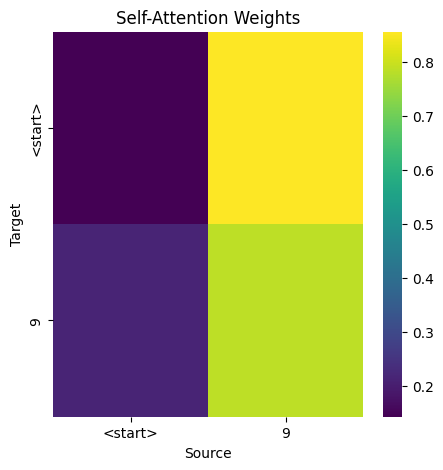

QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 2, 15])
AV.shape: torch.Size([1, 2, 4])
multi_attention: 
[[8.3252024e-07 1.4717265e-09 1.9701316e-09 2.6315670e-11 2.4670674e-09
  2.2061066e-01 1.7175734e-07 2.8543207e-01 3.2428802e-09 2.2404259e-11
  1.0225197e-09 9.0613931e-02 1.1395150e-07 4.0334222e-01 3.8820996e-17]
 [2.1462358e-06 3.5919957e-14 5.8322690e-05 3.9439201e-15 1.4525291e-02
  1.6820626e-03 3.7031206e-01 1.4064027e-05 9.0051632e-05 1.6171005e-15
  3.2312162e-03 2.9405274e-03 6.0709429e-01 4.9986240e-05 7.2380507e-17]]
After Attention: tensor([[[ 1.1184,  3.6091, -4.2802, -0.5697]],

        [[-3.3043,  4.2071,  2.4525, -1.0367]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


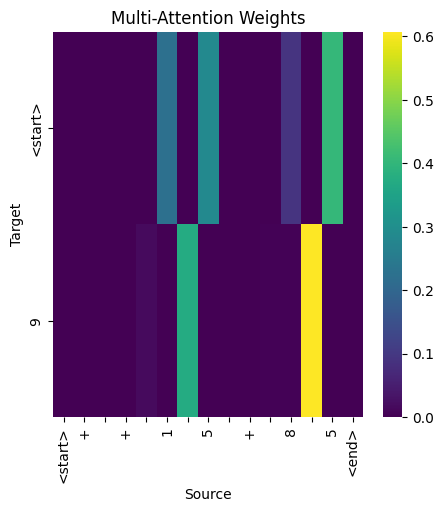

output.shape: torch.Size([1, 16])
output: tensor([[-4.1655, -3.9883, -4.1680,  2.6772, -4.6276, -4.1569, -4.1291, -4.1770,  2.6825, -4.1768,
         -1.5157, -2.2300, -1.4486, -2.8883, -6.1387,  8.9110]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 2
ys: tensor([[12],
        [ 9],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]]], device='cuda:0')
now tgt: 9 
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 3, 4])
WV.shape: torch.Size([1, 3, 4])
attn_weight.shape: torch.Size([1, 3, 3])
AV.shape: torch.Size([1, 3, 4])
self_attention: 
[[0.13989937 0.83436614 0.02573447]
 [0.2028238  0.7421821  0.05499416]


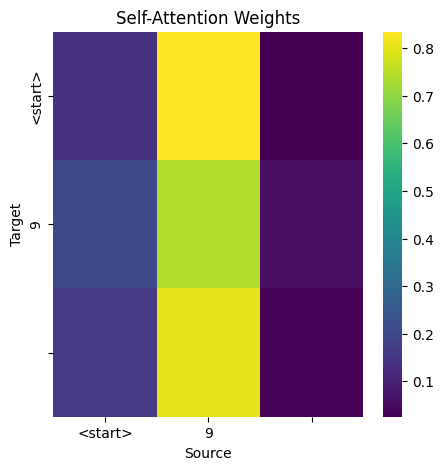

QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 3, 15])
AV.shape: torch.Size([1, 3, 4])
multi_attention: 
[[9.6247334e-07 1.3737608e-09 2.6799123e-09 2.5301350e-11 3.6943486e-09
  2.3258498e-01 2.5343445e-07 2.7470732e-01 4.4076289e-09 2.1253312e-11
  1.5128356e-09 9.7886868e-02 1.7085175e-07 3.9481944e-01 4.3584633e-17]
 [4.0340194e-07 1.8499968e-15 3.4097571e-05 2.5980570e-16 1.5831936e-02
  1.4890906e-04 3.4651384e-01 6.8519950e-07 5.2015301e-05 9.7792601e-17
  3.2935545e-03 3.0931603e-04 6.3381243e-01 2.7064523e-06 1.5188298e-17]
 [1.8984304e-10 4.8082192e-08 1.1419169e-16 2.5677532e-10 1.0108826e-18
  4.6451231e-03 1.0732843e-16 6.3407862e-01 1.8602078e-16 4.3519377e-10
  8.2204884e-19 4.9460825e-04 3.1915831e-17 3.6078167e-01 9.9522895e-20]]
After Attention: tensor([[[ 1.1025,  3.6306, -4.2768, -0.5712]],

        [[-3.2673,  4.2369,  2.4270, -1.0757]],

        [[ 0.9175,  3.9256, -4.1133, -0.697

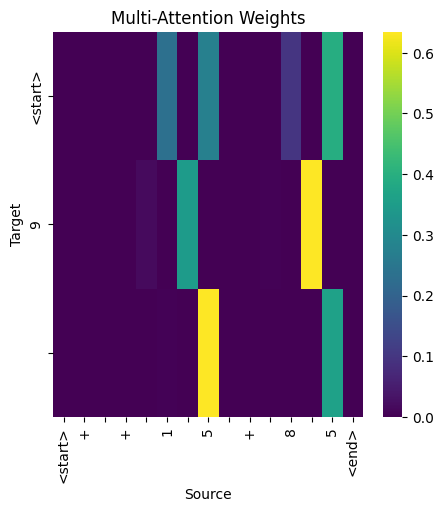

output.shape: torch.Size([1, 16])
output: tensor([[ 6.9113,  6.9668,  6.9131,  4.7565,  4.8634,  6.9169,  6.9221,  6.9000,  4.7585,  6.9168,
         -1.3993, -1.7626,  0.2646, -8.9943, -8.3561, -2.5181]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 3
ys: tensor([[12],
        [ 9],
        [15],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]]], device='cuda:0')
now tgt: 9 1
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 4, 4])
WV.shape: torch.Size([1, 4, 4])
attn_weight.shape: torch.Size([1, 4, 4])
AV.shape:

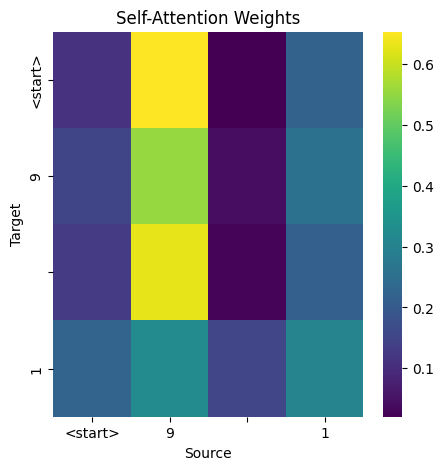

QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 4, 15])
AV.shape: torch.Size([1, 4, 4])
multi_attention: 
[[1.9231381e-06 9.6418606e-10 1.1886602e-08 2.0487466e-11 2.6111460e-08
  2.9239452e-01 1.6687159e-06 2.2199382e-01 1.9480632e-08 1.6129547e-11
  1.0087642e-08 1.3911374e-01 1.2160190e-06 3.4649307e-01 7.7018688e-17]
 [3.2513196e-07 1.2642437e-15 3.1806376e-05 1.8343404e-16 1.6011620e-02
  1.0906611e-04 3.4331325e-01 4.6438842e-07 4.8436395e-05 6.8279670e-17
  3.3023132e-03 2.3147777e-04 6.3694930e-01 1.8593508e-06 1.2403478e-17]
 [4.7198329e-10 3.1194919e-08 6.8874181e-16 1.8734067e-10 1.0588051e-17
  7.4743894e-03 1.0918788e-15 6.0822541e-01 1.1253105e-15 2.9380995e-10
  7.9560217e-18 9.1592933e-04 3.5429731e-16 3.8338426e-01 1.6758218e-19]
 [6.8976569e-10 3.4026404e-20 4.3652258e-06 1.5292967e-20 2.5604786e-02
  2.0576708e-08 2.5156200e-01 8.1392228e-12 6.0989164e-06 4.0060317e-21
  4.1154521e-03

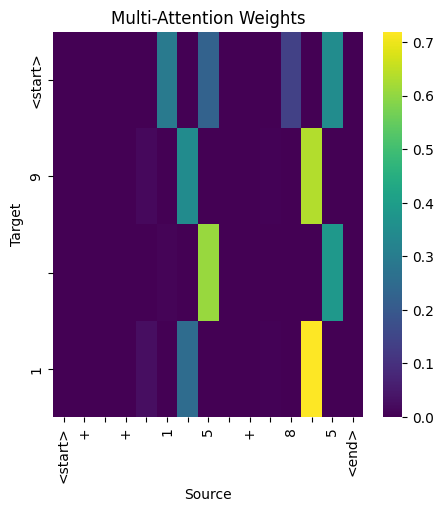

output.shape: torch.Size([1, 16])
output: tensor([[-4.4338, -4.2576, -4.4369,  2.4123, -4.9268, -4.4257, -4.3978, -4.4456,  2.4176, -4.4452,
         -1.3376, -2.0426, -1.3583, -2.2586, -5.9954,  9.0089]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 4
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]]], device='cuda:0')
now tgt: 9 1 
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 5, 4])


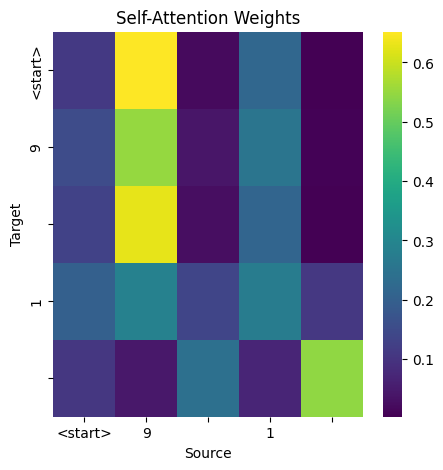

QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 5, 15])
AV.shape: torch.Size([1, 5, 4])
multi_attention: 
[[1.9666438e-06 9.5232122e-10 1.2484412e-08 2.0334600e-11 2.7856343e-08
  2.9441437e-01 1.7758150e-06 2.2023760e-01 2.0457561e-08 1.5974394e-11
  1.0740930e-08 1.4064322e-01 1.2974521e-06 3.4469968e-01 7.8448413e-17]
 [2.5731646e-07 8.3644429e-16 2.9510960e-05 1.2568248e-16 1.6203022e-02
  7.7584074e-05 3.3986843e-01 3.0394270e-07 4.4861255e-05 4.6229305e-17
  3.3111759e-03 1.6868896e-04 6.4029491e-01 1.2349069e-06 1.0003472e-17]
 [4.6579463e-10 3.1411886e-08 6.7116196e-16 1.8841569e-10 1.0239415e-17
  7.4262163e-03 1.0558779e-15 6.0860831e-01 1.0964492e-15 2.9580502e-10
  7.7028614e-18 9.0790581e-04 3.4220541e-16 3.8305750e-01 1.6626599e-19]
 [4.1058832e-12 5.4518627e-24 9.1512737e-07 5.9801206e-24 3.5886995e-02
  1.0078230e-11 1.9047603e-01 6.3391755e-16 1.2061149e-06 1.2069807e-24
  4.8222914e-03

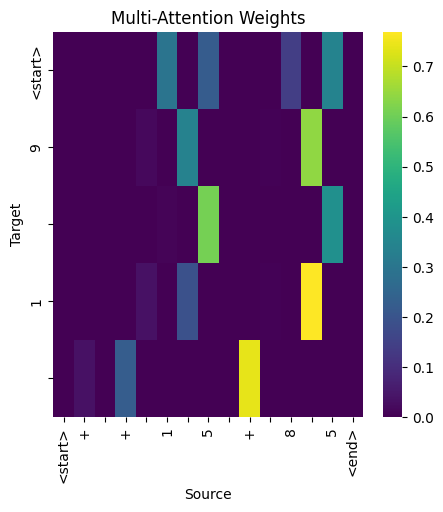

output.shape: torch.Size([1, 16])
output: tensor([[-0.7807, -0.8700, -0.7696, -0.1108,  2.5510, -0.7796, -0.7942, -0.7571, -0.1161, -0.7801,
         -2.0150, -1.6747, -1.9086, -2.5546,  8.4445, -2.0688]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 5
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]]], device='cuda:0')
now tgt: 9 1 +
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

     

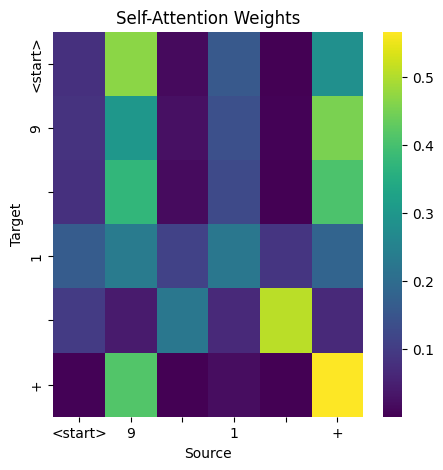

QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 6, 15])
AV.shape: torch.Size([1, 6, 4])
multi_attention: 
[[2.36199114e-08 1.26615196e-17 1.37272391e-05 2.75702814e-18
  1.84490215e-02 2.44531475e-06 3.05007935e-01 4.05173362e-09
  2.04406188e-05 8.96189913e-19 3.43223731e-03 6.73108116e-06
  6.73067391e-01 1.91117575e-08 1.09577939e-18]
 [1.22222667e-18 1.51407426e-34 1.98609094e-08 3.43027876e-33
  1.31588921e-01 1.75387697e-22 7.02236071e-02 7.19847854e-29
  2.11582041e-08 3.56522294e-34 1.26525071e-02 6.35651506e-21
  7.85534918e-01 1.28665515e-27 1.74255713e-25]
 [5.22089431e-06 5.07304476e-10 1.42768542e-07 1.66976519e-11
  8.40219172e-07 4.25711483e-01 3.97942822e-05 1.24648042e-01
  2.25243511e-07 1.13480857e-11 2.91147842e-07 2.23339841e-01
  3.42515305e-05 2.26219848e-01 1.36100857e-16]
 [5.65251688e-17 5.46426786e-32 4.00215683e-08 5.35051409e-31
  8.83146822e-02 2.61339391e-19 9.32127312e-02

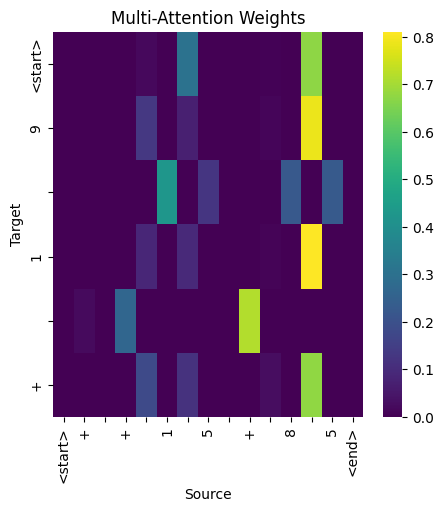

output.shape: torch.Size([1, 16])
output: tensor([[-7.2159, -7.0681, -7.2219, -0.1444, -7.2518, -7.2116, -7.1863, -7.2256, -0.1394, -7.2287,
         -0.1070, -0.6431, -0.9494,  3.1130, -2.7499,  9.5673]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 6
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]]], device='cuda:0')
now tgt: 9 1 + 
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1

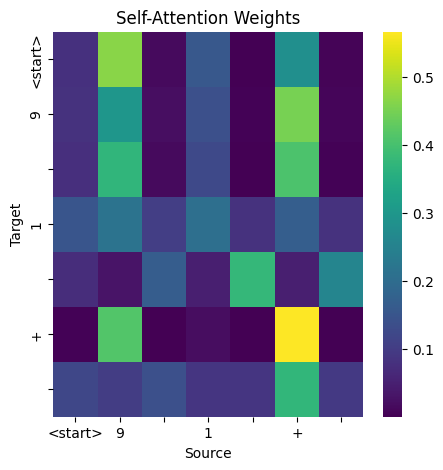

QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 7, 15])
AV.shape: torch.Size([1, 7, 4])
multi_attention: 
[[2.04574100e-08 9.84626005e-18 1.31179959e-05 2.19253527e-18
  1.85932312e-02 1.98038515e-06 3.02976429e-01 3.11773318e-09
  1.95095527e-05 7.07526507e-19 3.44022876e-03 5.53264272e-06
  6.74949825e-01 1.48374335e-08 9.64035370e-19]
 [1.04517693e-18 1.20341280e-34 1.92106473e-08 2.84228859e-33
  1.34323850e-01 1.33843177e-22 6.92464113e-02 5.20441882e-29
  2.03884802e-08 2.93350653e-34 1.28922425e-02 4.93841689e-21
  7.83537388e-01 9.37118415e-28 1.66380379e-25]
 [5.12338011e-06 5.15906373e-10 1.36776379e-07 1.69428638e-11
  7.94675259e-07 4.24659133e-01 3.76399403e-05 1.25835955e-01
  2.15730935e-07 1.15340801e-11 2.75863812e-07 2.21636206e-01
  3.23290151e-05 2.27792159e-01 1.33875953e-16]
 [3.07656966e-18 6.08199813e-34 1.95002450e-08 1.18708355e-32
  1.21588416e-01 2.25602930e-21 7.40959272e-02

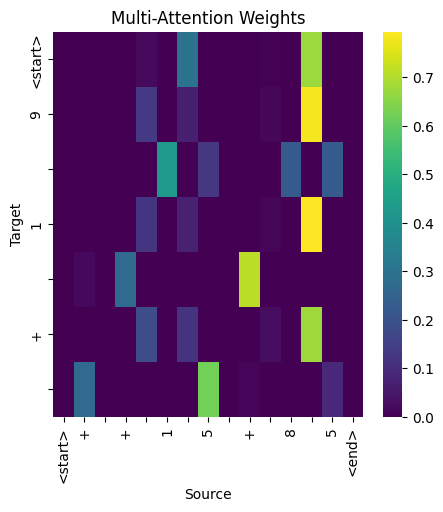

output.shape: torch.Size([1, 16])
output: tensor([[  7.2464,   7.3040,   7.2556,   6.6725,   6.6374,   7.2565,   7.2605,   7.2447,   6.6726,
           7.2505,  -3.5218,  -3.9189,  -1.3309, -14.2446,  -6.9146,  -2.0833]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 7
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]]], device='cuda:0')
now tgt: 9 1 + 1
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [

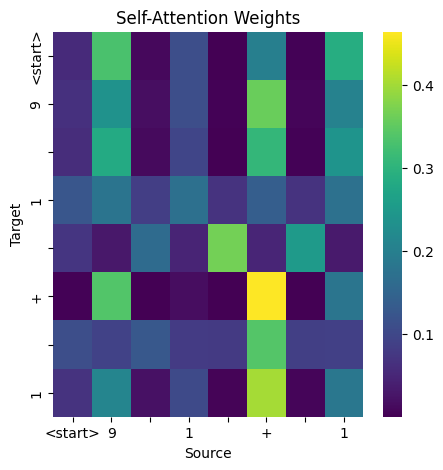

QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 8, 15])
AV.shape: torch.Size([1, 8, 4])
multi_attention: 
[[4.09773347e-05 9.70274642e-12 1.16445022e-04 6.69206010e-13
  8.39566067e-03 1.43222943e-01 2.82316953e-01 3.91824264e-03
  1.83367665e-04 3.25133800e-13 2.14244844e-03 1.75636470e-01
  3.72774273e-01 1.12522626e-02 1.17112247e-15]
 [9.98597529e-16 4.75692358e-30 9.88048754e-08 2.20771667e-29
  6.20461777e-02 1.19004556e-17 1.17399417e-01 5.05052260e-23
  1.20282621e-07 3.13084965e-30 6.75908523e-03 2.03916326e-16
  8.13795090e-01 6.40759225e-22 3.65682823e-24]
 [8.85656704e-08 4.02494837e-09 2.20952093e-11 5.52374778e-11
  7.96219167e-12 9.96642113e-02 5.88800342e-10 4.13751930e-01
  3.58196979e-11 5.55470392e-11 3.91191159e-12 2.63393428e-02
  3.18314458e-10 4.60244417e-01 5.61950691e-18]
 [4.49211387e-15 6.16327374e-29 1.28205613e-07 2.38876967e-28
  5.89398667e-02 2.75472293e-16 1.26244098e-01

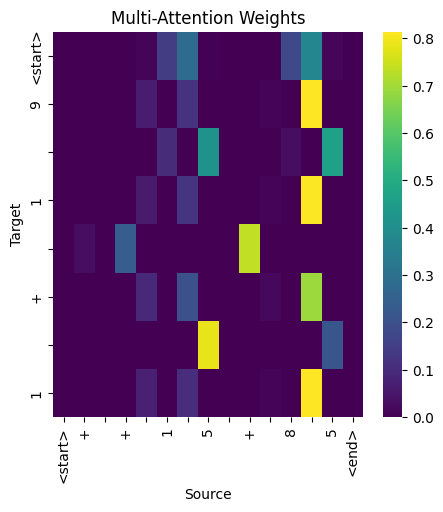

output.shape: torch.Size([1, 16])
output: tensor([[-2.9552, -2.7796, -2.9606,  2.4342, -4.3922, -2.9482, -2.9206, -2.9723,  2.4403, -2.9644,
         -0.6939, -1.4109, -0.6001, -1.8377, -7.8540,  7.8294]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 8
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]]], device='cuda:0')
now tgt: 9 1 + 1 
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [

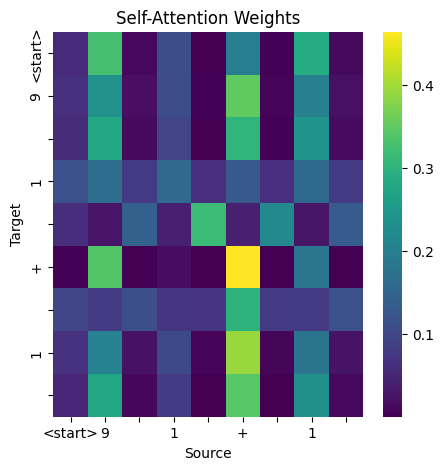

QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 9, 15])
AV.shape: torch.Size([1, 9, 4])
multi_attention: 
[[3.51640956e-05 6.77496254e-12 1.18832395e-04 4.84398817e-13
  9.44383536e-03 1.10117137e-01 3.10883135e-01 2.74486956e-03
  1.86829740e-04 2.32199080e-13 2.38357205e-03 1.38608024e-01
  4.17463362e-01 8.01518094e-03 1.00764268e-15]
 [5.38501620e-16 1.77370531e-30 8.42015808e-08 9.40453635e-30
  6.58951700e-02 4.40574303e-18 1.12530388e-01 1.50582345e-23
  1.01436399e-07 1.29513861e-30 7.07425131e-03 8.07674106e-17
  8.14499974e-01 1.97511459e-22 2.57532517e-24]
 [7.92921568e-08 4.23546753e-09 1.77322757e-11 5.73776686e-11
  6.00009929e-12 9.52205881e-02 4.44905307e-10 4.19286013e-01
  2.87267120e-11 5.81949280e-11 2.97398889e-12 2.46585310e-02
  2.38084802e-10 4.60834742e-01 5.16543191e-18]
 [1.53570303e-16 2.73275165e-31 5.17873531e-08 2.18099397e-30
  8.10173005e-02 1.34231706e-18 9.99253392e-02

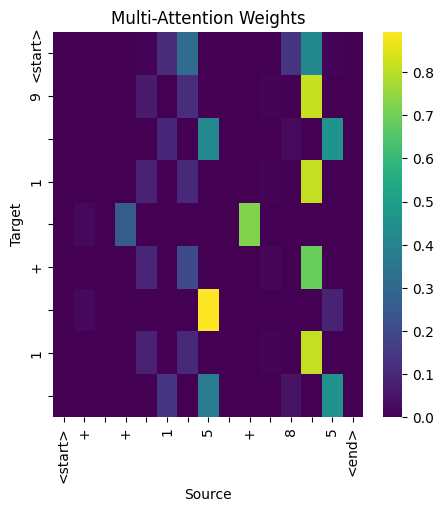

output.shape: torch.Size([1, 16])
output: tensor([[ 7.3178,  7.3508,  7.3200,  4.4096,  5.4082,  7.3223,  7.3240,  7.3083,  4.4109,  7.3245,
         -1.2500, -1.5243,  0.3964, -8.6077, -7.4046, -3.5770]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 9
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 1.3579, -0.4255, -2.6513,  1.1617]]], device='cuda:0')
now tgt: 9 1 + 1 1
tgt_em

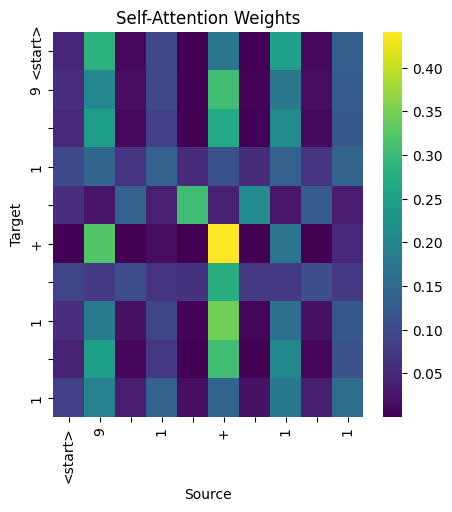

QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 10, 15])
AV.shape: torch.Size([1, 10, 4])
multi_attention: 
[[5.46272095e-05 2.59662465e-11 8.68388306e-05 1.59328681e-12
  4.53189341e-03 2.77752221e-01 1.63068444e-01 1.03455596e-02
  1.37382478e-04 8.09249965e-13 1.19972648e-03 3.11120838e-01
  2.03607082e-01 2.80953776e-02 1.53634635e-15]
 [1.14547467e-14 2.45389282e-28 1.88553557e-07 6.85957120e-28
  4.95934412e-02 5.85329942e-16 1.37852758e-01 5.83248927e-21
  2.38554378e-07 1.09253660e-28 5.74436272e-03 7.66928872e-15
  8.06809127e-01 6.47420565e-20 1.57785434e-23]
 [4.69585082e-08 5.10210052e-09 6.18378612e-12 6.26875774e-11
  1.51457536e-12 7.44265094e-02 1.17826290e-10 4.45251882e-01
  1.00478861e-11 6.65558025e-11 7.82453637e-13 1.78968906e-02
  5.97885075e-11 4.62424695e-01 3.52714280e-18]
 [1.39164676e-14 3.94338610e-28 1.75573987e-07 1.22273768e-27
  5.37295155e-02 1.61463019e-15 1.35767192e

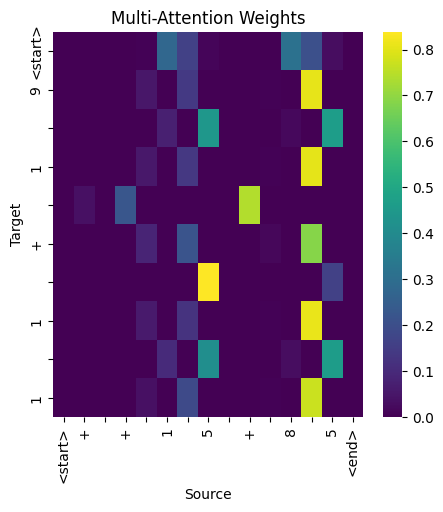

output.shape: torch.Size([1, 16])
output: tensor([[-4.1543, -3.9767, -4.1580,  2.4218, -4.8680, -4.1464, -4.1183, -4.1675,  2.4274, -4.1653,
         -1.1926, -1.9057, -1.1931, -2.1464, -6.4621,  8.8284]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 10
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15],
        [ 1],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 1.3579, -0.4255, -2.6513,  1.1617]],

        [[-2.7710,  0.2837

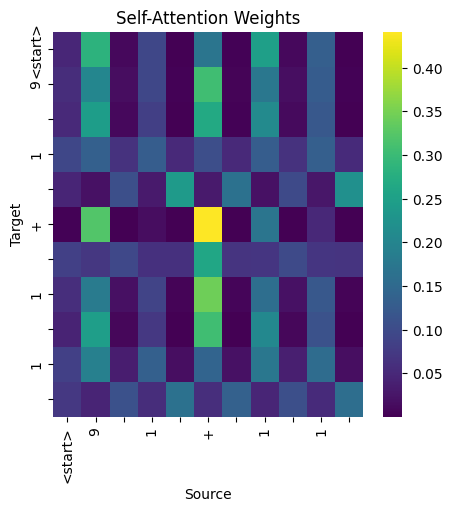

QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 11, 15])
AV.shape: torch.Size([1, 11, 4])
multi_attention: 
[[5.43309470e-05 2.50195229e-11 8.86766429e-05 1.54350502e-12
  4.69712028e-03 2.71694034e-01 1.68483213e-01 9.97724105e-03
  1.40257936e-04 7.82355029e-13 1.24135846e-03 3.05551320e-01
  2.10907936e-01 2.71644946e-02 1.52803357e-15]
 [1.01547612e-14 2.01619106e-28 1.82482054e-07 5.77505453e-28
  5.01186773e-02 4.84005373e-16 1.36793643e-01 4.62292907e-21
  2.30454205e-07 9.14478603e-29 5.78649575e-03 6.42478853e-15
  8.07300806e-01 5.16609383e-20 1.46102420e-23]
 [4.67389398e-08 5.11514564e-09 6.12755549e-12 6.28337105e-11
  1.49716361e-12 7.42944181e-02 1.16449086e-10 4.45455492e-01
  9.95568385e-12 6.67319464e-11 7.73749012e-13 1.78468209e-02
  5.90670082e-11 4.62403297e-01 3.51438147e-18]
 [1.17632590e-15 7.10520395e-30 8.89305483e-08 3.65947092e-29
  6.67840764e-02 3.40232919e-17 1.15259677e

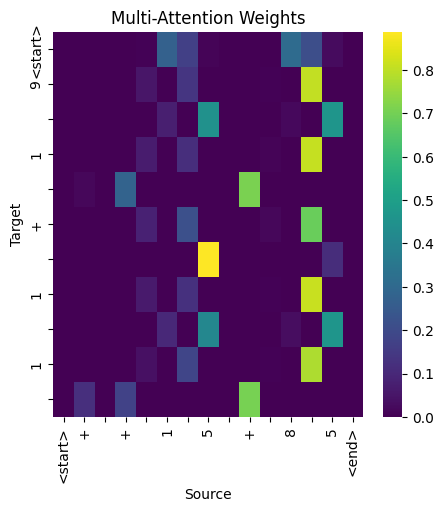

output.shape: torch.Size([1, 16])
output: tensor([[-1.0744, -1.1540, -1.0630,  0.0887,  2.3236, -1.0726, -1.0858, -1.0509,  0.0836, -1.0746,
         -2.1959, -1.8932, -2.0772, -2.9054,  8.2481, -1.5036]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 11
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15],
        [ 1],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 1.3579, -0.4255, -2.6513,  1.1617]],

        [[-2

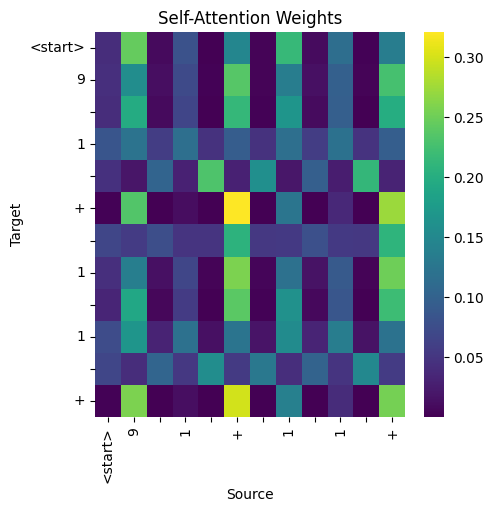

QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 12, 15])
AV.shape: torch.Size([1, 12, 4])
multi_attention: 
[[2.56242068e-08 1.45889481e-17 1.40959510e-05 3.13411289e-18
  1.83568969e-02 2.74350532e-06 3.06199342e-01 4.68594097e-09
  2.10081143e-05 1.02328952e-18 3.42641561e-03 7.49910805e-06
  6.71971858e-01 2.19902798e-08 1.18618558e-18]
 [9.28778244e-19 1.01351169e-34 1.87534166e-08 2.47126345e-33
  1.36483550e-01 1.08791441e-22 6.85084462e-02 4.06331977e-29
  1.98457890e-08 2.53749236e-34 1.30849453e-02 4.07090759e-21
  7.81922996e-01 7.35643368e-28 1.61679212e-25]
 [8.51434561e-06 3.38341494e-10 4.62434002e-07 1.25690049e-11
  4.03477725e-06 4.58687931e-01 1.79993964e-04 9.24533010e-02
  7.27671704e-07 8.09024549e-12 1.33154003e-06 2.68525004e-01
  1.65522506e-04 1.79973200e-01 2.05869333e-16]
 [8.21313172e-18 2.67675786e-33 2.47277718e-08 4.06787608e-32
  1.07821353e-01 1.11527146e-20 8.04988667e

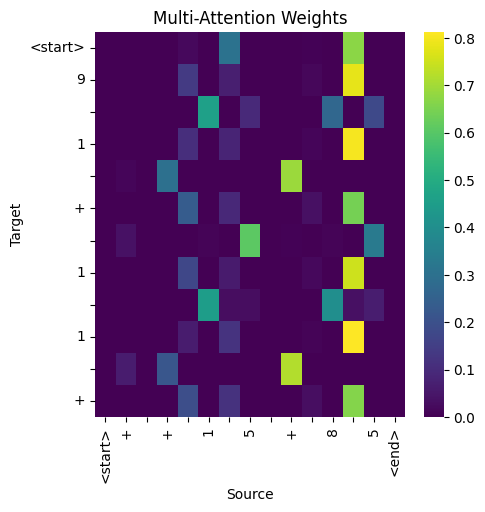

output.shape: torch.Size([1, 16])
output: tensor([[-7.3667, -7.2214, -7.3726, -0.2744, -7.3376, -7.3625, -7.3375, -7.3760, -0.2695, -7.3795,
         -0.0713, -0.5944, -0.9539,  3.3467, -2.4817,  9.5725]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 12
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15],
        [ 1],
        [15],
        [14],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 1.3579, -0.4255, -2.6513,  1.1617]],

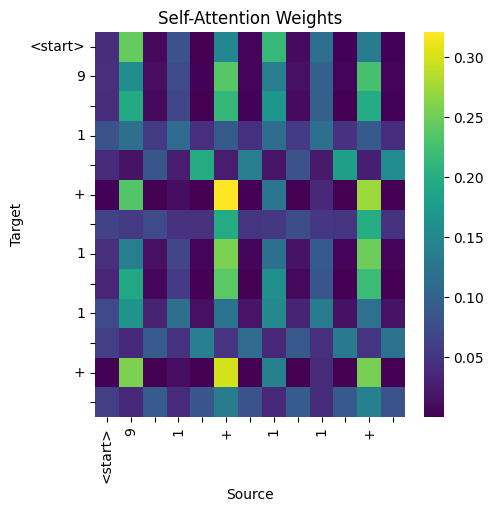

QV.shape: torch.Size([1, 13, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 13, 15])
AV.shape: torch.Size([1, 13, 4])
multi_attention: 
[[2.42102338e-08 1.32093183e-17 1.38453534e-05 2.86285742e-18
  1.84132252e-02 2.52435393e-06 3.05394620e-01 4.22541113e-09
  2.06247332e-05 9.32046952e-19 3.42951389e-03 6.94056735e-06
  6.72718644e-01 1.98988861e-08 1.12761333e-18]
 [8.71416164e-19 9.23419402e-35 1.85035134e-08 2.29046984e-33
  1.37646526e-01 9.74089232e-23 6.81129321e-02 3.55905053e-29
  1.95508374e-08 2.34518814e-34 1.31872827e-02 3.67170570e-21
  7.81053185e-01 6.46270637e-28 1.58805811e-25]
 [8.48009495e-06 3.39721556e-10 4.58253368e-07 1.26183231e-11
  3.98833527e-06 4.58612859e-01 1.77868700e-04 9.26495492e-02
  7.21010167e-07 8.12450020e-12 1.31671538e-06 2.68124342e-01
  1.63501914e-04 1.80256858e-01 2.05079329e-16]
 [1.88130298e-18 2.83529811e-34 1.73775732e-08 6.18457700e-33
  1.27758577e-01 9.75975784e-22 7.12672174e

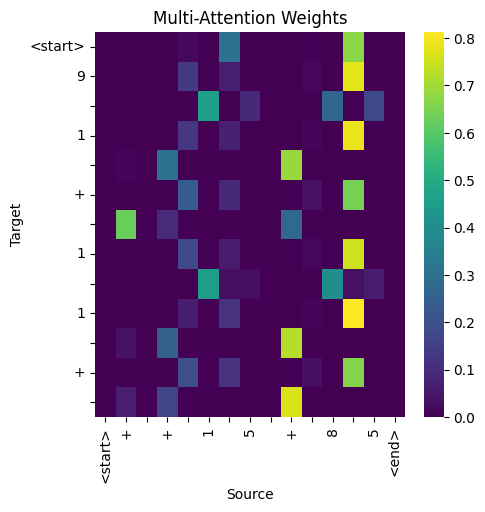

output.shape: torch.Size([1, 16])
output: tensor([[-0.1438, -0.2286, -0.1318,  0.4663,  3.1425, -0.1418, -0.1562, -0.1202,  0.4609, -0.1428,
         -2.3291, -2.0192, -2.0326, -3.8289,  7.8639, -2.2568]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 13
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 1.3579, -0.4255, -2.65

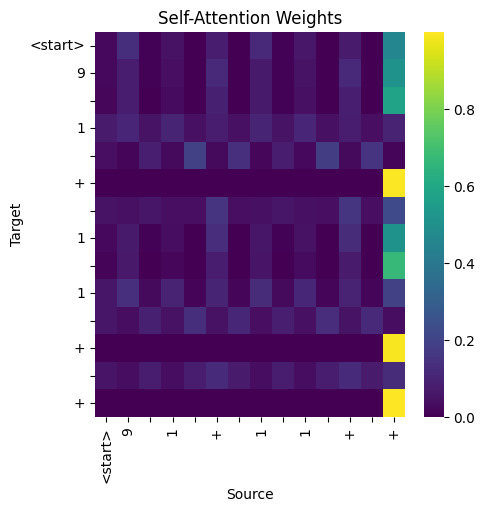

QV.shape: torch.Size([1, 14, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 14, 15])
AV.shape: torch.Size([1, 14, 4])
multi_attention: 
[[1.33333396e-21 2.14057379e-38 6.26029850e-09 4.45090597e-36
  3.84503335e-01 5.66604064e-28 2.91099753e-02 2.34910837e-35
  5.33168443e-09 3.49247522e-37 3.77876870e-02 4.53833466e-26
  5.48599005e-01 5.44837958e-34 1.93370515e-25]
 [3.03848950e-22 1.14502115e-38 6.72938327e-09 5.87653869e-36
  5.54526925e-01 1.26256941e-29 1.70766395e-02 3.60077429e-37
  5.13524911e-09 4.50420150e-37 6.17296696e-02 1.25874265e-27
  3.66666764e-01 8.21247390e-36 2.53884726e-24]
 [6.85477339e-23 5.60305379e-38 7.49648166e-09 1.46308605e-34
  7.72789955e-01 2.03282423e-31 4.40049963e-03 3.88596459e-39
  4.52392168e-09 1.09356625e-35 1.10986635e-01 1.90207324e-29
  1.11822978e-01 7.87503224e-38 2.39352768e-22]
 [6.00314633e-20 1.77493871e-36 8.18194756e-09 9.51827450e-35
  1.95366710e-01 2.60003249e-24 5.17346449e

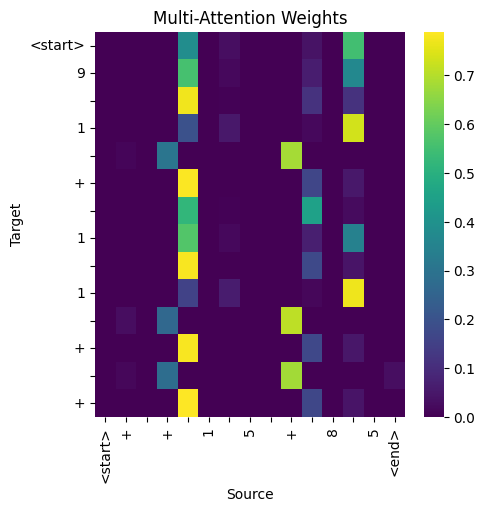

output.shape: torch.Size([1, 16])
output: tensor([[-5.5878, -5.5665, -5.5994, -4.2561, -6.3511, -5.5941, -5.5868, -5.5975, -4.2530, -5.5924,
          3.0407,  3.0375,  1.4810, 11.1827,  1.1635,  3.4023]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 13

------------------

Input: + + 1 5 + 8 5
Decoded sequence: 9 1 + 1 1 + +


In [32]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Multi-Attention Weights")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

## TGTのベクトル移動を観察

tensor([[ 0.4718,  0.2091],
        [ 0.4729,  0.2428],
        [ 0.4703,  0.2087],
        [ 0.1760,  1.1350],
        [ 0.4816,  0.1508],
        [ 0.4716,  0.2112],
        [ 0.4719,  0.2162],
        [ 0.4698,  0.2061],
        [ 0.1771,  1.1365],
        [ 0.4737,  0.2087],
        [ 0.1818, -0.4791],
        [ 0.0704, -0.6990],
        [ 0.3268, -0.1839],
        [ 1.1669, -1.0011],
        [ 0.2749, -1.2833],
        [-1.1135,  0.5614]])


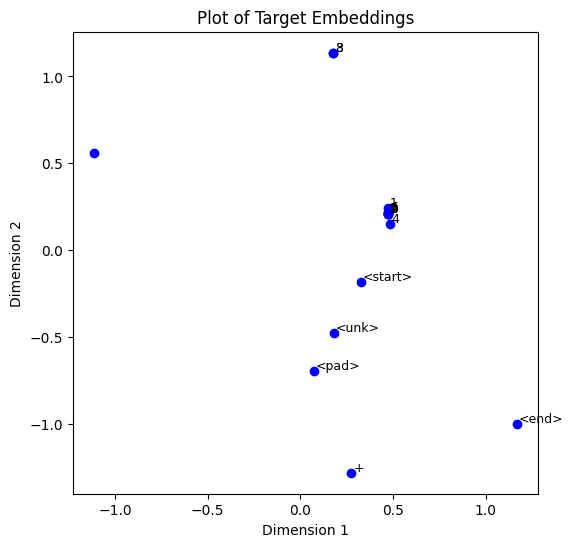

In [33]:
import numpy as np
embedding_cpu_01dim = embedding_weight.cpu().detach()[: , :2]
print(embedding_cpu_01dim)

reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

def plot_embedding_tgt_2d(ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))

    # 事前Embedding
    for i, (x, y) in enumerate(embedding_cpu_01dim):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9) 

    if tgt_embed is not None:
        tgt_embed = tgt_embed.detach().cpu().numpy()
        print(tgt_embed)
        print(tgt_embed.shape)
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=1)
        tgt_embed_2d = tgt_embed[:, :2]
        print(tgt_embed_2d)
        for i, (x, y) in enumerate(tgt_embed_2d):
            if src is not None:
                label = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)[i] + f"({i})"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + f"({i})"
            plt.scatter(x, y, color='green', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, str(i)+label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


plot_embedding_tgt_2d()

text: + + 1 5 + 8 5
memory: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.3912, -2.0263,  1.2884,  3.6989]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 0.6909, -3.5566,  1.3084,  3.6985]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.0132,  0.7693, -2.6912,  1.1645]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6001,  1.1764, -2.7067,  1.1569]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 0.9619, -3.4777,  1.3683,  3.6949]],

        [[-2.7710,  0.2837,  2.0539,  0.0815]],

        [[-0.6457,  2.2775, -0.2902,  2.9679]],

        [[-2.7636,  1.9667,  2.0738,  0.0793]],

        [[ 1.3633,  1.3299, -2.6470,  1.1509]],

        [[ 3.3245, -1.8654,  3.4778, -1.1044]]], device='cuda:0')
memory_size: torch.Size([15, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[ 0.6536,  0

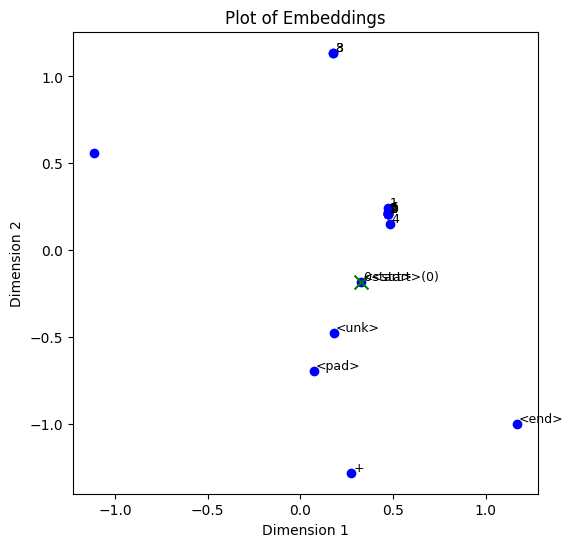

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]]
(1, 1, 4)
[[0.65358996 0.6321694 ]]


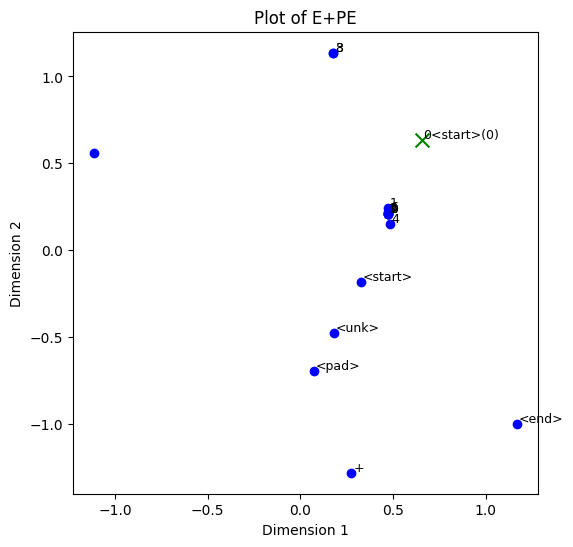

SelfAttention Layer
QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 1, 4])
WV.shape: torch.Size([1, 1, 4])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 4])
[[[-0.7040807  -0.34743014  0.2857638   0.910653  ]]]
(1, 1, 4)
[[-0.7040807  -0.34743014]]


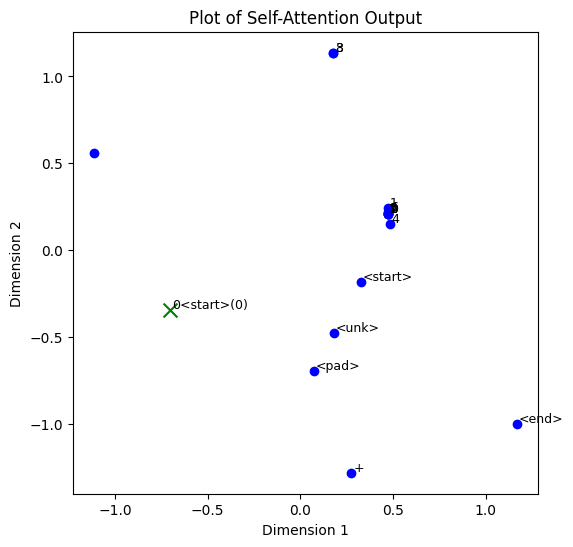

[[[-2.4189956  -0.33675453 -0.65325683  1.6257555 ]]]
(1, 1, 4)
[[-2.4189956  -0.33675453]]


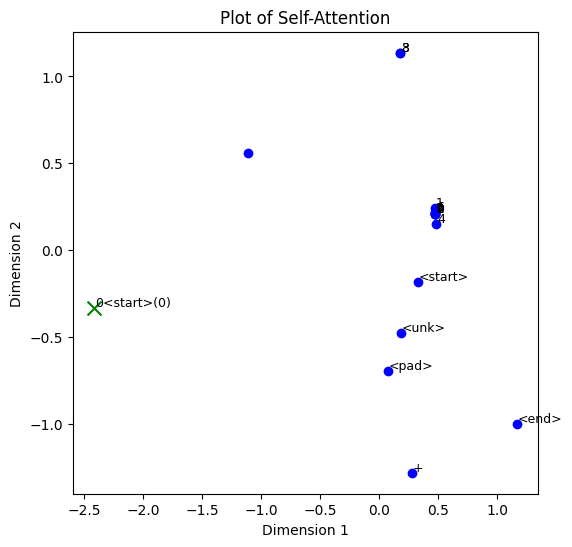

QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 1, 15])
AV.shape: torch.Size([1, 1, 4])
After Attention: tensor([[[ 2.3029,  1.3697, -4.1026, -0.3016]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[ 1.9030801  -0.66483223 -1.0642253  -2.9157193 ]]]
(1, 1, 4)
[[ 1.9030801  -0.66483223]]


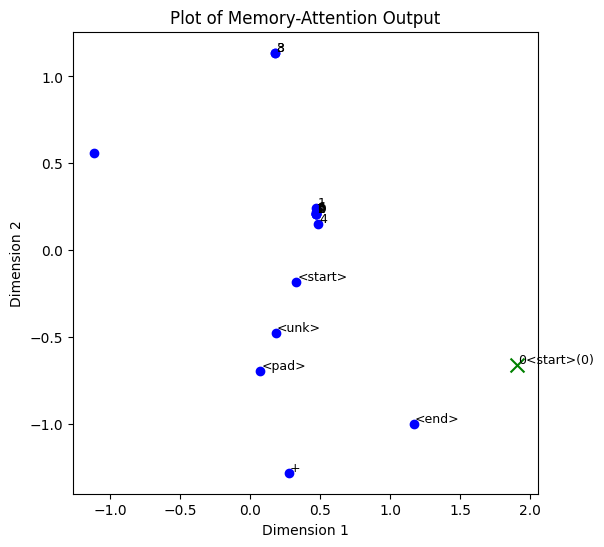

[[[ 2.3029332  1.3696699 -4.1026373 -0.301625 ]]]
(1, 1, 4)
[[2.3029332 1.3696699]]


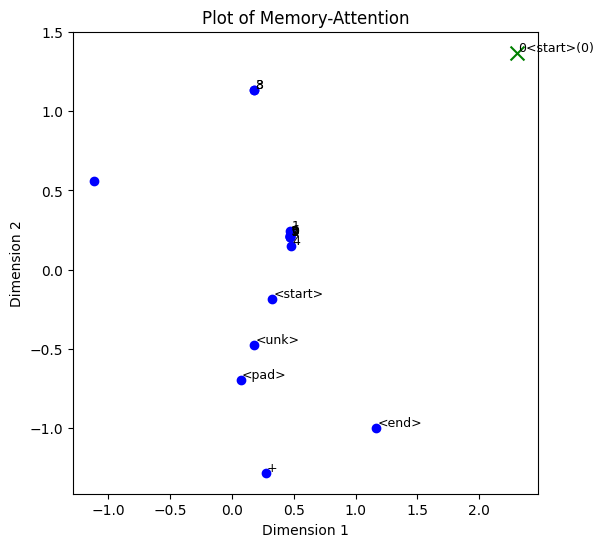

output.shape: torch.Size([1, 16])
output: tensor([[ 7.0466,  7.0196,  7.0481,  2.4877,  5.5116,  7.0471,  7.0403,  7.0412,  2.4875,  7.0556,
         -0.2732, -0.2850,  0.9647, -5.2157, -4.1542, -5.6661]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 9

------------------

iter: 1
ys: tensor([[12],
        [ 9]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]]], device='cuda:0')
now tgt: 9
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]]], device='cuda:0')
[[[ 0.32679498 -0.18391529 -0.07188573 -0.5606752 ]]

 [[ 0.47366697  0.20872964 -1.3899497   0.07807771]]]
(2, 1, 4)
[[ 0.32679498 -0.18391529]
 [ 0.47366697  0.20872964]]


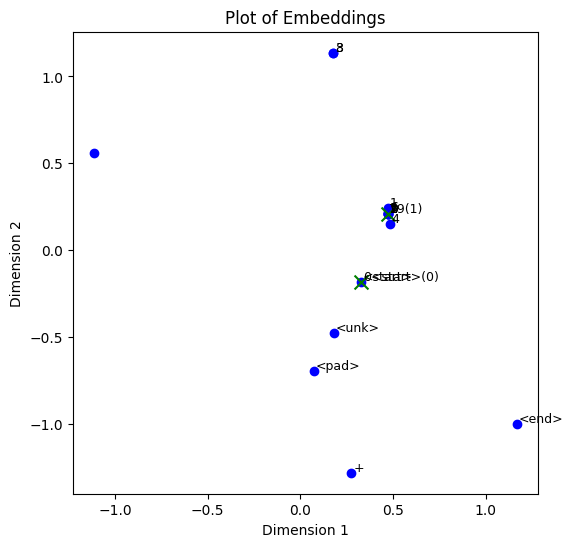

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]]
(2, 1, 4)
[[0.65358996 0.6321694 ]
 [1.7888049  0.95776165]]


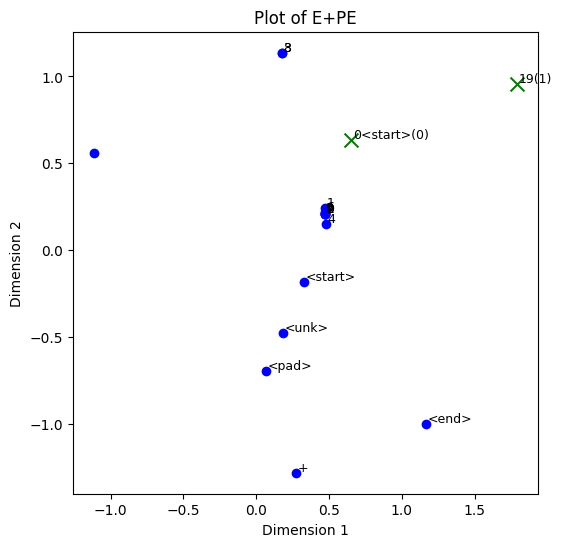

SelfAttention Layer
QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 2, 4])
WV.shape: torch.Size([1, 2, 4])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 4])
[[[-5.280786   2.8018124 -2.1445253  6.381139 ]]

 [[-4.9011827  2.5406063 -1.9429511  5.9274035]]]
(2, 1, 4)
[[-5.280786   2.8018124]
 [-4.9011827  2.5406063]]


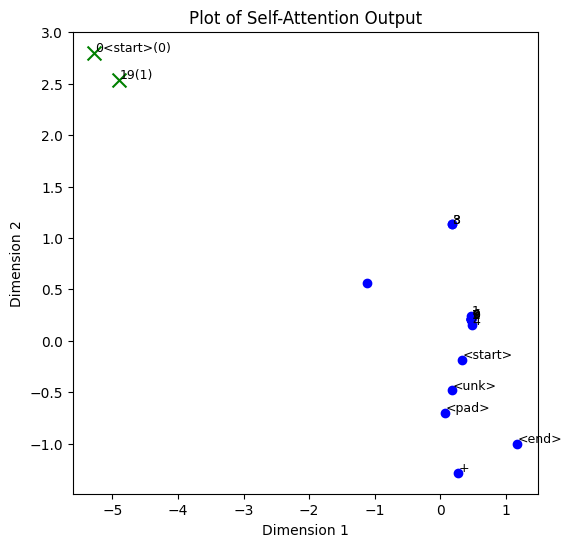

[[[-2.697282   0.6332852 -0.9174916  1.2978517]]

 [[-1.7308633  0.5658241 -1.4808389  1.3499546]]]
(2, 1, 4)
[[-2.697282   0.6332852]
 [-1.7308633  0.5658241]]


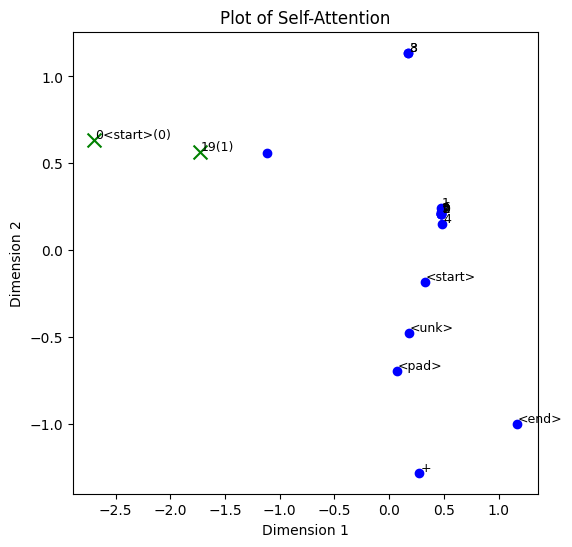

QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 2, 15])
AV.shape: torch.Size([1, 2, 4])
After Attention: tensor([[[ 1.1184,  3.6091, -4.2802, -0.5697]],

        [[-3.3043,  4.2071,  2.4525, -1.0367]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[ 2.5153718  -0.62165296 -1.6617641  -2.9171236 ]]

 [[-1.6651624   3.1648674   3.6528442  -3.3325388 ]]]
(2, 1, 4)
[[ 2.5153718  -0.62165296]
 [-1.6651624   3.1648674 ]]


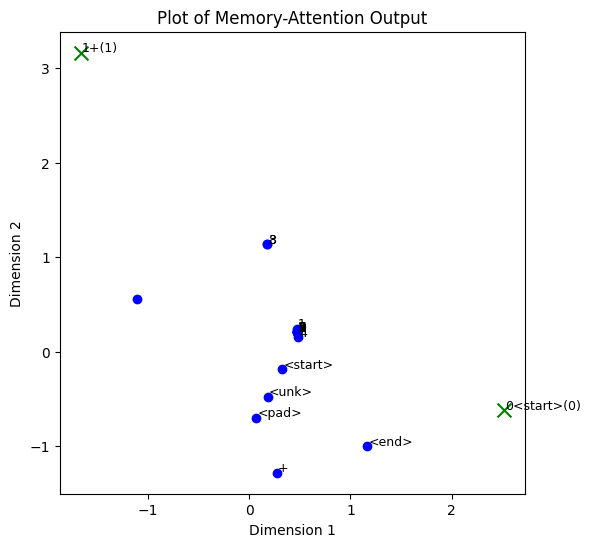

[[[ 1.1183617  3.6091225 -4.280215  -0.5696862]]

 [[-3.3042922  4.2071075  2.4524758 -1.0367483]]]
(2, 1, 4)
[[ 1.1183617  3.6091225]
 [-3.3042922  4.2071075]]


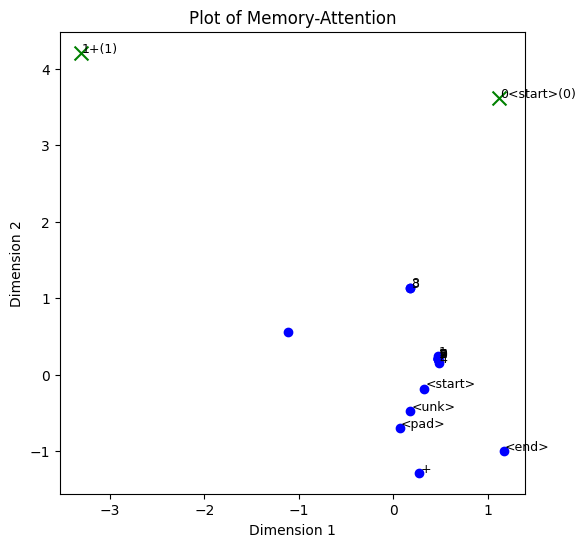

output.shape: torch.Size([1, 16])
output: tensor([[-4.1655, -3.9883, -4.1680,  2.6772, -4.6276, -4.1569, -4.1291, -4.1770,  2.6825, -4.1768,
         -1.5157, -2.2300, -1.4486, -2.8883, -6.1387,  8.9110]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 2
ys: tensor([[12],
        [ 9],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]]], device='cuda:0')
now tgt: 9 
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]]], device='cuda:0')
[[[ 0.32679498 -0.18391529 -0.07188573 -0.5606752 ]]

 [[ 0.47366697  0.20872964 -1.3899497   0.07807771]]

 [[-1.1135045   0.5614098   0.97704434 -0.45674148]]]
(3, 1, 4)
[[ 0.32679498 -0.18391529]
 [ 0.47366697  0.20872964]
 [-1.1135045   0.5614098 ]]


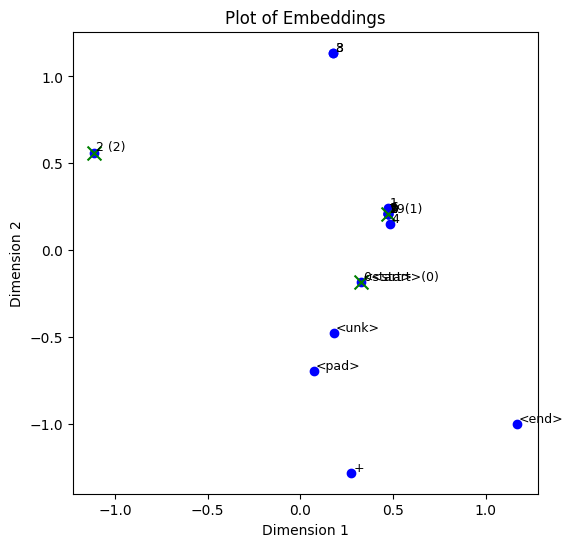

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]]
(3, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]]


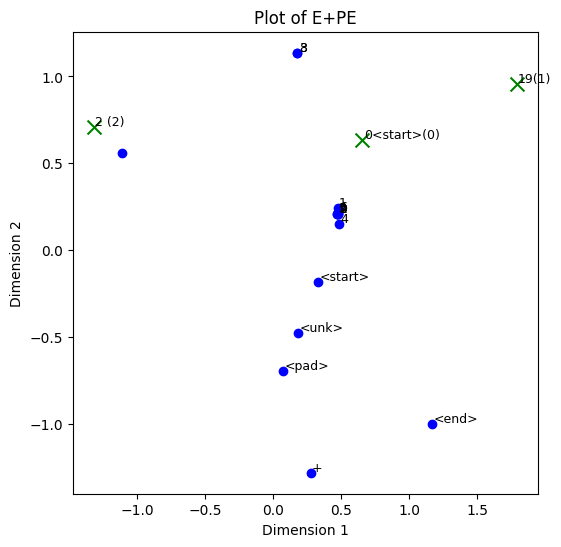

SelfAttention Layer
QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 3, 4])
WV.shape: torch.Size([1, 3, 4])
attn_weight.shape: torch.Size([1, 3, 3])
AV.shape: torch.Size([1, 3, 4])
[[[-5.0414386  2.6484334 -2.0684464  6.122261 ]]

 [[-4.4105783  2.2272034 -1.7914575  5.39914  ]]

 [[-4.8219485  2.500747  -1.9669749  5.867951 ]]]
(3, 1, 4)
[[-5.0414386  2.6484334]
 [-4.4105783  2.2272034]
 [-4.8219485  2.500747 ]]


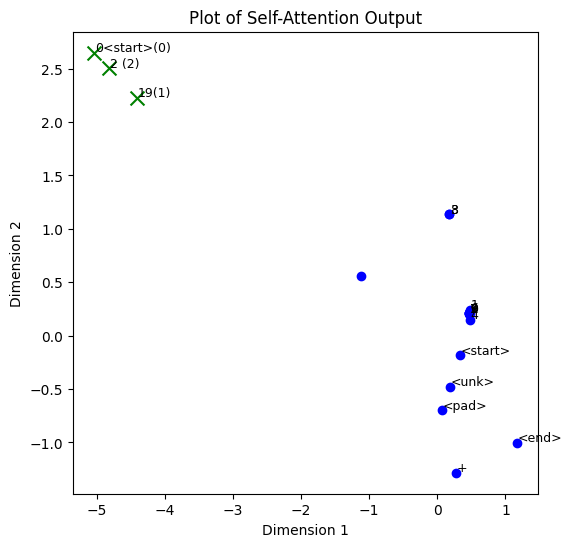

[[[-2.6826105   0.6305782  -0.92743164  1.3008991 ]]

 [[-1.601573    0.54764146 -1.538909    1.3494622 ]]

 [[-3.3854766   0.5055533  -0.25006947  1.1697193 ]]]
(3, 1, 4)
[[-2.6826105   0.6305782 ]
 [-1.601573    0.54764146]
 [-3.3854766   0.5055533 ]]


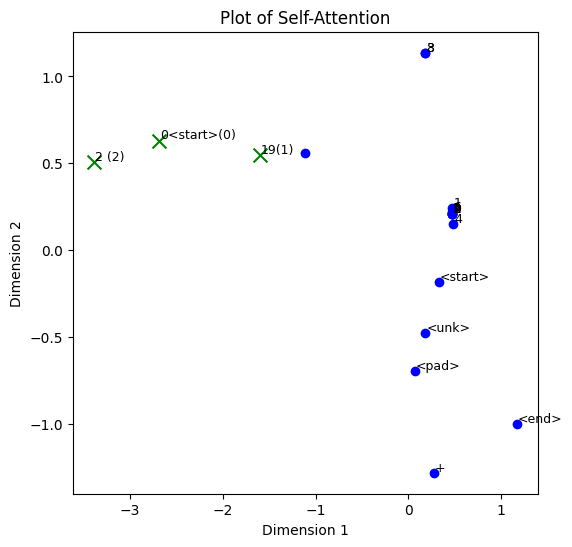

QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 3, 15])
AV.shape: torch.Size([1, 3, 4])
After Attention: tensor([[[ 1.1025,  3.6306, -4.2768, -0.5712]],

        [[-3.2673,  4.2369,  2.4270, -1.0757]],

        [[ 0.9175,  3.9256, -4.1133, -0.6975]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[ 2.4853904 -0.6209806 -1.6336578 -2.9137514]]

 [[-1.678051   3.1729171  3.6727078 -3.3410487]]

 [[ 2.9303756 -0.6154781 -2.1173708 -2.8226907]]]
(3, 1, 4)
[[ 2.4853904 -0.6209806]
 [-1.678051   3.1729171]
 [ 2.9303756 -0.6154781]]


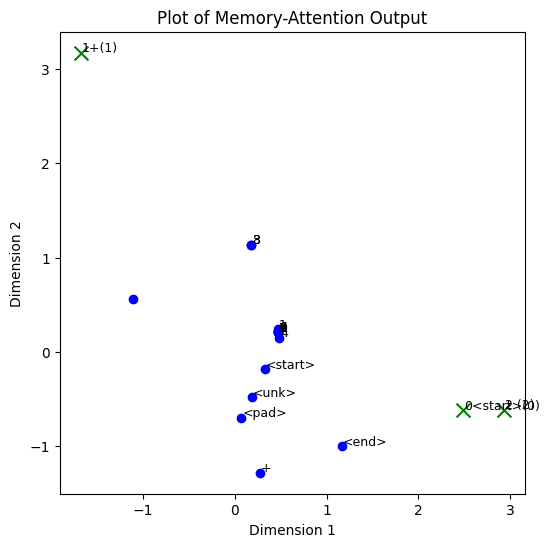

[[[ 1.1025352   3.630587   -4.2768455  -0.5712219 ]]

 [[-3.2673438   4.2368684   2.4269564  -1.0756505 ]]

 [[ 0.9175493   3.925633   -4.113251   -0.69747204]]]
(3, 1, 4)
[[ 1.1025352  3.630587 ]
 [-3.2673438  4.2368684]
 [ 0.9175493  3.925633 ]]


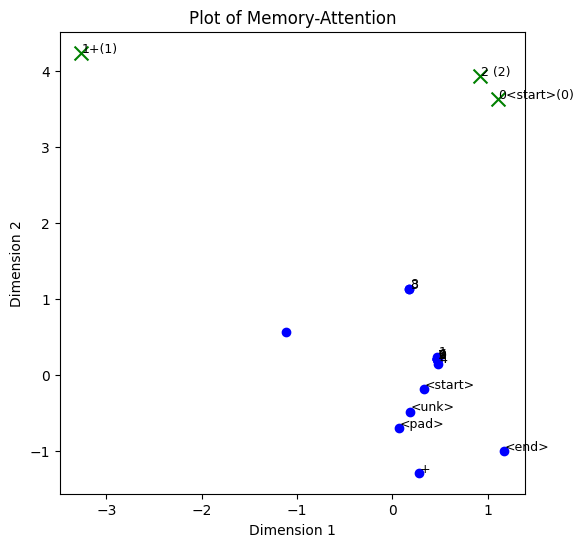

output.shape: torch.Size([1, 16])
output: tensor([[ 6.9113,  6.9668,  6.9131,  4.7565,  4.8634,  6.9169,  6.9221,  6.9000,  4.7585,  6.9168,
         -1.3993, -1.7626,  0.2646, -8.9943, -8.3561, -2.5181]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 3
ys: tensor([[12],
        [ 9],
        [15],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]]], device='cuda:0')
now tgt: 9 1
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]]], device='cuda:0')
[[[ 0.32679498 -0.18391529 -0.07188573 -0.5606752 ]]

 [[ 0.47366697  0.20872964 -1.3899497   0.07807771]]

 [[-1.1135045   0.5614098   0.97704434 -0.45674148]]

 [[ 

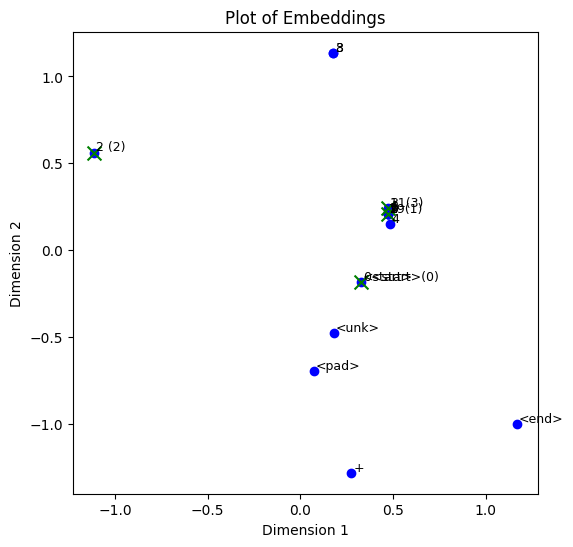

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]]
(4, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]]


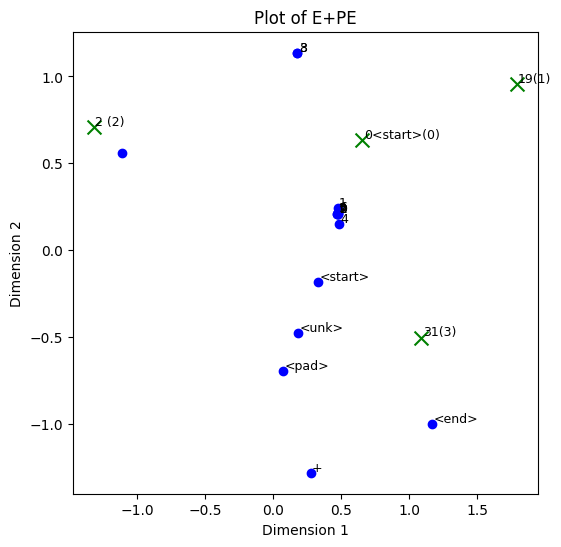

SelfAttention Layer
QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 4, 4])
WV.shape: torch.Size([1, 4, 4])
attn_weight.shape: torch.Size([1, 4, 4])
AV.shape: torch.Size([1, 4, 4])
[[[-5.105231   2.6671898 -2.377005   6.2920384]]

 [[-4.6473765  2.3571603 -2.2267783  5.784726 ]]

 [[-4.931481   2.5506752 -2.292115   6.0891557]]

 [[-3.1136868  1.3452755 -1.6972468  4.0913196]]]
(4, 1, 4)
[[-5.105231   2.6671898]
 [-4.6473765  2.3571603]
 [-4.931481   2.5506752]
 [-3.1136868  1.3452755]]


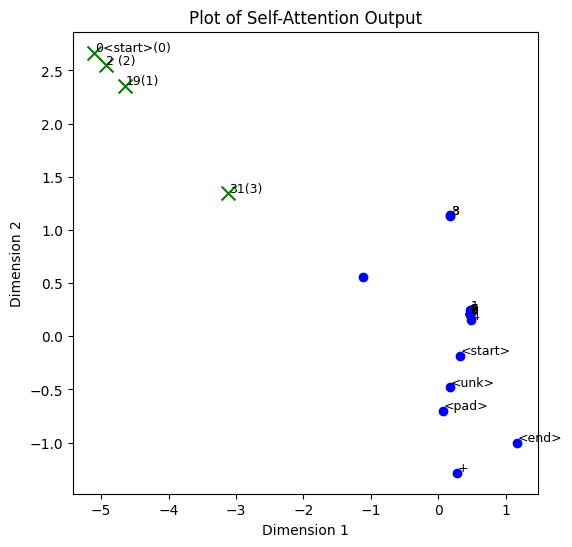

[[[-2.6083496   0.6243114  -0.9787577   1.3120306 ]]

 [[-1.5851336   0.54371357 -1.5456657   1.3500093 ]]

 [[-3.3234935   0.5122358  -0.32300377  1.1947521 ]]

 [[-1.169005    0.07796591 -1.5799354   1.5063405 ]]]
(4, 1, 4)
[[-2.6083496   0.6243114 ]
 [-1.5851336   0.54371357]
 [-3.3234935   0.5122358 ]
 [-1.169005    0.07796591]]


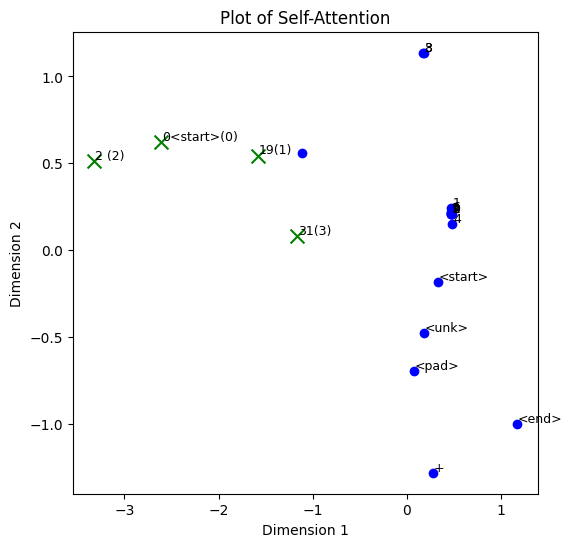

QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 4, 15])
AV.shape: torch.Size([1, 4, 4])
After Attention: tensor([[[ 0.9823,  3.7840, -4.2572, -0.5725]],

        [[-3.2629,  4.2401,  2.4242, -1.0803]],

        [[ 0.9791,  3.8204, -4.1924, -0.6351]],

        [[-3.2368,  4.0918,  2.6452, -1.1453]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[ 2.3189316  -0.61194146 -1.4822289  -2.8837707 ]]

 [[-1.6787211   3.1725345   3.6735663  -3.3414567 ]]

 [[ 2.9255     -0.61226076 -2.107236   -2.8324196 ]]

 [[-1.6914971   3.1423364   3.6826465  -3.3429575 ]]]
(4, 1, 4)
[[ 2.3189316  -0.61194146]
 [-1.6787211   3.1725345 ]
 [ 2.9255     -0.61226076]
 [-1.6914971   3.1423364 ]]


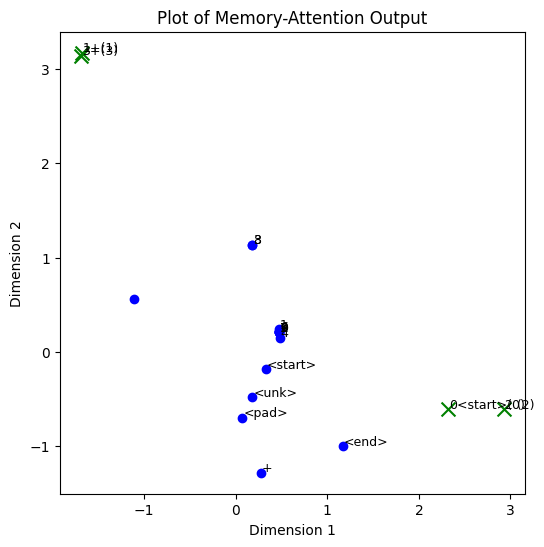

[[[ 0.9822513  3.7839549 -4.257247  -0.572525 ]]

 [[-3.262931   4.2401133  2.4242399 -1.0802983]]

 [[ 0.9791211  3.8203986 -4.192404  -0.6350889]]

 [[-3.2367878  4.0917616  2.6452088 -1.1453238]]]
(4, 1, 4)
[[ 0.9822513  3.7839549]
 [-3.262931   4.2401133]
 [ 0.9791211  3.8203986]
 [-3.2367878  4.0917616]]


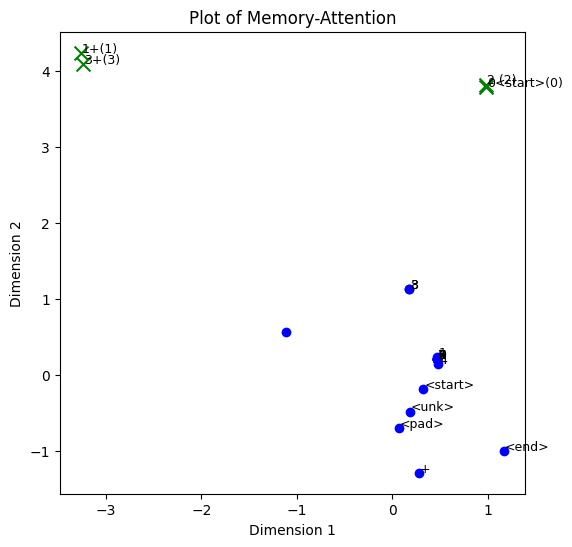

output.shape: torch.Size([1, 16])
output: tensor([[-4.4338, -4.2576, -4.4369,  2.4123, -4.9268, -4.4257, -4.3978, -4.4456,  2.4176, -4.4452,
         -1.3376, -2.0426, -1.3583, -2.2586, -5.9954,  9.0089]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 4
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]]], device='cuda:0')
now tgt: 9 1 
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]]], device='cuda:0')
[[[ 0.32679498 -0.18391529 -0.07188573 -0.5606752 ]]

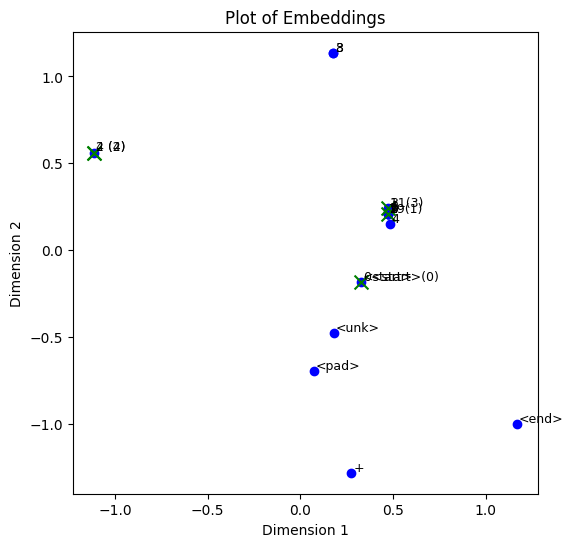

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]

 [[-2.9838116   0.46917593  1.994078    0.08571714]]]
(5, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]
 [-2.9838116   0.46917593]]


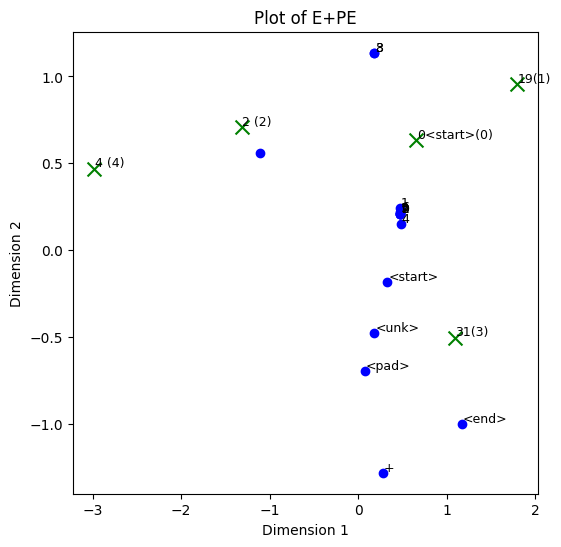

SelfAttention Layer
QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 5, 4])
WV.shape: torch.Size([1, 5, 4])
attn_weight.shape: torch.Size([1, 5, 5])
AV.shape: torch.Size([1, 5, 4])
[[[-5.0796804   2.6509638  -2.3706703   6.2651343 ]]

 [[-4.5834146   2.3166804  -2.2111838   5.7175574 ]]

 [[-4.903579    2.532975   -2.285324    6.059837  ]]

 [[-2.3246493   0.850338   -1.5215837   3.2716196 ]]

 [[ 2.5546856  -2.2303343  -0.16147666 -1.9126176 ]]]
(5, 1, 4)
[[-5.0796804  2.6509638]
 [-4.5834146  2.3166804]
 [-4.903579   2.532975 ]
 [-2.3246493  0.850338 ]
 [ 2.5546856 -2.2303343]]


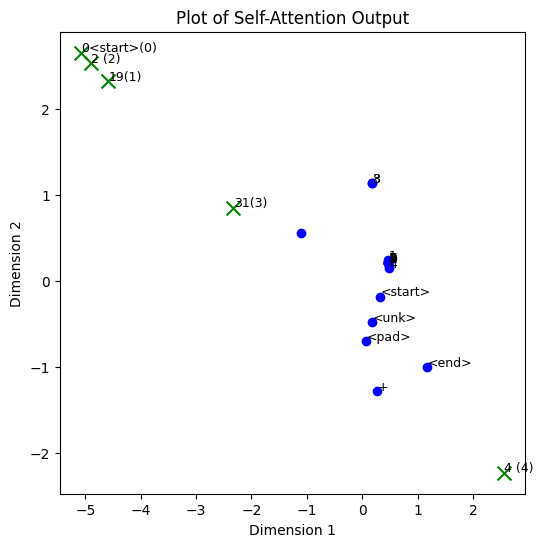

[[[-2.6058617   0.62397164 -0.9804091   1.3124381 ]]

 [[-1.5667262   0.54110503 -1.5536469   1.3497254 ]]

 [[-3.3244584   0.5113989  -0.32161635  1.1946647 ]]

 [[-0.7249003  -0.05826673 -1.7050107   1.4961251 ]]

 [[ 0.2130227  -1.5261456   2.0272293  -0.89134485]]]
(5, 1, 4)
[[-2.6058617   0.62397164]
 [-1.5667262   0.54110503]
 [-3.3244584   0.5113989 ]
 [-0.7249003  -0.05826673]
 [ 0.2130227  -1.5261456 ]]


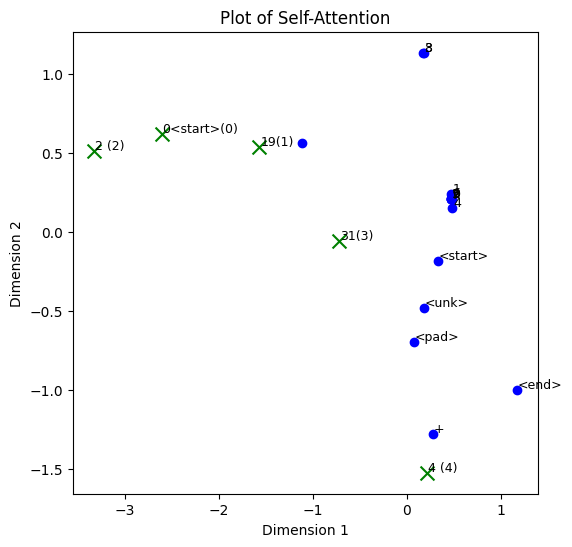

QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 5, 15])
AV.shape: torch.Size([1, 5, 4])
After Attention: tensor([[[ 0.9771,  3.7901, -4.2567, -0.5722]],

        [[-3.2575,  4.2447,  2.4200, -1.0859]],

        [[ 0.9789,  3.8210, -4.1918, -0.6357]],

        [[-3.0831,  4.1355,  2.6328, -1.3128]],

        [[-1.3408, -3.0976, -0.1553,  3.6586]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[ 2.3128417  -0.61147714 -1.4768053  -2.8823903 ]]

 [[-1.6793672   3.172023    3.6743617  -3.3418422 ]]

 [[ 2.9255803  -0.61230505 -2.1073945  -2.8322732 ]]

 [[-1.6998706   3.1138651   3.6851418  -3.3398387 ]]

 [[-2.4108992  -5.49867    -3.2412252   8.914701  ]]]
(5, 1, 4)
[[ 2.3128417  -0.61147714]
 [-1.6793672   3.172023  ]
 [ 2.9255803  -0.61230505]
 [-1.6998706   3.1138651 ]
 [-2.4108992  -5.49867   ]]


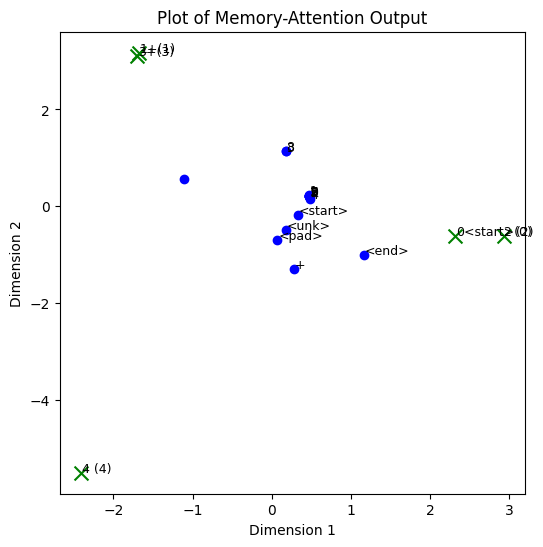

[[[ 0.9771308   3.7901108  -4.256657   -0.57217556]]

 [[-3.2574592   4.2447205   2.4199781  -1.0858883 ]]

 [[ 0.97890115  3.8209612  -4.1917586  -0.6356682 ]]

 [[-3.0830555   4.135503    2.6328213  -1.3127564 ]]

 [[-1.3407905  -3.0975533  -0.15530676  3.6585567 ]]]
(5, 1, 4)
[[ 0.9771308   3.7901108 ]
 [-3.2574592   4.2447205 ]
 [ 0.97890115  3.8209612 ]
 [-3.0830555   4.135503  ]
 [-1.3407905  -3.0975533 ]]


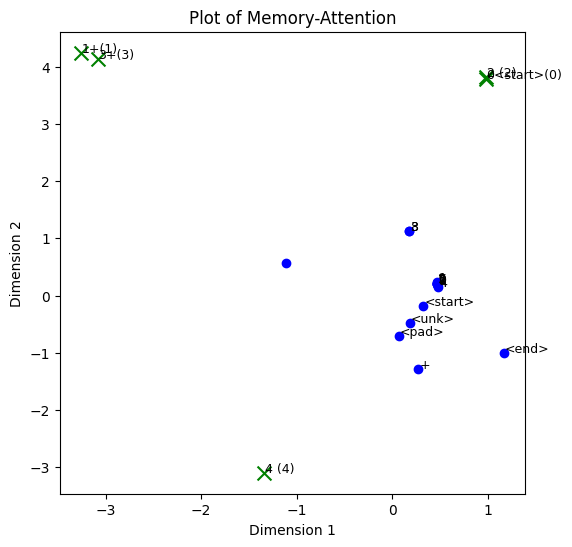

output.shape: torch.Size([1, 16])
output: tensor([[-0.7807, -0.8700, -0.7696, -0.1108,  2.5510, -0.7796, -0.7942, -0.7571, -0.1161, -0.7801,
         -2.0150, -1.6747, -1.9086, -2.5546,  8.4445, -2.0688]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 5
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]]], device='cuda:0')
now tgt: 9 1 +
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

     

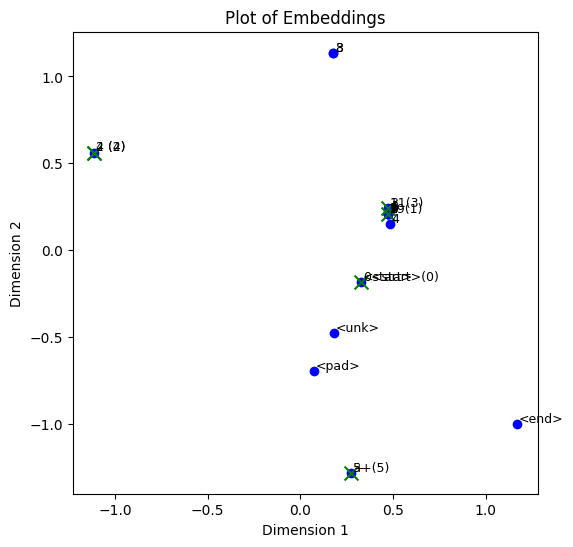

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]

 [[-2.9838116   0.46917593  1.994078    0.08571714]]

 [[-0.4091825  -2.2829523   1.3284073   3.6977143 ]]]
(6, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]
 [-2.9838116   0.46917593]
 [-0.4091825  -2.2829523 ]]


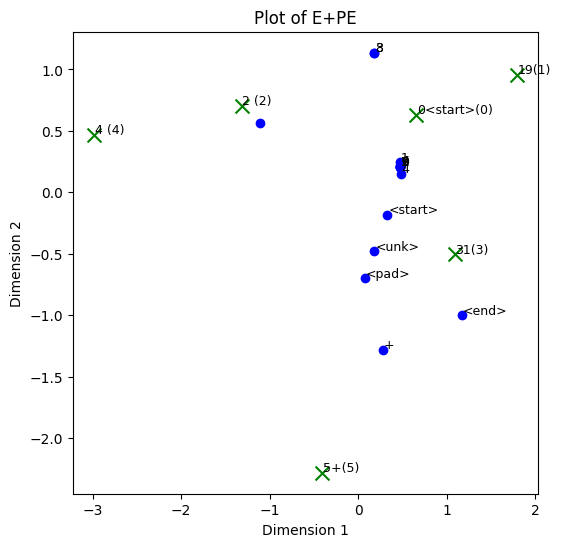

SelfAttention Layer
QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 6, 4])
WV.shape: torch.Size([1, 6, 4])
attn_weight.shape: torch.Size([1, 6, 6])
AV.shape: torch.Size([1, 6, 4])
[[[-2.2015784   0.9834417  -3.0297918   3.9092703 ]]

 [[-0.18288372 -0.21172962 -3.3426936   2.1795497 ]]

 [[-0.8226103   0.17502359 -3.2710307   2.744239  ]]

 [[-0.9777792   0.10691342 -2.0974138   2.3025389 ]]

 [[ 2.7236526  -2.298184   -0.45976162 -1.9244179 ]]

 [[ 0.30828348 -0.4246485  -3.7833998   1.9574076 ]]]
(6, 1, 4)
[[-2.2015784   0.9834417 ]
 [-0.18288372 -0.21172962]
 [-0.8226103   0.17502359]
 [-0.9777792   0.10691342]
 [ 2.7236526  -2.298184  ]
 [ 0.30828348 -0.4246485 ]]


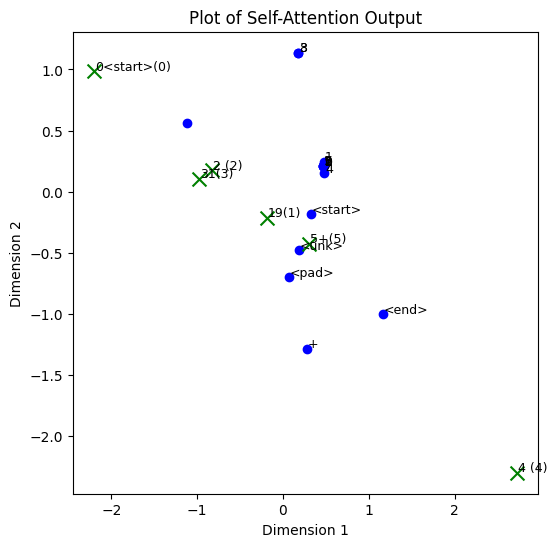

[[[-1.3821101   0.4904461  -1.6241697   1.3561037 ]]

 [[ 1.1021148   0.04867437 -2.186317    0.9701524 ]]

 [[-2.5098462   0.31982613 -0.94160473  1.4462353 ]]

 [[ 0.42863634 -0.29996392 -1.958354    1.3358698 ]]

 [[ 0.58082896 -1.6250479   1.9382745  -0.92097604]]

 [[-0.09540372 -1.5468343  -1.011114    1.6776407 ]]]
(6, 1, 4)
[[-1.3821101   0.4904461 ]
 [ 1.1021148   0.04867437]
 [-2.5098462   0.31982613]
 [ 0.42863634 -0.29996392]
 [ 0.58082896 -1.6250479 ]
 [-0.09540372 -1.5468343 ]]


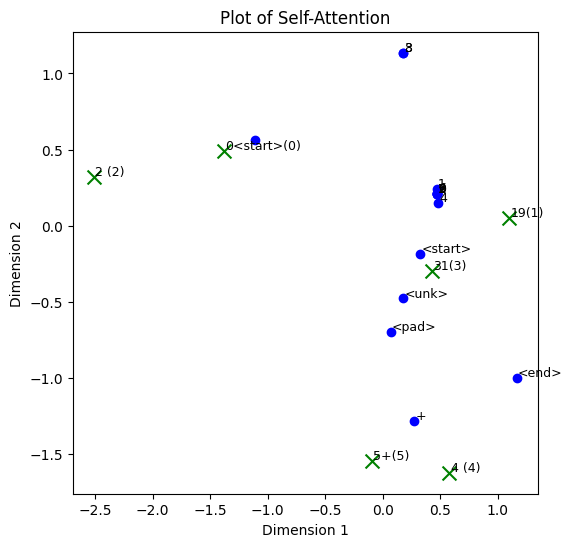

QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 6, 15])
AV.shape: torch.Size([1, 6, 4])
After Attention: tensor([[[-3.2065,  4.2775,  2.3933, -1.1394]],

        [[-1.7827,  4.3886,  1.9416, -2.2792]],

        [[ 0.9027,  3.7999, -4.3845, -0.4272]],

        [[-2.4358,  4.1914,  2.5296, -1.8992]],

        [[-1.2085, -3.1817, -0.2243,  3.6332]],

        [[-2.9581,  2.3033,  4.4622, -1.3585]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[-1.6843101  3.1638951  3.679298  -3.3441107]]

 [[-1.723986   2.9038386  3.6370513 -3.2594953]]

 [[ 1.9757808 -0.6046694 -1.1675504 -2.830966 ]]

 [[-1.7168082  2.9957256  3.664106  -3.2999055]]

 [[-2.4157915 -5.5309343 -3.2418098  8.915276 ]]

 [[-1.724614   2.7880087  3.5865178 -3.1924322]]]
(6, 1, 4)
[[-1.6843101  3.1638951]
 [-1.723986   2.9038386]
 [ 1.9757808 -0.6046694]
 [-1.7168082  2.9957256]
 [-2.4157915 -5.5309343]
 [-1.724614   2.788008

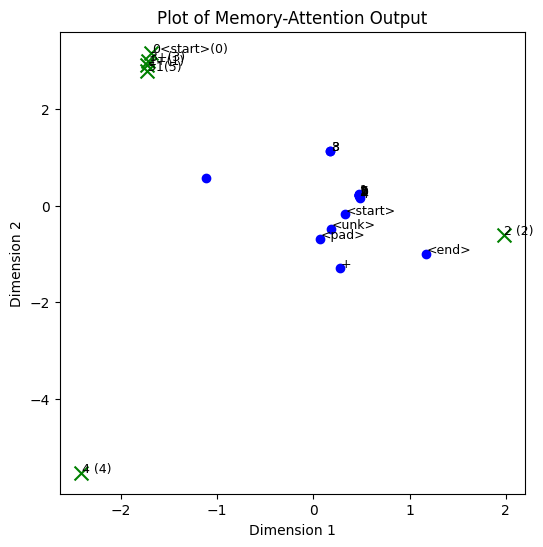

[[[-3.2065191   4.277549    2.3933182  -1.1394072 ]]

 [[-1.7826995   4.388563    1.9415597  -2.2791526 ]]

 [[ 0.90270257  3.7998621  -4.3845134  -0.42715552]]

 [[-2.435803    4.1913548   2.5296335  -1.8991752 ]]

 [[-1.2084904  -3.181729   -0.22429432  3.6332357 ]]

 [[-2.9581115   2.303338    4.4622254  -1.3585016 ]]]
(6, 1, 4)
[[-3.2065191   4.277549  ]
 [-1.7826995   4.388563  ]
 [ 0.90270257  3.7998621 ]
 [-2.435803    4.1913548 ]
 [-1.2084904  -3.181729  ]
 [-2.9581115   2.303338  ]]


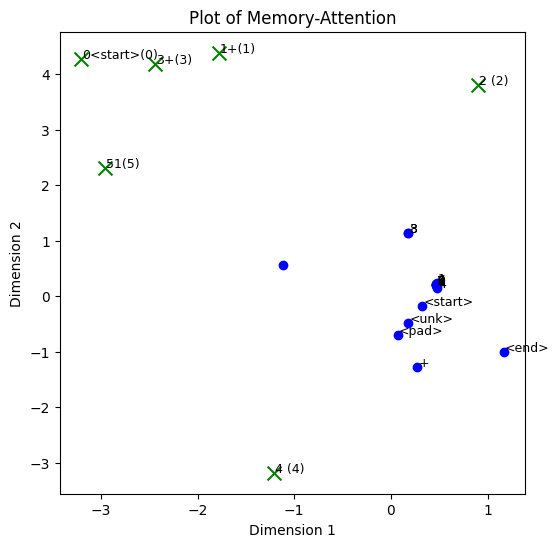

output.shape: torch.Size([1, 16])
output: tensor([[-7.2159, -7.0681, -7.2219, -0.1444, -7.2518, -7.2116, -7.1863, -7.2256, -0.1394, -7.2287,
         -0.1070, -0.6431, -0.9494,  3.1130, -2.7499,  9.5673]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 6
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]]], device='cuda:0')
now tgt: 9 1 + 
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1

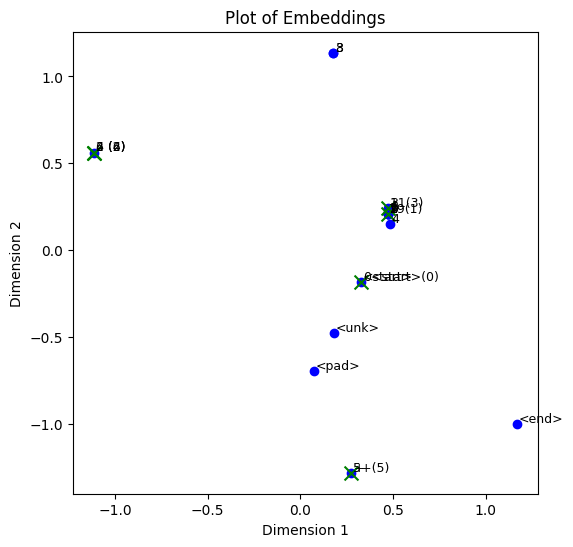

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]

 [[-2.9838116   0.46917593  1.994078    0.08571714]]

 [[-0.4091825  -2.2829523   1.3284073   3.6977143 ]]

 [[-2.5064244   2.0829897   2.0140526   0.08471757]]]
(7, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]
 [-2.9838116   0.46917593]
 [-0.4091825  -2.2829523 ]
 [-2.5064244   2.0829897 ]]


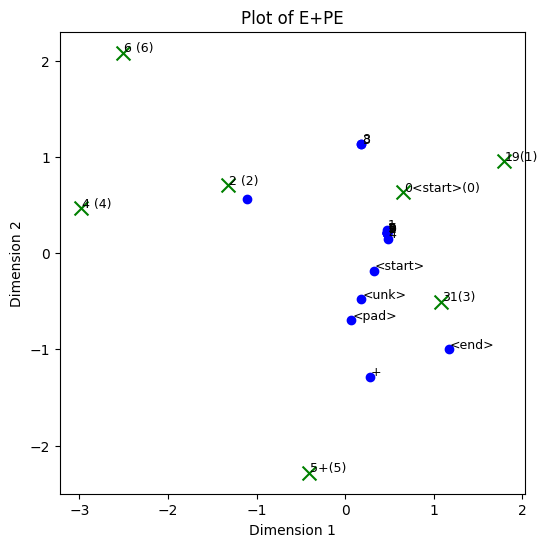

SelfAttention Layer
QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 7, 4])
WV.shape: torch.Size([1, 7, 4])
attn_weight.shape: torch.Size([1, 7, 7])
AV.shape: torch.Size([1, 7, 4])
[[[-2.1735816   0.9657202  -3.0110188   3.8749568 ]]

 [[-0.15636073 -0.2290903  -3.3133676   2.141887  ]]

 [[-0.80374604  0.16281083 -3.2534606   2.7189028 ]]

 [[-0.6022951  -0.1224885  -1.8547119   1.8510112 ]]

 [[ 2.9621906  -2.4067874  -0.11054067 -2.2691665 ]]

 [[ 0.30828348 -0.42464843 -3.7833989   1.957407  ]]

 [[ 2.0203803  -1.6610894  -2.0897107  -0.4574006 ]]]
(7, 1, 4)
[[-2.1735816   0.9657202 ]
 [-0.15636073 -0.2290903 ]
 [-0.80374604  0.16281083]
 [-0.6022951  -0.1224885 ]
 [ 2.9621906  -2.4067874 ]
 [ 0.30828348 -0.42464843]
 [ 2.0203803  -1.6610894 ]]


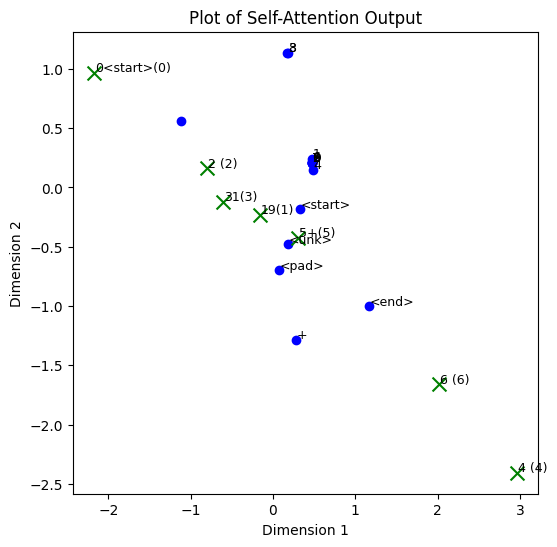

[[[-1.3704145   0.48846772 -1.628784    1.3557802 ]]

 [[ 1.1242752   0.04323711 -2.1873305   0.9645566 ]]

 [[-2.512458    0.31667277 -0.9385064   1.4471295 ]]

 [[ 0.77891356 -0.41612187 -1.9854513   1.2769362 ]]

 [[ 0.7755187  -1.5500121   1.880197   -1.0152603 ]]

 [[-0.09540372 -1.5468345  -1.0111138   1.6776407 ]]

 [[-2.2412198   2.0286877   0.15614258 -0.7201767 ]]]
(7, 1, 4)
[[-1.3704145   0.48846772]
 [ 1.1242752   0.04323711]
 [-2.512458    0.31667277]
 [ 0.77891356 -0.41612187]
 [ 0.7755187  -1.5500121 ]
 [-0.09540372 -1.5468345 ]
 [-2.2412198   2.0286877 ]]


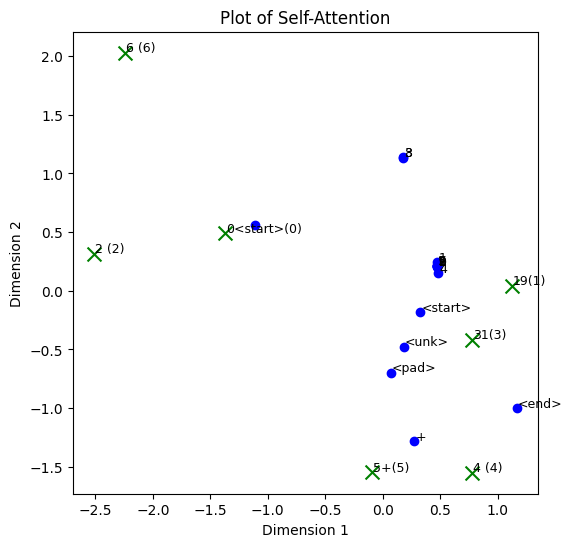

QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 7, 15])
AV.shape: torch.Size([1, 7, 4])
After Attention: tensor([[[-3.2028,  4.2802,  2.3908, -1.1432]],

        [[-1.7636,  4.3809,  1.9401, -2.2912]],

        [[ 0.9165,  3.7842, -4.3853, -0.4293]],

        [[-2.1713,  4.0951,  2.5634, -2.1069]],

        [[-1.1483, -3.2038, -0.2804,  3.6265]],

        [[-2.9581,  2.3033,  4.4622, -1.3585]],

        [[-0.7567,  4.1029, -4.7907,  1.2011]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[-1.6845726   3.1633556   3.6795273  -3.3442056 ]]

 [[-1.7243805   2.8981202   3.6352785  -3.2569067 ]]

 [[ 1.9821032  -0.60606146 -1.1725601  -2.8339834 ]]

 [[-1.7224479   2.9259038   3.643955   -3.2696495 ]]

 [[-2.417075   -5.539397   -3.2421236   8.9157915 ]]

 [[-1.7246146   2.7880087   3.5865183  -3.1924317 ]]

 [[ 1.5059583  -1.5688553  -2.3951278   0.37306017]]]
(7, 1, 4)
[[-1.6845726   3.163

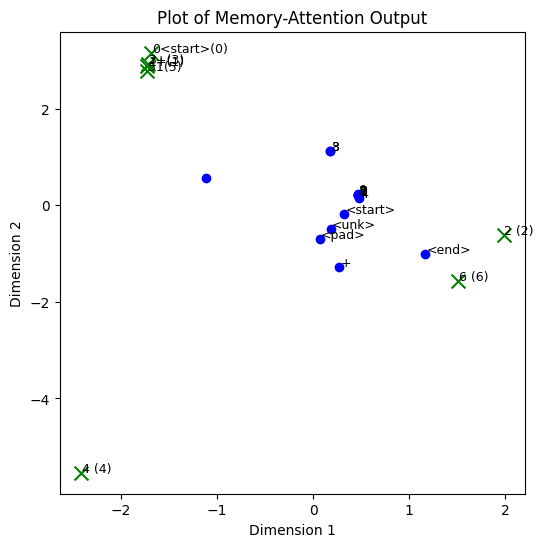

[[[-3.2027745   4.2802405   2.3908195  -1.1431869 ]]

 [[-1.7635823   4.38091     1.9400624  -2.2912042 ]]

 [[ 0.91651356  3.7842286  -4.3852835  -0.42927074]]

 [[-2.1713006   4.095076    2.5633767  -2.1068542 ]]

 [[-1.14828    -3.2038257  -0.2804044   3.626466  ]]

 [[-2.958112    2.3033369   4.462226   -1.3585008 ]]

 [[-0.7567234   4.1028605  -4.790657    1.2011228 ]]]
(7, 1, 4)
[[-3.2027745   4.2802405 ]
 [-1.7635823   4.38091   ]
 [ 0.91651356  3.7842286 ]
 [-2.1713006   4.095076  ]
 [-1.14828    -3.2038257 ]
 [-2.958112    2.3033369 ]
 [-0.7567234   4.1028605 ]]


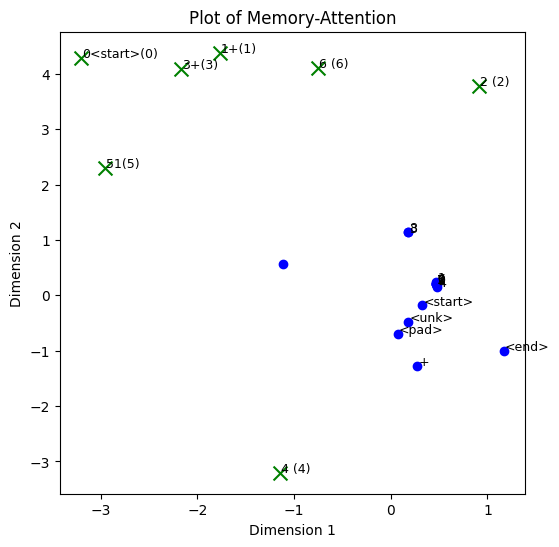

output.shape: torch.Size([1, 16])
output: tensor([[  7.2464,   7.3040,   7.2556,   6.6725,   6.6374,   7.2565,   7.2605,   7.2447,   6.6726,
           7.2505,  -3.5218,  -3.9189,  -1.3309, -14.2446,  -6.9146,  -2.0833]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 7
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]]], device='cuda:0')
now tgt: 9 1 + 1
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [

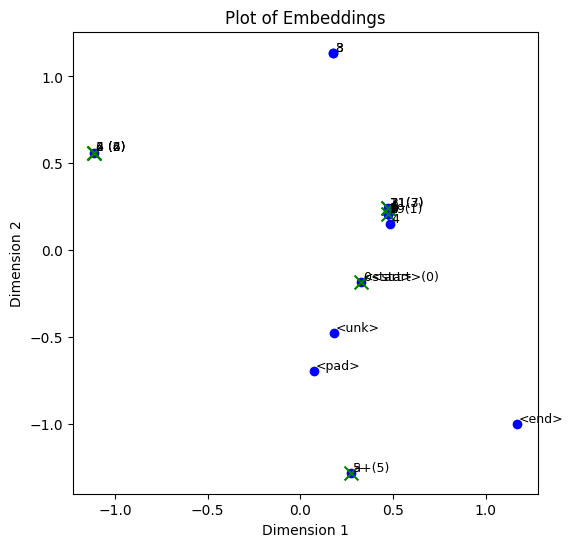

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]

 [[-2.9838116   0.46917593  1.994078    0.08571714]]

 [[-0.4091825  -2.2829523   1.3284073   3.6977143 ]]

 [[-2.5064244   2.0829897   2.0140526   0.08471757]]

 [[ 1.6027195   1.2394984  -2.6712625   1.1633432 ]]]
(8, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]
 [-2.9838116   0.46917593]
 [-0.4091825  -2.2829523 ]
 [-2.5064244   2.0829897 ]
 [ 1.6027195   1.2394984 ]]


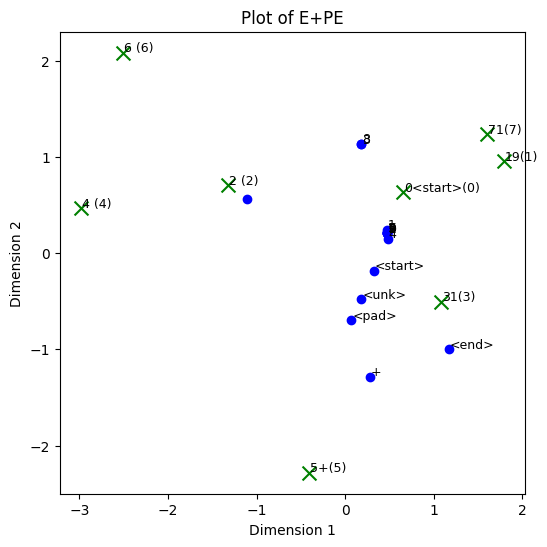

SelfAttention Layer
QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 8, 4])
WV.shape: torch.Size([1, 8, 4])
attn_weight.shape: torch.Size([1, 8, 8])
AV.shape: torch.Size([1, 8, 4])
[[[-3.2610464   1.6411195  -2.8475206   4.828111  ]]

 [[-1.336422    0.49195328 -3.1361392   3.1690447 ]]

 [[-2.038271    0.9180161  -3.0590627   3.790212  ]]

 [[-1.5123606   0.4619219  -1.9558064   2.7591717 ]]

 [[ 2.6874754  -2.23052    -0.18271415 -1.9776262 ]]

 [[-0.81874925  0.24802914 -3.5418117   2.8986619 ]]

 [[ 1.3179212  -1.2228608  -2.1212323   0.21630257]]

 [[-0.78599894  0.16272596 -3.1970594   2.6853662 ]]]
(8, 1, 4)
[[-3.2610464   1.6411195 ]
 [-1.336422    0.49195328]
 [-2.038271    0.9180161 ]
 [-1.5123606   0.4619219 ]
 [ 2.6874754  -2.23052   ]
 [-0.81874925  0.24802914]
 [ 1.3179212  -1.2228608 ]
 [-0.78599894  0.16272596]]


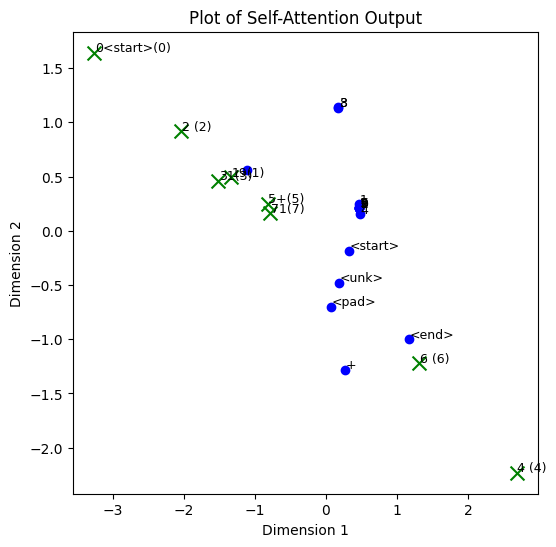

[[[-1.9856212   0.5753429  -1.3505429   1.3563514 ]]

 [[ 0.25909033  0.24098967 -2.0952663   1.1512771 ]]

 [[-2.926829    0.43689325 -0.6715578   1.34202   ]]

 [[-0.05369407 -0.17748936 -1.8808482   1.4107801 ]]

 [[ 0.3933446  -1.5297319   1.9851452  -0.93786836]]

 [[-0.8827311  -1.2458273  -0.9104601   1.7511656 ]]

 [[-3.4045289   1.4705274  -0.16200751  0.44692075]]

 [[ 0.51250285  0.25458285 -2.1487644   1.0686381 ]]]
(8, 1, 4)
[[-1.9856212   0.5753429 ]
 [ 0.25909033  0.24098967]
 [-2.926829    0.43689325]
 [-0.05369407 -0.17748936]
 [ 0.3933446  -1.5297319 ]
 [-0.8827311  -1.2458273 ]
 [-3.4045289   1.4705274 ]
 [ 0.51250285  0.25458285]]


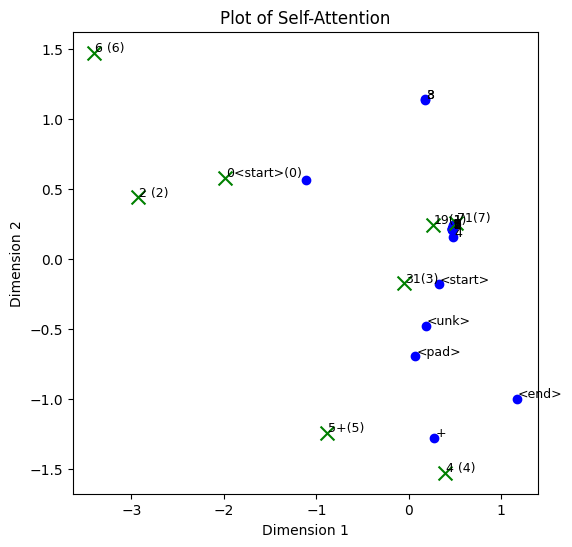

QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 8, 15])
AV.shape: torch.Size([1, 8, 4])
After Attention: tensor([[[-3.3454,  4.5141,  1.9352, -0.8766]],

        [[-2.4142,  4.5273,  2.0395, -1.8350]],

        [[ 1.3411,  3.2374, -4.3966, -0.4577]],

        [[-2.7444,  4.2195,  2.5445, -1.6347]],

        [[-1.2802, -3.1333, -0.1930,  3.6489]],

        [[-3.3150,  2.7364,  4.0487, -1.0490]],

        [[ 0.2706,  4.7742, -2.8137, -1.4764]],

        [[-2.2253,  4.5446,  1.9463, -1.9669]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[-0.8014783   2.0493474   2.2932928  -2.913895  ]]

 [[-1.7112778   3.0517046   3.6784608  -3.3225863 ]]

 [[ 2.788652   -0.62143713 -1.9300753  -2.920944  ]]

 [[-1.7098932   3.0592983   3.6793082  -3.3247402 ]]

 [[-2.4133074  -5.514353   -3.242371    8.916868  ]]

 [[-1.7052401   2.9839792   3.6373606  -3.2731087 ]]

 [[ 2.9478855  -0.6417734  -2.16321

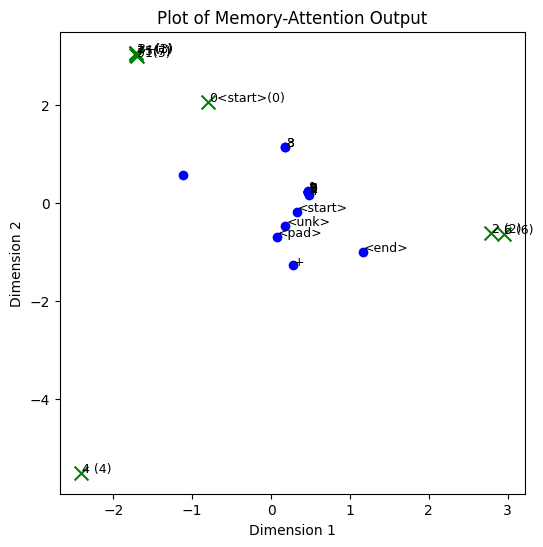

[[[-3.3453672   4.5141      1.9352375  -0.87657887]]

 [[-2.4142444   4.527301    2.0394912  -1.8350487 ]]

 [[ 1.3410896   3.237445   -4.396585   -0.45766208]]

 [[-2.744386    4.2194996   2.5445054  -1.6346649 ]]

 [[-1.2801527  -3.1333416  -0.19296815  3.6489003 ]]

 [[-3.3149896   2.736396    4.048662   -1.0489788 ]]

 [[ 0.2706228   4.774241   -2.8136528  -1.476438  ]]

 [[-2.2253494   4.544585    1.946335   -1.9669422 ]]]
(8, 1, 4)
[[-3.3453672  4.5141   ]
 [-2.4142444  4.527301 ]
 [ 1.3410896  3.237445 ]
 [-2.744386   4.2194996]
 [-1.2801527 -3.1333416]
 [-3.3149896  2.736396 ]
 [ 0.2706228  4.774241 ]
 [-2.2253494  4.544585 ]]


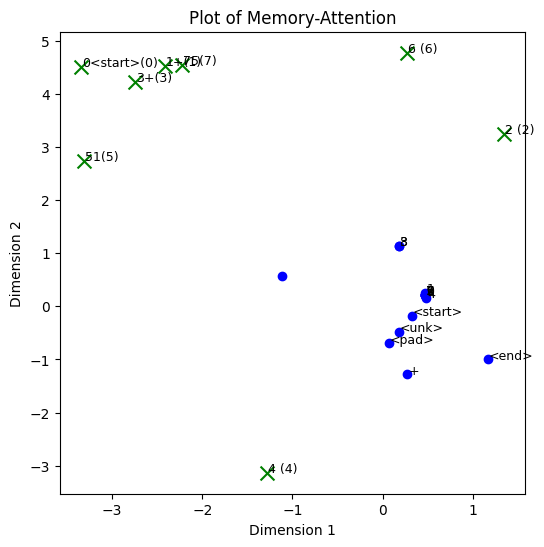

output.shape: torch.Size([1, 16])
output: tensor([[-2.9552, -2.7796, -2.9606,  2.4342, -4.3922, -2.9482, -2.9206, -2.9723,  2.4403, -2.9644,
         -0.6939, -1.4109, -0.6001, -1.8377, -7.8540,  7.8294]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 8
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]]], device='cuda:0')
now tgt: 9 1 + 1 
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [

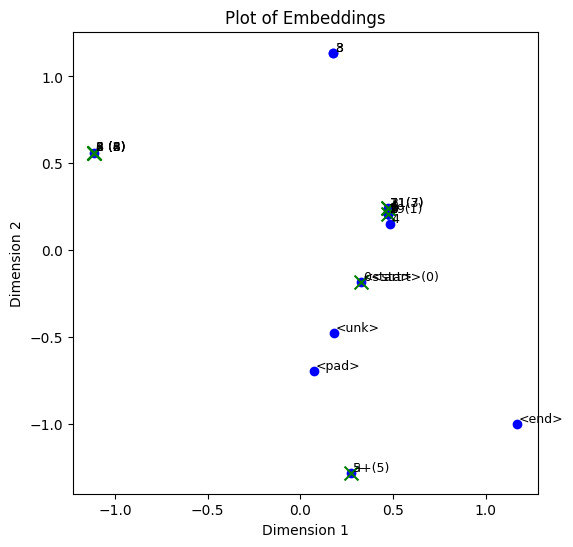

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]

 [[-2.9838116   0.46917593  1.994078    0.08571714]]

 [[-0.4091825  -2.2829523   1.3284073   3.6977143 ]]

 [[-2.5064244   2.0829897   2.0140526   0.08471757]]

 [[ 1.6027195   1.2394984  -2.6712625   1.1633432 ]]

 [[-1.2376509   0.9773195   2.0340033   0.08331871]]]
(9, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]
 [-2.9838116   0.46917593]
 [-0.4091825  -2.2829523 ]
 [-2.5064244   2.0829897 ]
 [ 1.6027195   1.2394984 ]
 [-1.2376509   0.9773195 ]]


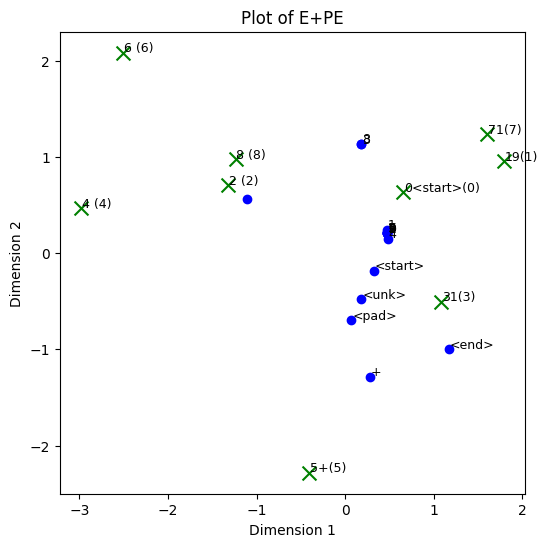

SelfAttention Layer
QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 9, 9])
AV.shape: torch.Size([1, 9, 4])
[[[-3.1746068   1.5844972  -2.8017583   4.726422  ]]

 [[-1.233052    0.42209783 -3.0562866   3.0358112 ]]

 [[-1.9556687   0.8628502  -3.0036647   3.687596  ]]

 [[-1.0807834   0.18183973 -1.7246748   2.252372  ]]

 [[ 2.864926   -2.3500197  -0.02534012 -2.2115438 ]]

 [[-0.8186906   0.24798861 -3.5417569   2.8985817 ]]

 [[ 1.6295154  -1.4424584  -1.7621096  -0.23887858]]

 [[-0.6744483   0.08635458 -3.0996573   2.536373  ]]

 [[-1.660302    0.70073986 -3.1410367   3.4801128 ]]]
(9, 1, 4)
[[-3.1746068   1.5844972 ]
 [-1.233052    0.42209783]
 [-1.9556687   0.8628502 ]
 [-1.0807834   0.18183973]
 [ 2.864926   -2.3500197 ]
 [-0.8186906   0.24798861]
 [ 1.6295154  -1.4424584 ]
 [-0.6744483   0.08635458]
 [-1.660302    0.70073986]]


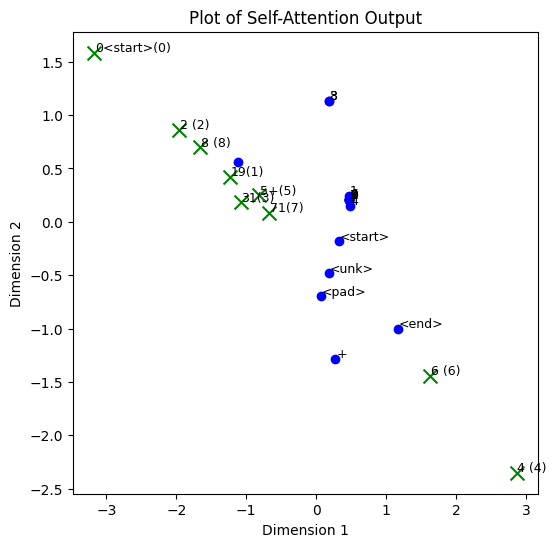

[[[-1.9671136   0.5722408  -1.3597786   1.3573565 ]]

 [[ 0.32959637  0.22548577 -2.1065466   1.1386429 ]]

 [[-2.9368355   0.42966542 -0.66029274  1.3425988 ]]

 [[ 0.30924663 -0.2989839  -1.929896    1.3671561 ]]

 [[ 0.60867065 -1.5223047   1.927787   -0.9958059 ]]

 [[-0.88270515 -1.2458541  -0.91045076  1.7511644 ]]

 [[-3.3147533   1.4861461   0.62010497 -0.226174  ]]

 [[ 0.5966673   0.23666942 -2.1595209   1.0509969 ]]

 [[-2.8443239   0.51490325 -0.7677929   1.3272852 ]]]
(9, 1, 4)
[[-1.9671136   0.5722408 ]
 [ 0.32959637  0.22548577]
 [-2.9368355   0.42966542]
 [ 0.30924663 -0.2989839 ]
 [ 0.60867065 -1.5223047 ]
 [-0.88270515 -1.2458541 ]
 [-3.3147533   1.4861461 ]
 [ 0.5966673   0.23666942]
 [-2.8443239   0.51490325]]


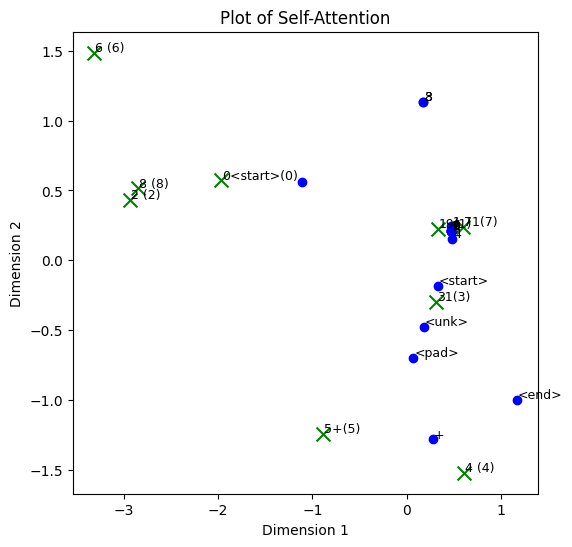

QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 9, 15])
AV.shape: torch.Size([1, 9, 4])
After Attention: tensor([[[-3.3569,  4.4091,  2.1073, -0.9040]],

        [[-2.3683,  4.5249,  2.0292, -1.8706]],

        [[ 1.3449,  3.2296, -4.3999, -0.4539]],

        [[-2.5265,  4.1804,  2.5668, -1.8292]],

        [[-1.2078, -3.1714, -0.2433,  3.6376]],

        [[-3.3150,  2.7364,  4.0487, -1.0490]],

        [[ 0.1901,  4.5892, -1.2496, -2.2659]],

        [[-2.1654,  4.5357,  1.9341, -2.0101]],

        [[ 1.2813,  3.3482, -4.3582, -0.4996]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[-1.0025953  2.3069546  2.6038725 -3.001461 ]]

 [[-1.7122517  3.043253   3.6765316 -3.3193586]]

 [[ 2.79644   -0.6207795 -1.9385952 -2.9190454]]

 [[-1.7152712  3.0112953  3.6681027 -3.3062193]]

 [[-2.415538  -5.529034  -3.2427952  8.917477 ]]

 [[-1.7052407  2.9839704  3.637358  -3.2731047]]

 [[ 2.8521

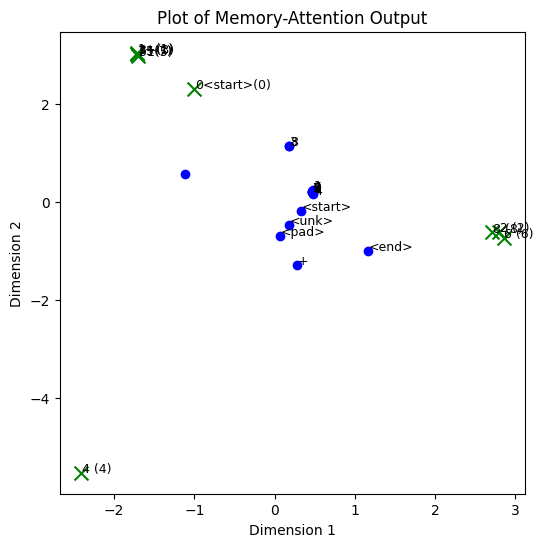

[[[-3.3569446   4.409083    2.1073203  -0.90397567]]

 [[-2.368308    4.5249205   2.0292408  -1.8705523 ]]

 [[ 1.3448954   3.2295585  -4.3999367  -0.4538534 ]]

 [[-2.5265288   4.180403    2.5667608  -1.8292253 ]]

 [[-1.2077904  -3.1713736  -0.24326183  3.637622  ]]

 [[-3.3149796   2.7363605   4.048695   -1.0489845 ]]

 [[ 0.19009893  4.5892396  -1.2496029  -2.2658758 ]]

 [[-2.1654365   4.5357304   1.9341283  -2.0101206 ]]

 [[ 1.2813321   3.3481796  -4.3582063  -0.49964848]]]
(9, 1, 4)
[[-3.3569446   4.409083  ]
 [-2.368308    4.5249205 ]
 [ 1.3448954   3.2295585 ]
 [-2.5265288   4.180403  ]
 [-1.2077904  -3.1713736 ]
 [-3.3149796   2.7363605 ]
 [ 0.19009893  4.5892396 ]
 [-2.1654365   4.5357304 ]
 [ 1.2813321   3.3481796 ]]


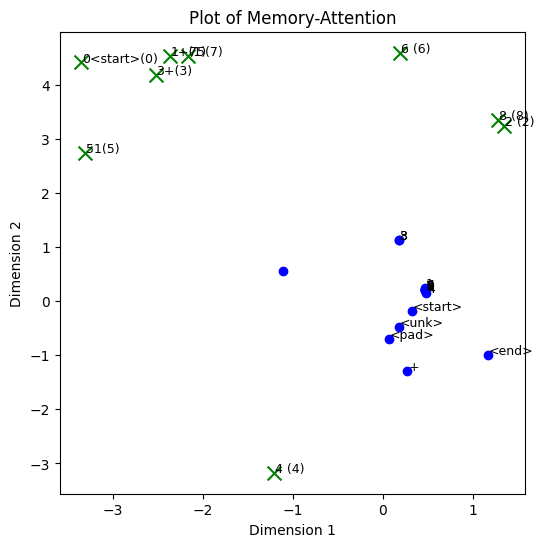

output.shape: torch.Size([1, 16])
output: tensor([[ 7.3178,  7.3508,  7.3200,  4.4096,  5.4082,  7.3223,  7.3240,  7.3083,  4.4109,  7.3245,
         -1.2500, -1.5243,  0.3964, -8.6077, -7.4046, -3.5770]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 9
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 1.3579, -0.4255, -2.6513,  1.1617]]], device='cuda:0')
now tgt: 9 1 + 1 1
tgt_em

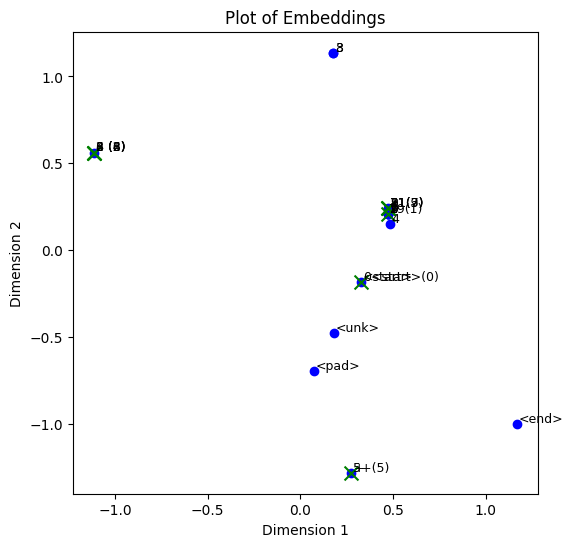

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]

 [[-2.9838116   0.46917593  1.994078    0.08571714]]

 [[-0.4091825  -2.2829523   1.3284073   3.6977143 ]]

 [[-2.5064244   2.0829897   2.0140526   0.08471757]]

 [[ 1.6027195   1.2394984  -2.6712625   1.1633432 ]]

 [[-1.2376509   0.9773195   2.0340033   0.08331871]]

 [[ 1.3578515  -0.4255342  -2.651327    1.1617448 ]]]
(10, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]
 [-2.9838116   0.46917593]
 [-0.4091825  -2.2829523 ]
 [-2.5064244   2.0829897 ]
 [ 1.6027195   1.2394984 ]
 [-1.2376509   0.9773195 ]
 [ 1.3578515  -0.4255342 ]]


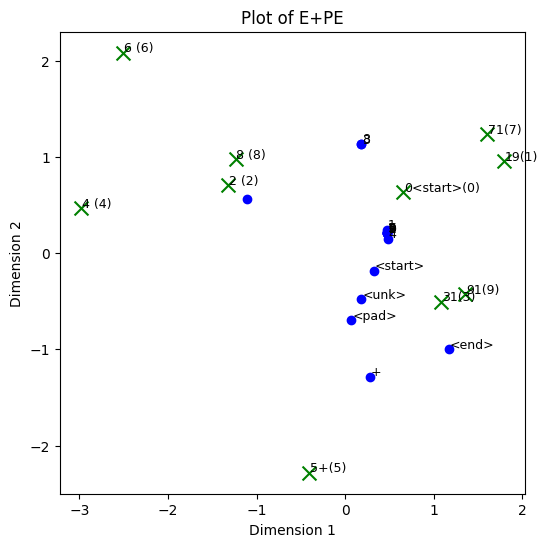

SelfAttention Layer
QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 10, 4])
WV.shape: torch.Size([1, 10, 4])
attn_weight.shape: torch.Size([1, 10, 10])
AV.shape: torch.Size([1, 10, 4])
[[[-3.44978     1.7298656  -2.8650022   4.9939437 ]]

 [[-1.7422618   0.70843124 -3.0844991   3.5058973 ]]

 [[-2.3520098   1.0815763  -3.0367696   4.055327  ]]

 [[-1.6627892   0.53069115 -1.9416075   2.8793924 ]]

 [[ 2.5894096  -2.179213   -0.13579635 -1.9074858 ]]

 [[-1.0374367   0.36808482 -3.5287812   3.0884137 ]]

 [[ 1.1340606  -1.1455024  -1.8713368   0.26402617]]

 [[-1.2212172   0.39639297 -3.1210706   3.0391912 ]]

 [[-2.0568419   0.91947746 -3.1562603   3.8406765 ]]

 [[-2.6675208   1.1925588  -2.4811394   4.0691547 ]]]
(10, 1, 4)
[[-3.44978     1.7298656 ]
 [-1.7422618   0.70843124]
 [-2.3520098   1.0815763 ]
 [-1.6627892   0.53069115]
 [ 2.5894096  -2.179213  ]
 [-1.0374367   0.36808482]
 [ 1.1340606  -1.1455024 ]
 [-1.2212172   0.39639297]
 [-2.0568419   0.91947746]
 [-2.667520

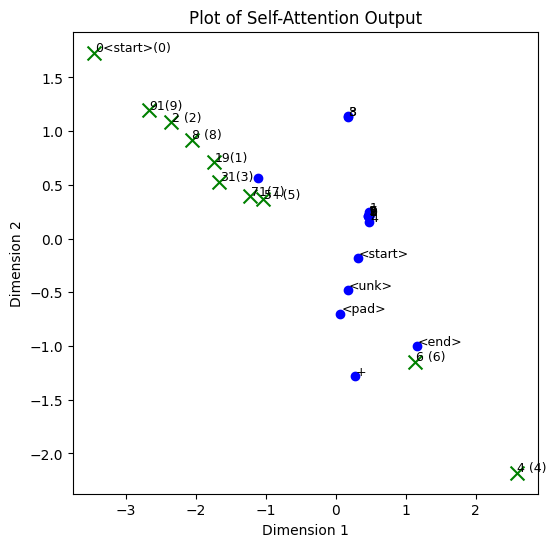

[[[-2.048816    0.5788378  -1.3165432   1.3558273 ]]

 [[-0.01212642  0.29239592 -2.044042    1.1992991 ]]

 [[-2.979745    0.4494143  -0.6314278   1.3257395 ]]

 [[-0.17111215 -0.15232459 -1.8558342   1.4273216 ]]

 [[ 0.22146739 -1.5044838   2.0249076  -0.90821016]]

 [[-1.0076195  -1.1870782  -0.8950231   1.7557057 ]]

 [[-3.6001995   1.309723    0.15807699  0.39229876]]

 [[ 0.20363794  0.31512997 -2.1003377   1.1298232 ]]

 [[-2.9080985   0.52751184 -0.7205672   1.3102708 ]]

 [[-0.67954785  0.0448372  -1.7619367   1.4499385 ]]]
(10, 1, 4)
[[-2.048816    0.5788378 ]
 [-0.01212642  0.29239592]
 [-2.979745    0.4494143 ]
 [-0.17111215 -0.15232459]
 [ 0.22146739 -1.5044838 ]
 [-1.0076195  -1.1870782 ]
 [-3.6001995   1.309723  ]
 [ 0.20363794  0.31512997]
 [-2.9080985   0.52751184]
 [-0.67954785  0.0448372 ]]


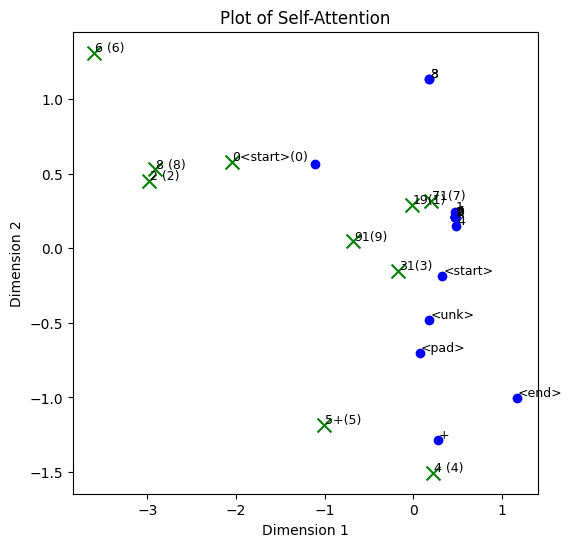

QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 10, 15])
AV.shape: torch.Size([1, 10, 4])
After Attention: tensor([[[-3.1521,  5.1246,  0.7259, -0.7046]],

        [[-2.5821,  4.5210,  2.0872, -1.7018]],

        [[ 1.3101,  3.2821, -4.3967, -0.4582]],

        [[-2.8107,  4.2136,  2.5549, -1.5744]],

        [[-1.3401, -3.0958, -0.1594,  3.6594]],

        [[-3.3562,  2.7948,  3.9843, -1.0084]],

        [[ 0.0857,  4.8961, -2.2803, -1.7205]],

        [[-2.4320,  4.5571,  1.9981, -1.8121]],

        [[ 1.2663,  3.3648, -4.3648, -0.4923]],

        [[-3.0333,  4.2235,  2.5216, -1.3487]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[ 0.02254249  1.0184059   1.0514404  -2.6007435 ]]

 [[-1.7075626   3.0796428   3.683964   -3.3325052 ]]

 [[ 2.82911    -0.6163997  -1.9759458  -2.9072402 ]]

 [[-1.7082275   3.071022    3.681422   -3.3287253 ]]

 [[-2.410876   -5.4984736  -3.2414324   8.

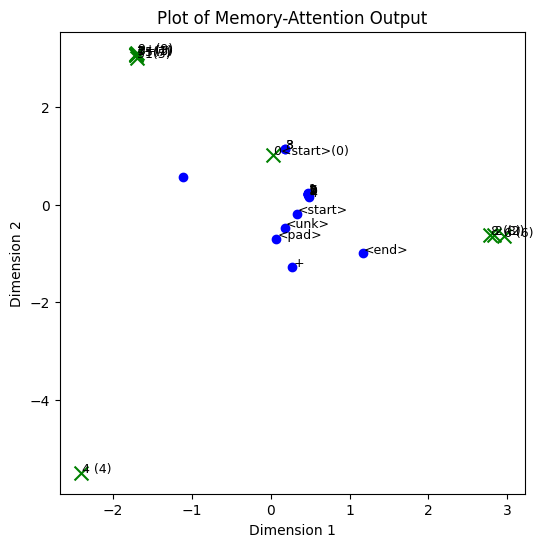

[[[-3.1520822   5.124579    0.7258898  -0.70455754]]

 [[-2.5821242   4.5210223   2.0872467  -1.7017517 ]]

 [[ 1.3101335   3.2820659  -4.3967023  -0.45819032]]

 [[-2.8106701   4.213633    2.5548725  -1.5743852 ]]

 [[-1.340132   -3.0958269  -0.15938148  3.6593513 ]]

 [[-3.356206    2.7948077   3.9843109  -1.008371  ]]

 [[ 0.08566861  4.896128   -2.2802906  -1.720468  ]]

 [[-2.4319577   4.557088    1.9981346  -1.812071  ]]

 [[ 1.2662934   3.3647692  -4.364843   -0.49232218]]

 [[-3.0332558   4.2235394   2.5215764  -1.3487364 ]]]
(10, 1, 4)
[[-3.1520822   5.124579  ]
 [-2.5821242   4.5210223 ]
 [ 1.3101335   3.2820659 ]
 [-2.8106701   4.213633  ]
 [-1.340132   -3.0958269 ]
 [-3.356206    2.7948077 ]
 [ 0.08566861  4.896128  ]
 [-2.4319577   4.557088  ]
 [ 1.2662934   3.3647692 ]
 [-3.0332558   4.2235394 ]]


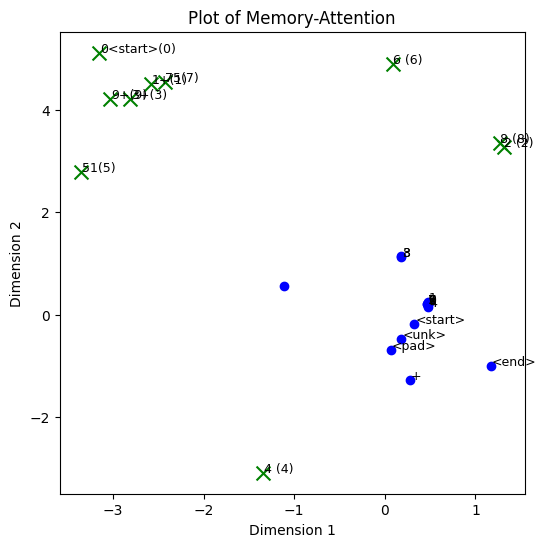

output.shape: torch.Size([1, 16])
output: tensor([[-4.1543, -3.9767, -4.1580,  2.4218, -4.8680, -4.1464, -4.1183, -4.1675,  2.4274, -4.1653,
         -1.1926, -1.9057, -1.1931, -2.1464, -6.4621,  8.8284]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 10
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15],
        [ 1],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 1.3579, -0.4255, -2.6513,  1.1617]],

        [[-2.7710,  0.2837

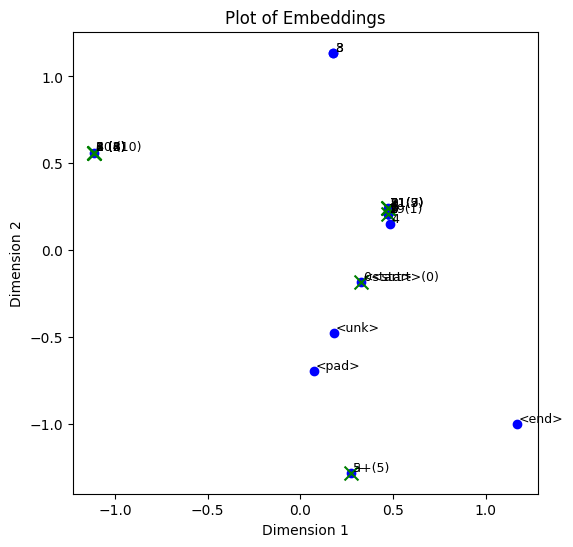

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]

 [[-2.9838116   0.46917593  1.994078    0.08571714]]

 [[-0.4091825  -2.2829523   1.3284073   3.6977143 ]]

 [[-2.5064244   2.0829897   2.0140526   0.08471757]]

 [[ 1.6027195   1.2394984  -2.6712625   1.1633432 ]]

 [[-1.2376509   0.9773195   2.0340033   0.08331871]]

 [[ 1.3578515  -0.4255342  -2.651327    1.1617448 ]]

 [[-2.7710302   0.28374803  2.0539222   0.08152121]]]
(11, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]
 [-2.9838116   0.46917593]
 [-0.4091825  -2.2829523 ]
 [-2.5064244   2.0829897 ]
 [ 1.6027195   1.2394984 ]
 [-1.2376509   0.9773195 ]
 [ 1.3578515  -0.4255342 ]
 [-2.7710302   0.28374803]]


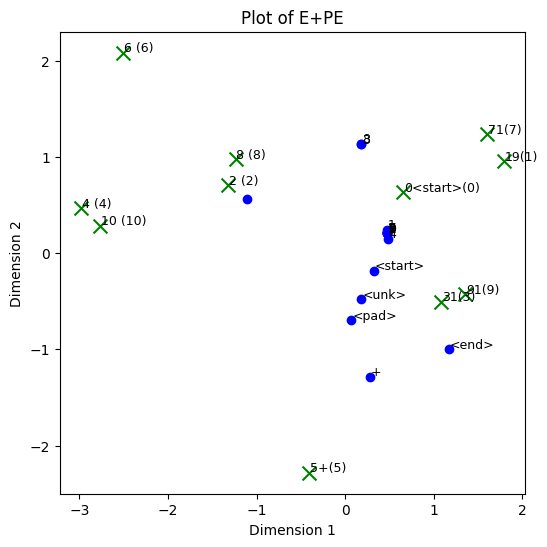

SelfAttention Layer
QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 11, 4])
WV.shape: torch.Size([1, 11, 4])
attn_weight.shape: torch.Size([1, 11, 11])
AV.shape: torch.Size([1, 11, 4])
[[[-3.43811989e+00  1.72224927e+00 -2.86074424e+00  4.98097467e+00]]

 [[-1.72173786e+00  6.94712877e-01 -3.07419610e+00  3.48170090e+00]]

 [[-2.34160948e+00  1.07467747e+00 -3.03209186e+00  4.04332590e+00]]

 [[-1.34536004e+00  3.25018913e-01 -1.83983409e+00  2.53297210e+00]]

 [[ 2.99089694e+00 -2.44927406e+00 -1.04175255e-01 -2.31353021e+00]]

 [[-1.03743672e+00  3.68084818e-01 -3.52878118e+00  3.08841348e+00]]

 [[ 1.35159874e+00 -1.29545677e+00 -1.74685931e+00 -2.31465697e-03]]

 [[-1.19620681e+00  3.79514724e-01 -3.10719371e+00  3.00905108e+00]]

 [[-2.05149889e+00  9.15905237e-01 -3.15364957e+00  3.83440757e+00]]

 [[-2.54549861e+00  1.11330974e+00 -2.43827343e+00  3.93438244e+00]]

 [[ 1.91639125e+00 -1.76000309e+00 -5.26658416e-01 -1.11262131e+00]]]
(11, 1, 4)
[[-3.43812     1.7222493

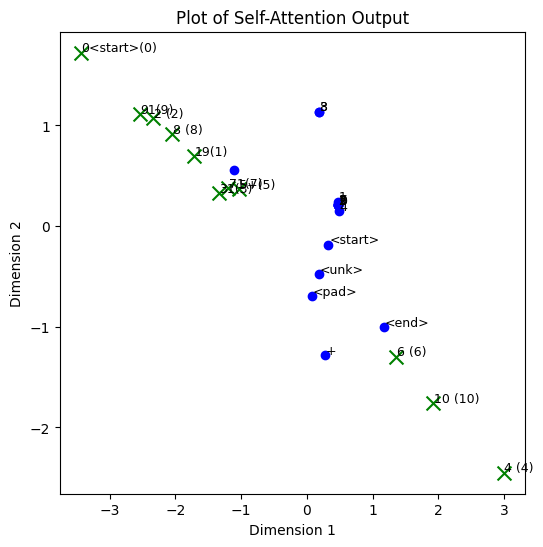

[[[-2.04602838e+00  5.78409791e-01 -1.31798494e+00  1.35599208e+00]]

 [[ 7.59676506e-04  2.89712757e-01 -2.04662561e+00  1.19730139e+00]]

 [[-2.98018789e+00  4.48669702e-01 -6.30753934e-01  1.32591724e+00]]

 [[ 8.57177153e-02 -2.31787607e-01 -1.89855671e+00  1.39835548e+00]]

 [[ 8.20410848e-01 -1.55798948e+00  1.86673939e+00 -1.01961792e+00]]

 [[-1.00761950e+00 -1.18707824e+00 -8.95023108e-01  1.75570571e+00]]

 [[-3.57040954e+00  1.35053420e+00  4.54010546e-01  1.15598135e-01]]

 [[ 2.20851362e-01  3.11664701e-01 -2.10333729e+00  1.12671435e+00]]

 [[-2.90833044e+00  5.27235150e-01 -7.20280170e-01  1.31033862e+00]]

 [[-6.12555742e-01  2.48962007e-02 -1.77855647e+00  1.44619417e+00]]

 [[-7.20497549e-01 -1.60207534e+00  2.14862871e+00 -5.09072244e-01]]]
(11, 1, 4)
[[-2.0460284e+00  5.7840979e-01]
 [ 7.5967651e-04  2.8971276e-01]
 [-2.9801879e+00  4.4866970e-01]
 [ 8.5717715e-02 -2.3178761e-01]
 [ 8.2041085e-01 -1.5579895e+00]
 [-1.0076195e+00 -1.1870782e+00]
 [-3.5704095e+00  1.3

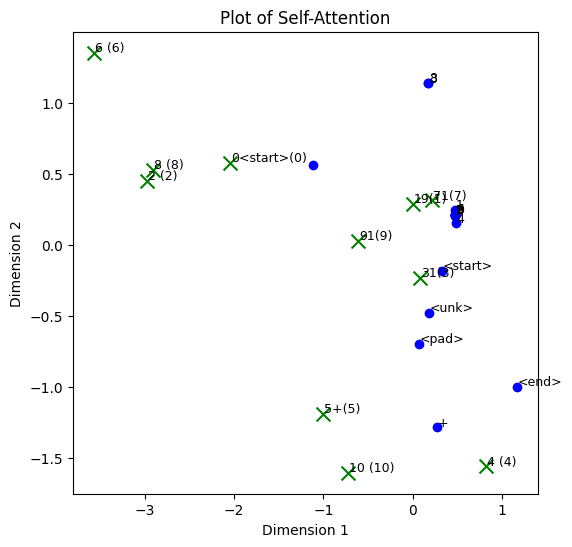

QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 11, 15])
AV.shape: torch.Size([1, 11, 4])
After Attention: tensor([[[-3.1707,  5.0897,  0.8091, -0.7161]],

        [[-2.5746,  4.5216,  2.0851, -1.7079]],

        [[ 1.3106,  3.2812, -4.3970, -0.4579]],

        [[-2.6674,  4.2029,  2.5601, -1.7065]],

        [[-1.1322, -3.2123, -0.2907,  3.6234]],

        [[-3.3562,  2.7948,  3.9843, -1.0084]],

        [[ 0.0762,  4.7670, -1.5238, -2.1036]],

        [[-2.4211,  4.5570,  1.9952, -1.8205]],

        [[ 1.2665,  3.3644, -4.3650, -0.4922]],

        [[-3.0057,  4.2291,  2.5187, -1.3769]],

        [[-1.6323, -2.8884, -0.0089,  3.7020]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[-0.01509826  1.0644784   1.1070098  -2.6133645 ]]

 [[-1.7077427   3.0784407   3.6837628  -3.3321095 ]]

 [[ 2.829346   -0.6163881  -1.9762105  -2.9071722 ]]

 [[-1.7120011   3.042027    3.67558    -3.31833

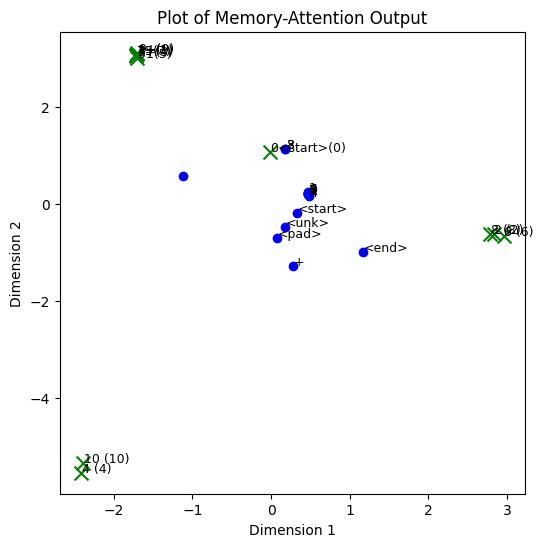

[[[-3.1707091   5.0896673   0.80907536 -0.7160872 ]]

 [[-2.5746105   4.5215826   2.0851247  -1.7079145 ]]

 [[ 1.3106208   3.2811952  -4.3969574  -0.45790684]]

 [[-2.6674435   4.202949    2.5601425  -1.7064605 ]]

 [[-1.1321802  -3.2122855  -0.29066497  3.6233668 ]]

 [[-3.356206    2.7948077   3.9843109  -1.008371  ]]

 [[ 0.07615022  4.766963   -1.5237951  -2.1035657 ]]

 [[-2.4210632   4.5570188   1.9952185  -1.820517  ]]

 [[ 1.2664713   3.3644435  -4.3649673  -0.49219328]]

 [[-3.005651    4.2290616   2.5187483  -1.3768526 ]]

 [[-1.6323192  -2.8883913  -0.0089361   3.702017  ]]]
(11, 1, 4)
[[-3.1707091   5.0896673 ]
 [-2.5746105   4.5215826 ]
 [ 1.3106208   3.2811952 ]
 [-2.6674435   4.202949  ]
 [-1.1321802  -3.2122855 ]
 [-3.356206    2.7948077 ]
 [ 0.07615022  4.766963  ]
 [-2.4210632   4.5570188 ]
 [ 1.2664713   3.3644435 ]
 [-3.005651    4.2290616 ]
 [-1.6323192  -2.8883913 ]]


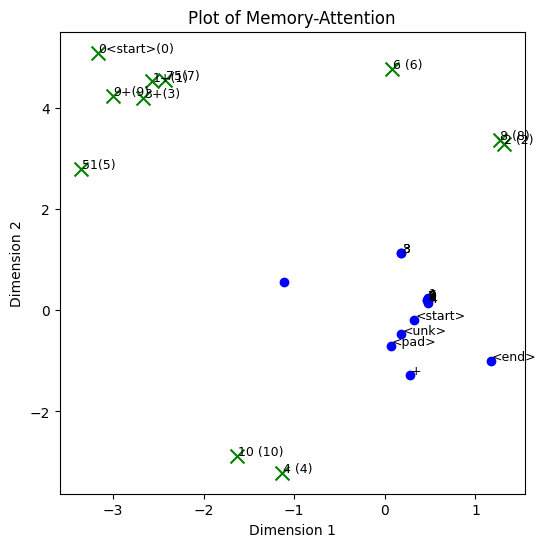

output.shape: torch.Size([1, 16])
output: tensor([[-1.0744, -1.1540, -1.0630,  0.0887,  2.3236, -1.0726, -1.0858, -1.0509,  0.0836, -1.0746,
         -2.1959, -1.8932, -2.0772, -2.9054,  8.2481, -1.5036]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 11
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15],
        [ 1],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 1.3579, -0.4255, -2.6513,  1.1617]],

        [[-2

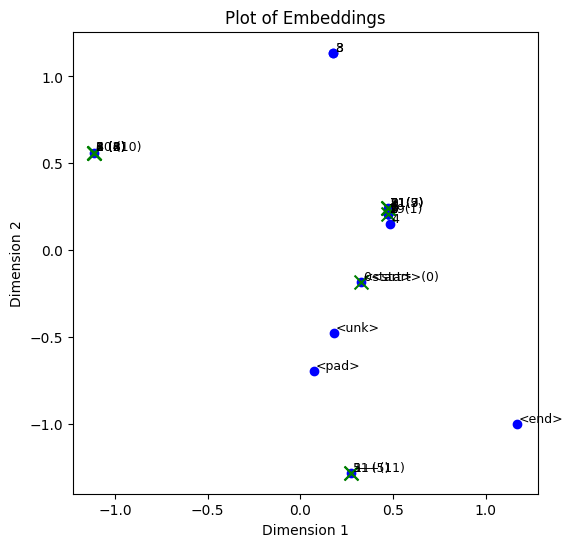

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]

 [[-2.9838116   0.46917593  1.994078    0.08571714]]

 [[-0.4091825  -2.2829523   1.3284073   3.6977143 ]]

 [[-2.5064244   2.0829897   2.0140526   0.08471757]]

 [[ 1.6027195   1.2394984  -2.6712625   1.1633432 ]]

 [[-1.2376509   0.9773195   2.0340033   0.08331871]]

 [[ 1.3578515  -0.4255342  -2.651327    1.1617448 ]]

 [[-2.7710302   0.28374803  2.0539222   0.08152121]]

 [[-0.45024842 -2.5621889   1.3882064   3.6929202 ]]]
(12, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]
 [-2.9838116   0.46917593]
 [-0.4091825  -2.2829523 ]
 [-2.5064244   2.0829897 ]
 [ 1.6027195   1.2394984 ]
 [-1.2376509   0.9773195 ]
 [ 1.3578515  -0.4255342 ]
 [-2.7710302   0.28374803]
 [-0.45024842 -2.5621889 ]]


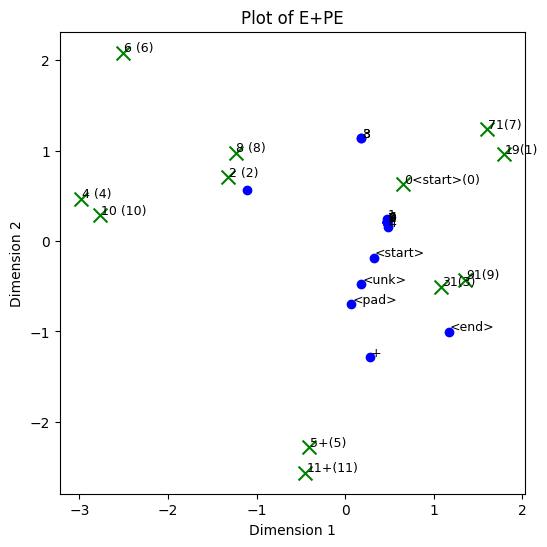

SelfAttention Layer
QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 12, 4])
WV.shape: torch.Size([1, 12, 4])
attn_weight.shape: torch.Size([1, 12, 12])
AV.shape: torch.Size([1, 12, 4])
[[[-2.2577515   1.0294602  -3.1206708   4.0051384 ]]

 [[-0.11533044 -0.24356231 -3.4652336   2.1718526 ]]

 [[-0.81661093  0.18040809 -3.3817842   2.7887385 ]]

 [[-0.71497726 -0.029098   -2.1178567   2.079263  ]]

 [[ 3.0652003  -2.4804208  -0.25114316 -2.3129947 ]]

 [[ 0.7091751  -0.6720141  -3.8753722   1.6193142 ]]

 [[ 2.1906288  -1.7447318  -2.3850322  -0.4819629 ]]

 [[ 0.43987277 -0.57403564 -3.5291264   1.6860148 ]]

 [[-0.42546675 -0.04009947 -3.5144432   2.4901788 ]]

 [[-1.59216     0.5640191  -2.7228134   3.1834342 ]]

 [[ 2.110376   -1.8547558  -0.7670165  -1.1792182 ]]

 [[ 0.24519242 -0.3979706  -3.7860196   2.0092802 ]]]
(12, 1, 4)
[[-2.2577515   1.0294602 ]
 [-0.11533044 -0.24356231]
 [-0.81661093  0.18040809]
 [-0.71497726 -0.029098  ]
 [ 3.0652003  -2.4804208 ]
 [ 0.709175

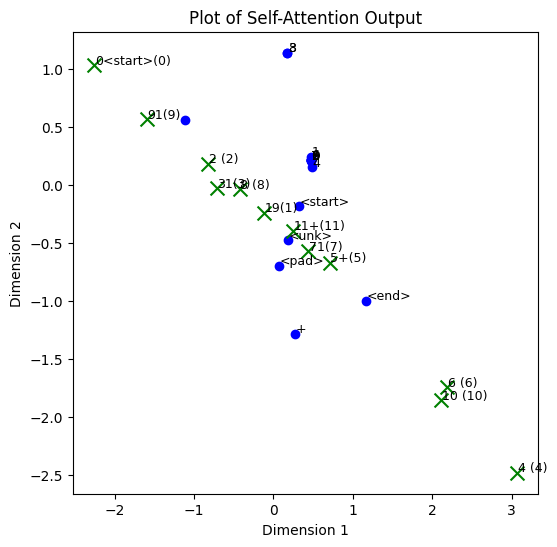

[[[-1.3878679   0.49429443 -1.6226631   1.3549001 ]]

 [[ 1.1416973   0.03991542 -2.188303    0.9596436 ]]

 [[-2.4426508   0.32323962 -0.9888635   1.4507289 ]]

 [[ 0.6607758  -0.354845   -1.9870859   1.290221  ]]

 [[ 0.9771762  -1.5936811   1.817819   -1.0279332 ]]

 [[ 0.22023498 -1.6517539  -1.0392226   1.6276376 ]]

 [[-0.9131344   2.26339    -0.81540513 -0.7162254 ]]

 [[ 1.4145464   0.03954955 -2.2089112   0.8515615 ]]

 [[-2.1885445   0.40973604 -1.1828004   1.4293662 ]]

 [[ 0.06700119 -0.12351792 -1.9356177   1.3621278 ]]

 [[-0.27198106 -1.7588696   2.0908632  -0.5606826 ]]

 [[-0.1196595  -1.605756   -0.94768333  1.678728  ]]]
(12, 1, 4)
[[-1.3878679   0.49429443]
 [ 1.1416973   0.03991542]
 [-2.4426508   0.32323962]
 [ 0.6607758  -0.354845  ]
 [ 0.9771762  -1.5936811 ]
 [ 0.22023498 -1.6517539 ]
 [-0.9131344   2.26339   ]
 [ 1.4145464   0.03954955]
 [-2.1885445   0.40973604]
 [ 0.06700119 -0.12351792]
 [-0.27198106 -1.7588696 ]
 [-0.1196595  -1.605756  ]]


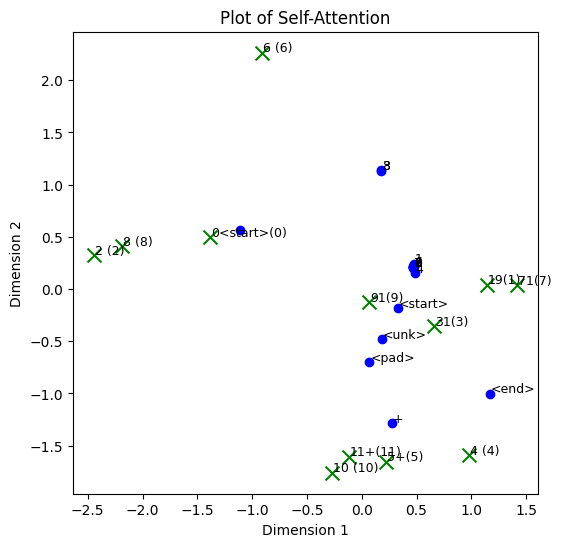

QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 12, 15])
AV.shape: torch.Size([1, 12, 4])
After Attention: tensor([[[-3.2076,  4.2778,  2.3926, -1.1381]],

        [[-1.7483,  4.3752,  1.9381, -2.3006]],

        [[ 0.6069,  4.0834, -4.3998, -0.3273]],

        [[-2.2602,  4.1535,  2.5224, -2.0358]],

        [[-1.0753, -3.2418, -0.3265,  3.6119]],

        [[-2.7523,  2.0472,  4.6504, -1.5009]],

        [[ 1.5521,  3.3199, -2.9562, -1.6252]],

        [[-1.4919,  4.2948,  1.8640, -2.4430]],

        [[-1.5128,  5.4602, -3.1502, -0.0318]],

        [[-2.6501,  4.2829,  2.4477, -1.7054]],

        [[-1.4714, -3.0242, -0.0606,  3.6732]],

        [[-2.9639,  2.1748,  4.5514, -1.3231]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[-1.6841552   3.1642277   3.679169   -3.3440628 ]]

 [[-1.7246892   2.8936021   3.633871   -3.2548544 ]]

 [[ 1.8055536  -0.5712791  -1.0300058  -2.756466  ]]

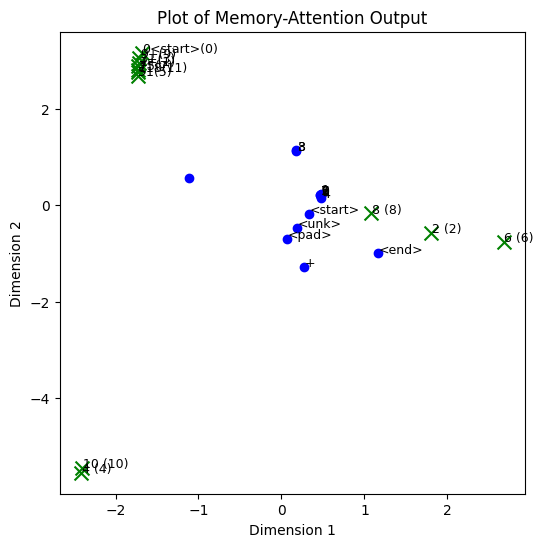

[[[-3.2075546   4.2777686   2.3925774  -1.1381031 ]]

 [[-1.7482889   4.3752365   1.9380503  -2.3006322 ]]

 [[ 0.606942    4.083422   -4.3997836  -0.32733396]]

 [[-2.2601876   4.153525    2.522358   -2.035806  ]]

 [[-1.075285   -3.241759   -0.3265041   3.6118665 ]]

 [[-2.7522526   2.047186    4.6504374  -1.5009067 ]]

 [[ 1.5520891   3.3199353  -2.9561963  -1.6251762 ]]

 [[-1.4919093   4.294847    1.8639737  -2.443021  ]]

 [[-1.5128362   5.460211   -3.1501548  -0.03184725]]

 [[-2.6501184   4.282927    2.4476917  -1.7054466 ]]

 [[-1.4714047  -3.024178   -0.0605728   3.673234  ]]

 [[-2.9639256   2.1747546   4.5514235  -1.3230624 ]]]
(12, 1, 4)
[[-3.2075546  4.2777686]
 [-1.7482889  4.3752365]
 [ 0.606942   4.083422 ]
 [-2.2601876  4.153525 ]
 [-1.075285  -3.241759 ]
 [-2.7522526  2.047186 ]
 [ 1.5520891  3.3199353]
 [-1.4919093  4.294847 ]
 [-1.5128362  5.460211 ]
 [-2.6501184  4.282927 ]
 [-1.4714047 -3.024178 ]
 [-2.9639256  2.1747546]]


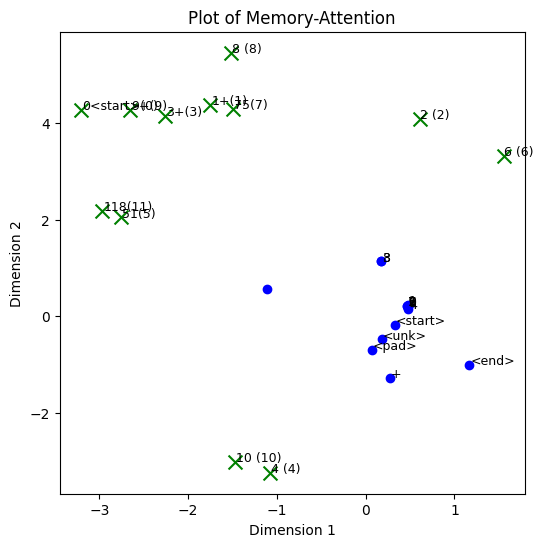

output.shape: torch.Size([1, 16])
output: tensor([[-7.3667, -7.2214, -7.3726, -0.2744, -7.3376, -7.3625, -7.3375, -7.3760, -0.2695, -7.3795,
         -0.0713, -0.5944, -0.9539,  3.3467, -2.4817,  9.5725]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 15

------------------

iter: 12
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15],
        [ 1],
        [15],
        [14],
        [15]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 1.3579, -0.4255, -2.6513,  1.1617]],

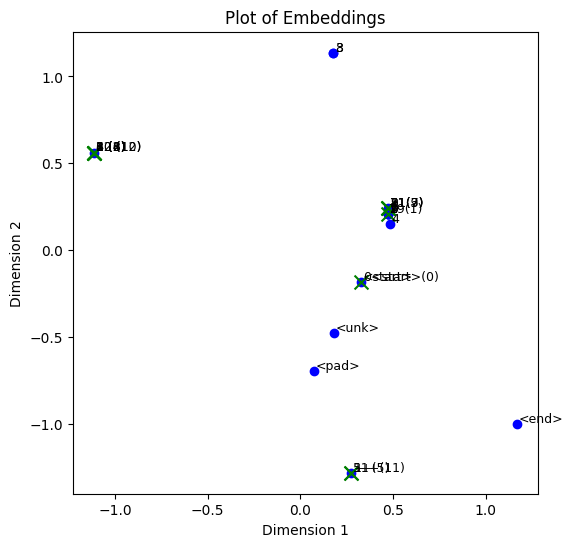

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]

 [[-2.9838116   0.46917593  1.994078    0.08571714]]

 [[-0.4091825  -2.2829523   1.3284073   3.6977143 ]]

 [[-2.5064244   2.0829897   2.0140526   0.08471757]]

 [[ 1.6027195   1.2394984  -2.6712625   1.1633432 ]]

 [[-1.2376509   0.9773195   2.0340033   0.08331871]]

 [[ 1.3578515  -0.4255342  -2.651327    1.1617448 ]]

 [[-2.7710302   0.28374803  2.0539222   0.08152121]]

 [[-0.45024842 -2.5621889   1.3882064   3.6929202 ]]

 [[-2.763582    1.9666735   2.0738008   0.07932568]]]
(13, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]
 [-2.9838116   0.46917593]
 [-0.4091825  -2.2829523 ]
 [-2.5064244   2.0829897 ]
 [ 1.6027195   1.2394984 ]
 [-1.2376509   0.9773195 ]
 [ 1.3578515  -0.4255342 ]
 [-2.7710302   0.

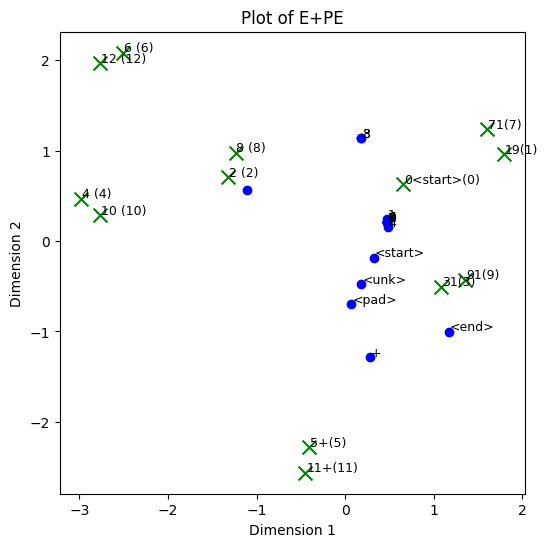

SelfAttention Layer
QV.shape: torch.Size([1, 13, 4])
KV.shape: torch.Size([1, 13, 4])
WV.shape: torch.Size([1, 13, 4])
attn_weight.shape: torch.Size([1, 13, 13])
AV.shape: torch.Size([1, 13, 4])
[[[-2.246589    1.0223663  -3.1135325   3.9915767 ]]

 [[-0.10427724 -0.2508349  -3.4533608   2.1562674 ]]

 [[-0.80917156  0.17557302 -3.3751333   2.7788446 ]]

 [[-0.5223273  -0.14822033 -1.9953448   1.8473893 ]]

 [[ 3.1827857  -2.53561    -0.09374814 -2.4787524 ]]

 [[ 0.7091751  -0.6720139  -3.8753717   1.6193141 ]]

 [[ 2.268587   -1.7967887  -2.2348692  -0.62030804]]

 [[ 0.45175663 -0.5819764  -3.5140479   1.6682175 ]]

 [[-0.4217957  -0.04251477 -3.5107448   2.4851048 ]]

 [[-1.51012     0.51252353 -2.6699288   3.0839589 ]]

 [[ 2.3172302  -1.9731997  -0.5818293  -1.445285  ]]

 [[ 0.24519254 -0.3979706  -3.7860196   2.0092802 ]]

 [[ 2.6439166  -2.0948653  -1.4196655  -1.3520201 ]]]
(13, 1, 4)
[[-2.246589    1.0223663 ]
 [-0.10427724 -0.2508349 ]
 [-0.80917156  0.17557302]
 [-0.522327

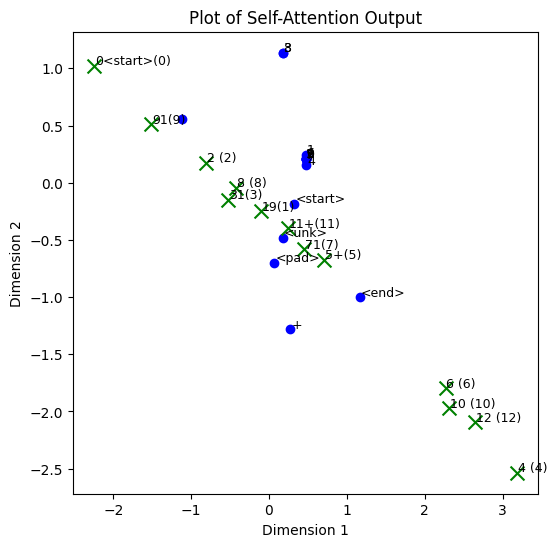

[[[-1.3832551   0.49352506 -1.6244925   1.3547726 ]]

 [[ 1.150815    0.03766131 -2.1886728   0.95731556]]

 [[-2.4432685   0.32204163 -0.98796743  1.4511206 ]]

 [[ 0.84504294 -0.4154632  -1.9981078   1.2563157 ]]

 [[ 1.0439613  -1.5615954   1.7932423  -1.060929  ]]

 [[ 0.2202349  -1.6517538  -1.0392225   1.6276375 ]]

 [[-0.4237187   2.0321114  -0.22665241 -1.2490973 ]]

 [[ 1.4251801   0.03694643 -2.2089057   0.8484816 ]]

 [[-2.1886678   0.40926534 -1.1825624   1.429556  ]]

 [[ 0.12416144 -0.14149074 -1.9441956   1.355139  ]]

 [[ 0.13639966 -1.7350643   2.0344405  -0.7188274 ]]

 [[-0.1196595  -1.605756   -0.94768333  1.678728  ]]

 [[ 0.35169116 -0.1133382   1.5923052  -1.5777545 ]]]
(13, 1, 4)
[[-1.3832551   0.49352506]
 [ 1.150815    0.03766131]
 [-2.4432685   0.32204163]
 [ 0.84504294 -0.4154632 ]
 [ 1.0439613  -1.5615954 ]
 [ 0.2202349  -1.6517538 ]
 [-0.4237187   2.0321114 ]
 [ 1.4251801   0.03694643]
 [-2.1886678   0.40926534]
 [ 0.12416144 -0.14149074]
 [ 0.13639966 -1.

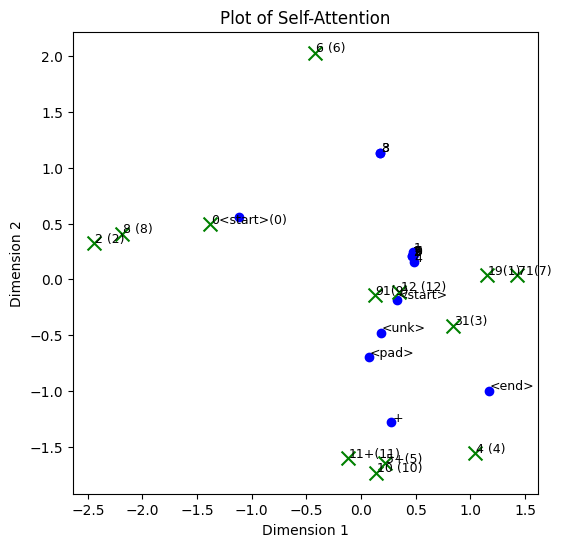

QV.shape: torch.Size([1, 13, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 13, 15])
AV.shape: torch.Size([1, 13, 4])
After Attention: tensor([[[-3.2061,  4.2788,  2.3916, -1.1396]],

        [[-1.7403,  4.3719,  1.9375, -2.3056]],

        [[ 0.6113,  4.0791, -4.4005, -0.3281]],

        [[-2.1114,  4.0914,  2.5414, -2.1473]],

        [[-1.0543, -3.2468, -0.3493,  3.6097]],

        [[-2.7523,  2.0472,  4.6504, -1.5009]],

        [[-1.8879, -1.0134, -2.0067,  3.9495]],

        [[-1.4819,  4.2896,  1.8636, -2.4487]],

        [[-1.5117,  5.4596, -3.1519, -0.0314]],

        [[-2.6163,  4.2791,  2.4482, -1.7354]],

        [[-1.3446, -3.1114, -0.1251,  3.6523]],

        [[-2.9639,  2.1748,  4.5514, -1.3231]],

        [[-1.4214, -2.7534, -0.5831,  3.7747]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[-1.6842595   3.1640162   3.6792607  -3.3441017 ]]

 [[-1.7248547   2.891172    3.6331136  -3.253751  ]]

 [[

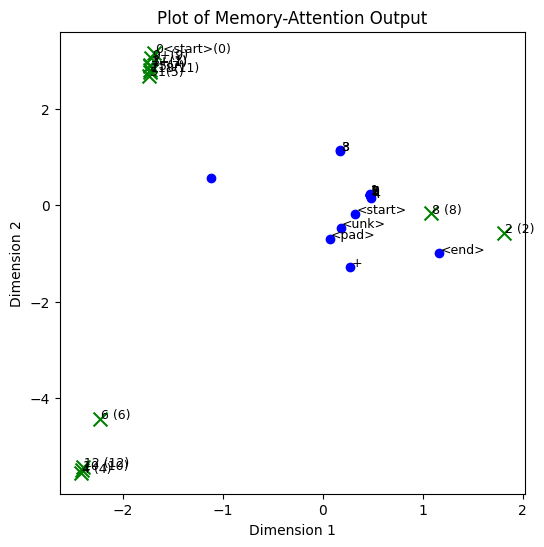

[[[-3.2060812   4.278839    2.3915825  -1.13959   ]]

 [[-1.7403407   4.371932    1.9374809  -2.305594  ]]

 [[ 0.61127484  4.079076   -4.400525   -0.32805774]]

 [[-2.111392    4.09137     2.54143    -2.1473215 ]]

 [[-1.0542548  -3.2467804  -0.34934837  3.6097445 ]]

 [[-2.7522526   2.047186    4.650437   -1.5009067 ]]

 [[-1.887858   -1.0134261  -2.006683    3.9495087 ]]

 [[-1.4819226   4.2895575   1.8635733  -2.4486911 ]]

 [[-1.5116761   5.459611   -3.1519291  -0.03142084]]

 [[-2.616254    4.279134    2.448243   -1.7353828 ]]

 [[-1.3445511  -3.111371   -0.12506396  3.6522632 ]]

 [[-2.9639256   2.1747546   4.5514235  -1.3230624 ]]

 [[-1.4214385  -2.753396   -0.5830884   3.7746773 ]]]
(13, 1, 4)
[[-3.2060812   4.278839  ]
 [-1.7403407   4.371932  ]
 [ 0.61127484  4.079076  ]
 [-2.111392    4.09137   ]
 [-1.0542548  -3.2467804 ]
 [-2.7522526   2.047186  ]
 [-1.887858   -1.0134261 ]
 [-1.4819226   4.2895575 ]
 [-1.5116761   5.459611  ]
 [-2.616254    4.279134  ]
 [-1.3445511  -3.

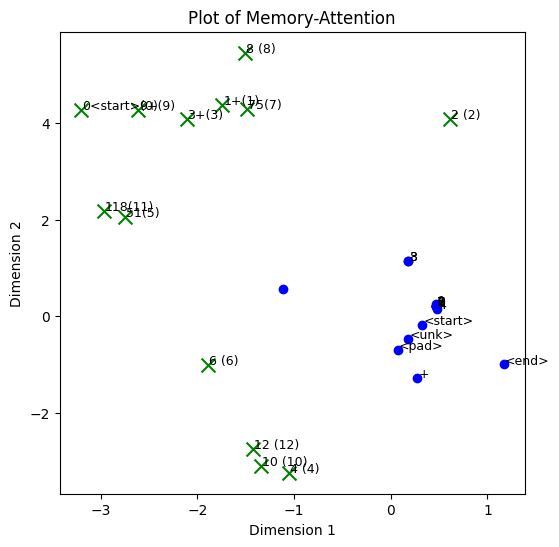

output.shape: torch.Size([1, 16])
output: tensor([[-0.1438, -0.2286, -0.1318,  0.4663,  3.1425, -0.1418, -0.1562, -0.1202,  0.4609, -0.1428,
         -2.3291, -2.0192, -2.0326, -3.8289,  7.8639, -2.2568]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 13
ys: tensor([[12],
        [ 9],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [ 1],
        [15],
        [ 1],
        [15],
        [14],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[ 0.6536,  0.6322, -0.1438, -0.1214]],

        [[ 1.7888,  0.9578, -2.7699,  1.1561]],

        [[-1.3177,  0.7067,  1.9741,  0.0863]],

        [[ 1.0869, -0.5044, -2.7112,  1.1653]],

        [[-2.9838,  0.4692,  1.9941,  0.0857]],

        [[-0.4092, -2.2830,  1.3284,  3.6977]],

        [[-2.5064,  2.0830,  2.0141,  0.0847]],

        [[ 1.6027,  1.2395, -2.6713,  1.1633]],

        [[-1.2377,  0.9773,  2.0340,  0.0833]],

        [[ 1.3579, -0.4255, -2.65

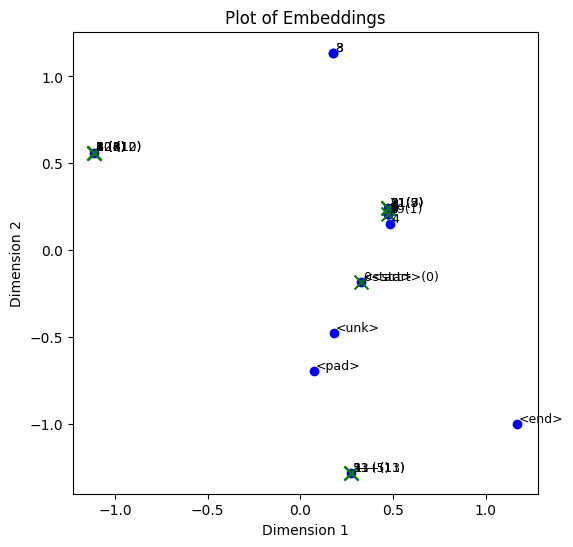

[[[ 0.65358996  0.6321694  -0.14377145 -0.12135041]]

 [[ 1.7888049   0.95776165 -2.7698996   1.1561054 ]]

 [[-1.3177116   0.70667267  1.9740874   0.08631706]]

 [[ 1.086853   -0.50439644 -2.71121     1.1653422 ]]

 [[-2.9838116   0.46917593  1.994078    0.08571714]]

 [[-0.4091825  -2.2829523   1.3284073   3.6977143 ]]

 [[-2.5064244   2.0829897   2.0140526   0.08471757]]

 [[ 1.6027195   1.2394984  -2.6712625   1.1633432 ]]

 [[-1.2376509   0.9773195   2.0340033   0.08331871]]

 [[ 1.3578515  -0.4255342  -2.651327    1.1617448 ]]

 [[-2.7710302   0.28374803  2.0539222   0.08152121]]

 [[-0.45024842 -2.5621889   1.3882064   3.6929202 ]]

 [[-2.763582    1.9666735   2.0738008   0.07932568]]

 [[ 0.96990883 -1.6591678   1.4080622   3.690526  ]]]
(14, 1, 4)
[[ 0.65358996  0.6321694 ]
 [ 1.7888049   0.95776165]
 [-1.3177116   0.70667267]
 [ 1.086853   -0.50439644]
 [-2.9838116   0.46917593]
 [-0.4091825  -2.2829523 ]
 [-2.5064244   2.0829897 ]
 [ 1.6027195   1.2394984 ]
 [-1.2376509   0.

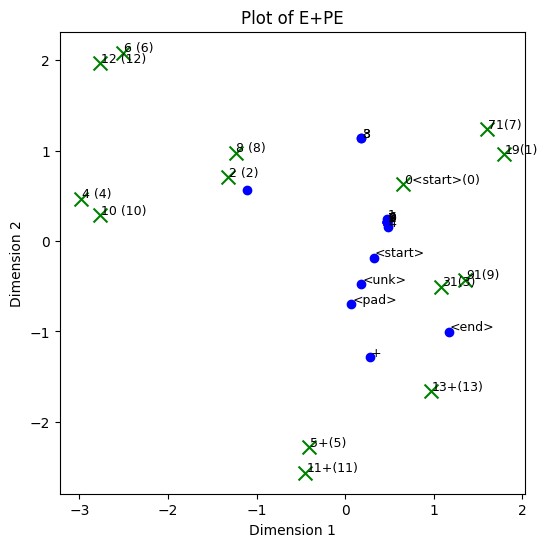

SelfAttention Layer
QV.shape: torch.Size([1, 14, 4])
KV.shape: torch.Size([1, 14, 4])
WV.shape: torch.Size([1, 14, 4])
attn_weight.shape: torch.Size([1, 14, 14])
AV.shape: torch.Size([1, 14, 4])
[[[ 1.0856068  -0.8992876  -3.389306    1.0851872 ]]

 [[ 2.4823208  -1.7233789  -3.5850604  -0.11664942]]

 [[ 2.5640047  -1.7593513  -3.571467   -0.1870996 ]]

 [[ 0.00834574 -0.4373208  -2.1604373   1.4460591 ]]

 [[ 3.2049448  -2.5431821  -0.13789241 -2.4769223 ]]

 [[ 4.965222   -3.1365519  -3.7145329  -2.2970178 ]]

 [[ 2.8822472  -2.102308   -2.5670524  -1.0041772 ]]

 [[ 2.759988   -1.8886406  -3.6151414  -0.3603715 ]]

 [[ 3.197272   -2.1212368  -3.6459143  -0.7283331 ]]

 [[-0.25223306 -0.19644204 -2.871527    2.0380678 ]]

 [[ 2.4051359  -2.0119772  -0.6844484  -1.4742355 ]]

 [[ 4.956709   -3.131574   -3.7138896  -2.2895186 ]]

 [[ 2.9328544  -2.2250767  -1.7009782  -1.4718127 ]]

 [[ 4.9965425  -3.1546848  -3.7133424  -2.3258386 ]]]
(14, 1, 4)
[[ 1.0856068  -0.8992876 ]
 [ 2.482320

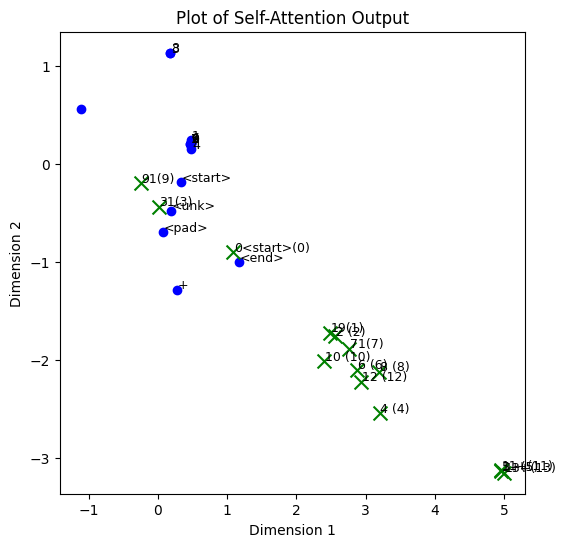

[[[ 2.2720065  -0.2996181  -2.1173358   0.61942583]]

 [[ 2.7741554  -0.42590737 -2.0038793   0.38636097]]

 [[ 3.3967364  -1.2390516  -1.4910091   0.25181368]]

 [[ 1.3275906  -0.5251669  -2.0255964   1.1328138 ]]

 [[ 1.0882857  -1.5707865   1.7783014  -1.0630164 ]]

 [[ 3.0092373  -2.2626503  -0.69157225  0.4955367 ]]

 [[ 2.9906735   0.47606546 -0.7470915  -1.3294176 ]]

 [[ 2.8365345  -0.3852142  -1.994944    0.32285437]]

 [[ 3.7870119  -1.1494763  -1.1999657  -0.21919212]]

 [[ 1.1226652  -0.37991363 -2.0566816   1.1515915 ]]

 [[ 0.339542   -1.7863543   1.9887486  -0.74021095]]

 [[ 2.9658618  -2.3092227  -0.6379517   0.5046904 ]]

 [[ 1.4973649  -0.2639289   1.1875724  -1.6766022 ]]

 [[ 3.291464   -2.0908368  -0.7826929   0.32114866]]]
(14, 1, 4)
[[ 2.2720065  -0.2996181 ]
 [ 2.7741554  -0.42590737]
 [ 3.3967364  -1.2390516 ]
 [ 1.3275906  -0.5251669 ]
 [ 1.0882857  -1.5707865 ]
 [ 3.0092373  -2.2626503 ]
 [ 2.9906735   0.47606546]
 [ 2.8365345  -0.3852142 ]
 [ 3.7870119  -1.

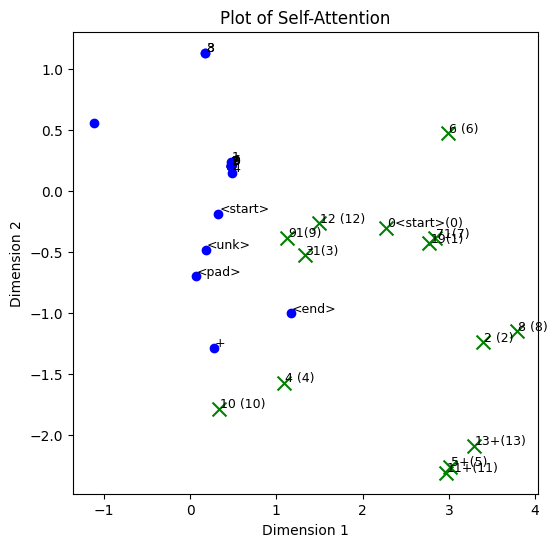

QV.shape: torch.Size([1, 14, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 14, 15])
AV.shape: torch.Size([1, 14, 4])
After Attention: tensor([[[-5.4856e-01,  3.4858e+00,  2.0207e+00, -2.8939e+00]],

        [[ 1.1438e-01,  2.7171e+00,  2.1005e+00, -3.0571e+00]],

        [[ 1.0046e+00,  3.9790e-01,  2.9263e+00, -2.8664e+00]],

        [[-1.6501e+00,  3.8833e+00,  2.5417e+00, -2.4454e+00]],

        [[-1.0381e+00, -3.2544e+00, -3.6018e-01,  3.6065e+00]],

        [[ 5.5149e-01, -1.4049e+00,  4.3579e+00, -2.1315e+00]],

        [[ 2.0746e-03,  2.2211e+00,  2.7646e+00, -3.0376e+00]],

        [[ 1.7798e-01,  2.6769e+00,  2.0582e+00, -3.0636e+00]],

        [[ 1.1310e+00,  2.4815e-01,  2.8387e+00, -2.8303e+00]],

        [[-1.8401e+00,  4.0831e+00,  2.4067e+00, -2.3139e+00]],

        [[-1.2736e+00, -3.1580e+00, -1.6078e-01,  3.6389e+00]],

        [[ 4.9688e-01, -1.4653e+00,  4.4321e+00, -2.0861e+00]],

        [[-9.6263e-01, -2.95

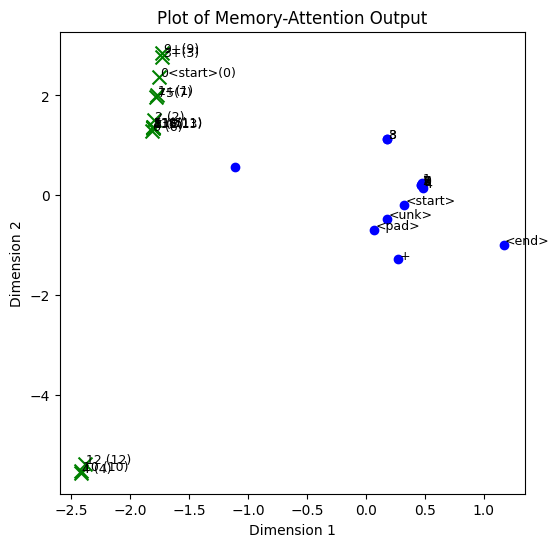

[[[-5.4856014e-01  3.4858160e+00  2.0206902e+00 -2.8938825e+00]]

 [[ 1.1438279e-01  2.7171206e+00  2.1005044e+00 -3.0570648e+00]]

 [[ 1.0045822e+00  3.9789712e-01  2.9262884e+00 -2.8664179e+00]]

 [[-1.6501449e+00  3.8833127e+00  2.5417466e+00 -2.4454434e+00]]

 [[-1.0381477e+00 -3.2544227e+00 -3.6018005e-01  3.6064520e+00]]

 [[ 5.5148792e-01 -1.4048772e+00  4.3578825e+00 -2.1315322e+00]]

 [[ 2.0746067e-03  2.2211053e+00  2.7645810e+00 -3.0376406e+00]]

 [[ 1.7797536e-01  2.6769316e+00  2.0581906e+00 -3.0636232e+00]]

 [[ 1.1309509e+00  2.4814796e-01  2.8386917e+00 -2.8302722e+00]]

 [[-1.8400830e+00  4.0831113e+00  2.4067085e+00 -2.3139477e+00]]

 [[-1.2736311e+00 -3.1580083e+00 -1.6078311e-01  3.6389089e+00]]

 [[ 4.9687931e-01 -1.4653330e+00  4.4320641e+00 -2.0860553e+00]]

 [[-9.6262926e-01 -2.9548235e+00 -9.4071031e-01  3.7010131e+00]]

 [[ 8.0494809e-01 -1.1657708e+00  3.9933589e+00 -2.3019350e+00]]]
(14, 1, 4)
[[-5.4856014e-01  3.4858160e+00]
 [ 1.1438279e-01  2.7171206e+00]

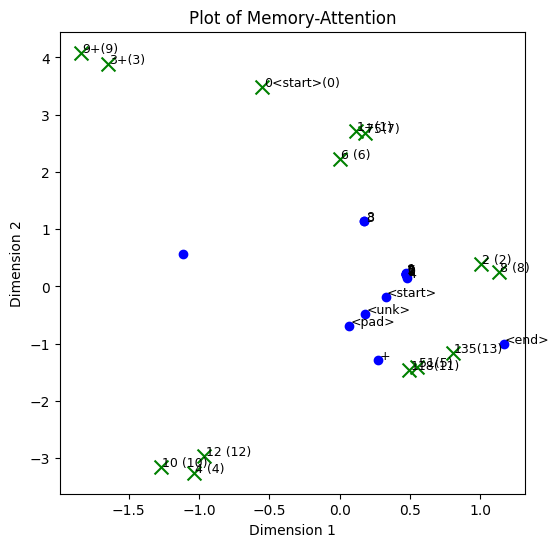

output.shape: torch.Size([1, 16])
output: tensor([[-5.5878, -5.5665, -5.5994, -4.2561, -6.3511, -5.5941, -5.5868, -5.5975, -4.2530, -5.5924,
          3.0407,  3.0375,  1.4810, 11.1827,  1.1635,  3.4023]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 13

------------------

Input: + + 1 5 + 8 5
Decoded sequence: 9 1 + 1 1 + +


In [37]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt_embed, title="E+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Self-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=self_attn_output, title="Self-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, title="Self-Attention")

    


    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    print(f"After Attention: {tgt}")
    # Memory-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=multi_attn_output, src=src, title="Memory-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, src=src, title="Memory-Attention")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

# Transformerの検算

スクラッチで書くための検算

## Multihead Attention

Multihead Attentionの動作をスクラッチで書きたいので、ここで検算する

参考サイト
https://blog.amedama.jp/entry/pytorch-multi-head-attention-verify

In [30]:
import torch
from torch import nn
import torch.nn.functional as F


In [31]:
edim = 4 # 埋め込み次元
num_heads = 1 # ヘッド数
model = nn.MultiheadAttention(edim, num_heads, bias=True, batch_first=True)

In [ ]:
batch_size = 2
L=5
X = torch.randn(batch_size, L, edim) # 入力

Q = K = V = X # クエリ、キー、バリューは全て入力とする
print(Q.shape)
print(Q)

In [ ]:

attn_output, attn_output_weights = model(Q, K, V)

print(attn_output.shape)
print(attn_output)



In [ ]:
from pprint import pprint
pprint(list(model.named_parameters()))

In [35]:
model_weight = {name: param.data for name, param in model.named_parameters()}
Wi = model_weight['in_proj_weight']
Wo = model_weight['out_proj.weight']
Wbi = model_weight['in_proj_bias']
Wbo = model_weight['out_proj.bias']

In [36]:
Wi_q, Wi_k, Wi_v = Wi.chunk(3, dim=0)
Wbi_q, Wbi_k, Wbi_v = Wbi.chunk(3, dim=0)
QW = torch.matmul(Q, Wi_q.T) + Wbi_q
KW = torch.matmul(K, Wi_k.T) + Wbi_k
VW = torch.matmul(V, Wi_v.T) + Wbi_v

KW_t = KW.transpose(-2, -1)
QK_t = torch.bmm(QW, KW_t)
QK_scaled = QK_t / (edim ** 0.5)
attn_weights_ = F.softmax(QK_scaled, dim=-1)

In [ ]:
print(attn_weights_)
print(attn_output_weights)

In [38]:
AV = torch.matmul(attn_weights_, VW)
attn_output_ = torch.matmul(AV, Wo.T) + Wbo

In [ ]:
print(attn_output_)
print(attn_output)

## nn.Linear

In [ ]:
model = nn.Linear(4, 4)
model

In [ ]:
pprint(list(model.named_parameters()))

In [ ]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


In [ ]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

## nn.LayerNorm

参考サイト
https://qiita.com/dl_from_scratch/items/133fe741b67ed14f1856

In [ ]:
model = nn.LayerNorm(4)
model

In [ ]:
pprint(list(model.named_parameters()))

In [ ]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


In [ ]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)